# [IDH] Diversity-Disturbance Relationship

In [1]:
import numpy as np
import pandas as pd
from math import ceil
import scipy.stats as scs

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib.cm import ScalarMappable
import seaborn as sns

In [2]:
import os
import sys
import glob

sys.path.insert(1, '..')
import biofire_tools as bft

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [8]:
fpath_in = "../../../gvissio/tilman/results2/"
fpath_out = "/work/users/mtorrassa/biofire-idh/data"

In [4]:
sns.set_theme(context="paper", style="whitegrid", font_scale=1.5, rc={"lines.linewidth": 2})
# mpl.rcParams.update({'font.size': 30})

## Distributions of simulated communities

### C-M linear regression

In [5]:
I_med = np.arange(1,7)
C_med = np.array([0.047, 0.053, 0.045, 0.067, 0.11, 0.22])
M_med = np.array([1/400, 1/125, 1/50, 1/25, 1/15, 1/40])
print('Mediterranean Forest')

reg_icm = scs.linregress(x=I_med, y=C_med)
C_reg = reg_icm.intercept + reg_icm.slope*I_med
C_std_m = np.std(C_reg - C_med)
print(f'C(j) = {reg_icm.slope} * j + {reg_icm.intercept}, std = {C_std_m}')

reg_imm = scs.linregress(x=I_med, y=M_med)
M_reg = reg_imm.intercept + reg_imm.slope*I_med
M_std_m = np.std(M_reg - M_med)
print(f'M(j) = {reg_imm.slope} * j + {reg_imm.intercept}, std = {M_std_m}')

Mediterranean Forest
C(j) = 0.03022857142857142 * j + -0.015466666666666642, std = 0.03435214463857884
M(j) = 0.008814285714285715 * j + -0.003822222222222227, std = 0.01525934819155263


In [6]:
I_bor = np.arange(1,4)
C_bor = np.array([0.085, 0.13, 0.17])
M_bor = np.array([0.035, 0.015, 0.023])

reg_icb = scs.linregress(x=I_bor, y=C_bor)
C_reg = reg_icb.intercept + reg_icb.slope*I_bor
C_std_b = np.std(C_reg - C_bor)
print(f'C(j) = {reg_icb.slope} * j + {reg_icb.intercept}, std = {C_std_b}')

reg_imb = scs.linregress(x=I_bor, y=M_bor)
M_reg = reg_imb.intercept + reg_imb.slope*I_bor
M_std_b = np.std(M_reg - M_bor)
print(f'M(j) = {reg_imb.slope} * j + {reg_imb.intercept}, std = {M_std_b}')

C(j) = 0.0425 * j + 0.04333333333333332, std = 0.001178511301977577
M(j) = -0.006000000000000002 * j + 0.03633333333333334, std = 0.0065996632910744445


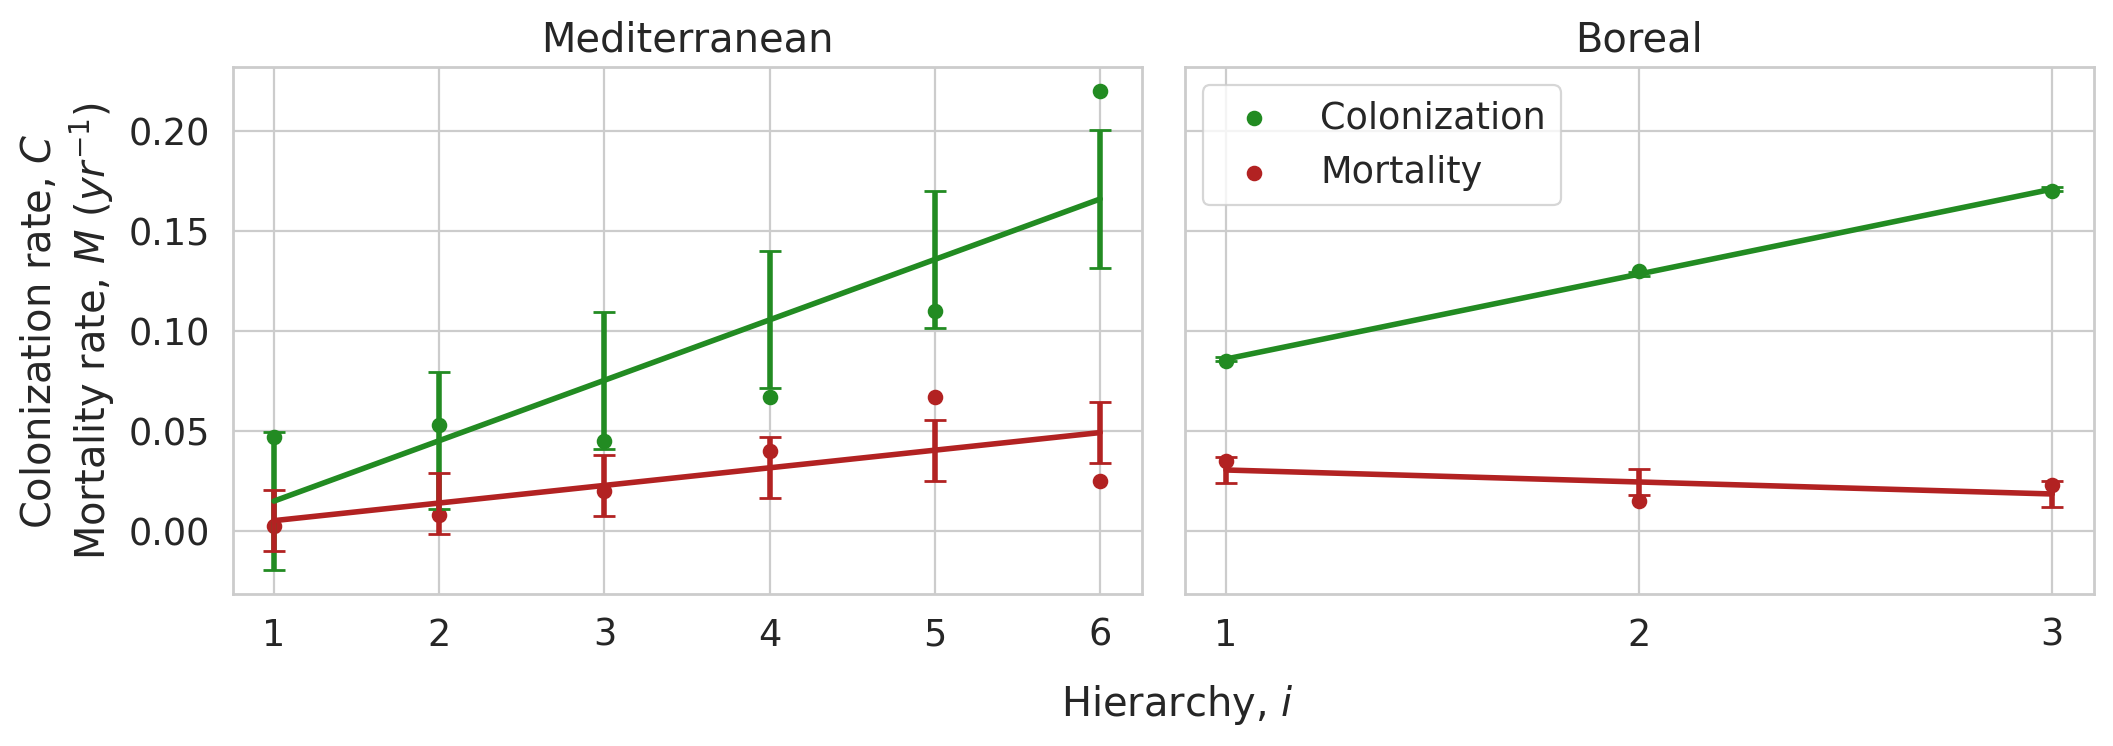

In [7]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True, dpi=200)

axs[0].scatter(I_med, C_med, c='forestgreen', label='Colonization')
axs[0].errorbar(I_med, reg_icm.intercept + reg_icm.slope*I_med, yerr=C_std_m, capsize=4, c='forestgreen')
axs[0].scatter(I_med, M_med, c='firebrick', label='Mortality')
axs[0].errorbar(I_med, reg_imm.intercept + reg_imm.slope*I_med,  c='firebrick', yerr=M_std_m, capsize=4)
axs[0].set_xticks(I_med)
axs[0].set_title('Mediterranean')

axs[1].scatter(I_bor, C_bor, c='forestgreen', label='Colonization')
axs[1].errorbar(I_bor, reg_icb.intercept + reg_icb.slope*I_bor, yerr=C_std_b, capsize=4, c='forestgreen')
axs[1].scatter(I_bor, M_bor, c='firebrick', label='Mortality')
axs[1].errorbar(I_bor, reg_imb.intercept + reg_imb.slope*I_bor,  c='firebrick', yerr=M_std_b, capsize=4)
axs[1].set_xticks(I_bor)
axs[1].set_title('Boreal')

axs[0].set_ylabel("Colonization rate, $C$ \nMortality rate, $M$ $(yr^{-1})$")

for ax in axs:
    ax.set_xlabel("Hierarchy, $i$")
    ax.set_xlabel("")
    ax.label_outer()

# Add a single x-label at the bottom
fig.text(0.55, 0.04, r"Hierarchy, $i$", ha='center', va='center')

# fig.savefig('regression_c_m_i.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')
# axs[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0)
axs[1].legend()
# plt.tight_layout()
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

## Combining the dataframes

### Ignoring alternate states

In [24]:
NPs = [10, 50]

# species survive with b >= 0.001
dc = 3
bmin = 10**(-dc)
vc = 10**dc

In [ ]:
# Compositional diversity (Species Richness, Inverse Simpson Index)
df_totN = pd.DataFrame()

# Dataframe representing the composition of the simulated communities, to estimate the hypervolumes metrices
df_comp = pd.DataFrame(index=['I','C','M','R','L']).T

for NP in NPs:

    print(f'Mediterranean - N{NP}')

    kcom = 0
    filelist = glob.glob(os.path.join(fpath_in, f'coefficients_{NP}_2024-*.txt'))

    for k, info_file in enumerate(filelist):

        print(k)

        nc_i = info_file.split("coefficients")[1]
                    
        bave_file = os.path.join(fpath_in, f'fixed_points{nc_i}')
        fire_file = os.path.join(fpath_in, f'firetimes{nc_i}')

        blist = [f'b{i+1}' for i in range(NP)]
        names = ['ncom', 'init']+[f'b{i+1}' for i in range(NP)]
        df_bave = pd.read_csv(bave_file, sep='\s+',names=names)
        df_bave = df_bave.where(df_bave>bmin).fillna(0)

        df_fr = pd.read_csv(fire_file, sep='\s+', names=['ncom','init','frt'])
        # df_fr = df_fr.groupby(['ncom','sim']).mean().reset_index()

#         df_stat = pd.DataFrame(df_bave.ge(bmin))
#         df_bave['init'] = df_stat.groupby(df_stat.columns.tolist()).ngroup() + 1

        df_res = df_bave
        df_res['ncom'] += kcom
        kcom = df_res['ncom'].max()
        
        df_res['N'] = NP
        df_res['biome'] = 'med'
        df_res['frt']=df_fr['frt']
        df_res = df_res.set_index(['biome','N','ncom','init',])#.groupby(['biome','N','ncom','sim']).mean()
        df_temp = df_res.reset_index() # this will be used later
        df_tot = df_res.drop(columns=blist)

        df_sr = pd.DataFrame(df_res[blist].ge(bmin).sum(axis=1))
        df_tot['srichness']=df_sr

        df_isi = df_res[blist].div(df_res[blist].sum(axis=1), axis=0)**2
        df_isi = 1 / df_isi.sum(axis=1)
        df_tot['isimpson'] = df_isi

        df_totN = pd.concat([df_totN, df_tot])

        # Dataset containing the communities composition that will be used for the estimation of the HV functional diversity metrices
        df_tot = df_tot.reset_index()
        arr = np.loadtxt(info_file)
        for indx, row in df_tot[df_tot['srichness']>1].iterrows():
            
            N = int(row['N'])
            i_com = int(row['ncom'])
            init = int(row['init'])

            i = i_com - 1 - kcom
            a = arr[i]

            # n_com = np.ones(NP) * int(arr[i][0])
            ind = np.arange(0,N)+1

            list_c = [4*j+1 for j in range(0,N)]
            C = arr[i][list_c]

            list_m = [4*j+2 for j in range(0,N)]
            M = arr[i][list_m]

            list_r = [4*j+3 for j in range(0,N)]
            R = arr[i][list_r]

            list_l = [4*j+4 for j in range(0,N)]
            L = arr[i][list_l]

            bmean = df_temp[df_temp.index==indx].drop(columns=['N','biome','ncom','init','frt']).to_numpy()
            # bmean = df_temp[df_temp.index==indx].to_numpy()[:,2:]
            vegcover = np.round(bmean*vc)

            df = pd.DataFrame([ind, C, M , R, L], index=['I','C','M','R','L'], columns=ind).T

            for j,v in enumerate(vegcover):

                if np.count_nonzero(v) < 2:
                    print("one species")
                    print(v)
                
                else:
                    cov = v.tolist()

                    I1 = df['I'].repeat(cov)
                    C1 = df['C'].repeat(cov)
                    M1 = df['M'].repeat(cov)
                    R1 = df['R'].repeat(cov)
                    L1 = df['L'].repeat(cov)

                    df1 = pd.concat([I1, C1, M1, R1, L1], axis=1)
                    df1.to_csv(os.path.join(fpath_out,f'comp_med{NP}/coms-n{NP}-med-{i_com}-{init}.csv'))


# Append the boreal simulation (that are named differently...)
    print(f'Boreal - N{NP}')

    kcom = 0
    filelist = glob.glob(os.path.join(fpath_in, f'bor_coefficients_{NP}_2024-*.txt'))

    for k, info_file in enumerate(filelist):

        print(k)

        nc_i = info_file.split("coefficients")[1]
                    
        bave_file = os.path.join(fpath_in, f'bor_fixed_points{nc_i}')
        fire_file = os.path.join(fpath_in, f'bor_firetimes{nc_i}')

        blist = [f'b{i+1}' for i in range(NP)]
        names = ['ncom', 'init']+[f'b{i+1}' for i in range(NP)]
        df_bave = pd.read_csv(bave_file, sep='\s+',names=names)
        df_bave = df_bave.where(df_bave>bmin).fillna(0)

        df_fr = pd.read_csv(fire_file, sep='\s+', names=['ncom','init','frt'])
        # df_fr = df_fr.groupby(['ncom','sim']).mean().reset_index()

#         df_stat = pd.DataFrame(df_bave.ge(bmin))
#         df_bave['init'] = df_stat.groupby(df_stat.columns.tolist()).ngroup() + 1

        df_res = df_bave
        df_res['ncom'] += kcom
        kcom = df_res['ncom'].max()
        
        df_res['N'] = NP
        df_res['biome'] = 'bor'
        df_res['frt']=df_fr['frt']
        df_res = df_res.set_index(['biome','N','ncom','init',])#.groupby(['biome','N','ncom','sim']).mean()
        df_temp = df_res.reset_index() # this will be used later
        df_tot = df_res.drop(columns=blist)

        df_sr = pd.DataFrame(df_res[blist].ge(bmin).sum(axis=1))
        df_tot['srichness']=df_sr

        df_isi = df_res[blist].div(df_res[blist].sum(axis=1), axis=0)**2
        df_isi = 1 / df_isi.sum(axis=1)
        df_tot['isimpson'] = df_isi

        df_totN = pd.concat([df_totN, df_tot])

        # Dataset containing the communities composition that will be used for the estimation of the HV functional diversity metrices
        df_tot = df_tot.reset_index()
        arr = np.loadtxt(info_file)
        for indx, row in df_tot[df_tot['srichness']>1].iterrows():
            
            N = int(row['N'])
            i_com = int(row['ncom'])
            init = int(row['init'])

            i = i_com - 1 - kcom
            a = arr[i]

            # n_com = np.ones(NP) * int(arr[i][0])
            ind = np.arange(0,N)+1

            list_c = [4*j+1 for j in range(0,N)]
            C = arr[i][list_c]

            list_m = [4*j+2 for j in range(0,N)]
            M = arr[i][list_m]

            list_r = [4*j+3 for j in range(0,N)]
            R = arr[i][list_r]

            list_l = [4*j+4 for j in range(0,N)]
            L = arr[i][list_l]

            bmean = df_temp[df_temp.index==indx].drop(columns=['N','biome','ncom','init','frt']).to_numpy()
            # bmean = df_temp[df_temp.index==indx].to_numpy()[:,2:]
            vegcover = np.round(bmean*vc)

            df = pd.DataFrame([ind, C, M , R, L], index=['I','C','M','R','L'], columns=ind).T

            for j,v in enumerate(vegcover):

                if np.count_nonzero(v) < 2:
                    print("one species")
                    print(v)
                
                else:
                    cov = v.tolist()

                    I1 = df['I'].repeat(cov)
                    C1 = df['C'].repeat(cov)
                    M1 = df['M'].repeat(cov)
                    R1 = df['R'].repeat(cov)
                    L1 = df['L'].repeat(cov)
                
                    df1 = pd.concat([I1, C1, M1, R1, L1], axis=1) # dataframe for the hypervolume estimation
                    df1.to_csv(os.path.join(fpath_out,f'comp_bor{NP}/coms-n{NP}-med-{i_com}-{init}.csv'))

# create a dataset with community identification, fire return time and biodiversity indices
df_totN.to_csv(os.path.join(fpath_out, 'coms-fire-bioindex.csv'))
df_totN

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:123: SyntaxWarning: invalid escape sequence '\s'
<>:126: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:123: SyntaxWarning: invalid escape sequence '\s'
<>:126: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_587351/1179461940.py:25: SyntaxWarning: invalid escape sequence '\s'
  df_bave = pd.read_csv(bave_file, sep='\s+',names=names)
/tmp/ipykernel_587351/1179461940.py:28: SyntaxWarning: invalid escape sequence '\s'
  df_fr = pd.read_csv(fire_file, sep='\s+', names=['ncom','init','frt'])
/tmp/ipykernel_587351/1179461940.py:123: SyntaxWarning: invalid escape sequence '\s'
  df_bave = pd.read_csv(bave_file, sep='\s+',names=names)
/tmp/ipykernel_587351/1179461940.py:126: SyntaxWarning: invalid escape sequence '\s'
  df_fr = pd.read_csv(fire_file, sep='\s+', names=['ncom','in

Mediterranean - N10
0
Boreal - N10
0
Mediterranean - N50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Boreal - N50


frt  srichness  isimpson
biome N  ncom init                                 
med   10 1    1     300.204501          1  1.000000
              2     330.987580          1  1.000000
              3     190.522146          1  1.000000
              4     277.254623          1  1.000000
              5     247.715890          1  1.000000
...                        ...        ...       ...
      50 1000 48     24.597571          2  1.032824
              49     25.369989          2  1.042916
              50     24.715530          2  1.043562
              51     24.066325          2  1.018454
              52     24.438829          2  1.044972

[76000 rows x 3 columns]

In [38]:
cbio_file = os.path.join(fpath_out, 'coms-fire-bioindex.csv')
df_cbio = pd.read_csv(cbio_file)
df_cbio[df_cbio['biome']=='bor']

biome   N  ncom  init         frt  srichness  isimpson
12000   bor  10     1     1   65.949553          2  1.281092
12001   bor  10     1     2   48.486812          4  2.477983
12002   bor  10     1     3   57.819975          3  1.603530
12003   bor  10     1     4   59.502838          3  1.520207
12004   bor  10     1     5   58.018917          3  1.576932
...     ...  ..   ...   ...         ...        ...       ...
23995   bor  10  1000     8  223.383151          1  1.000000
23996   bor  10  1000     9  269.653881          1  1.000000
23997   bor  10  1000    10  376.892097          1  1.000000
23998   bor  10  1000    11  354.665753          1  1.000000
23999   bor  10  1000    12  330.657900          1  1.000000

[12000 rows x 7 columns]

In [ ]:
cbio_file = os.path.join(fpath_out, 'coms-fire-bioindex.csv')
df_cbio = pd.read_csv(cbio_file)

NP = 10
biome = 'med'

C_max, C_min = 0, 1
M_max, M_min = 0, 1
R_max, R_min = 0, 1
L_max, L_min = 0, 1

for index, row in df_cbio[(df_cbio['srichness']>1) & (df_cbio['biome']==biome) & (df_cbio['N']==NP)].iterrows():
    i_com = row['ncom']
    init = row['init']

    df = pd.read_csv(os.path.join(fpath_out,f'comp_{biome}{NP}/coms-n{NP}-{biome}-{i_com}-{init}.csv'))
    C_max = max(C_max, max(df['C']))
    C_min = min(C_min, min(df['C']))

    M_max = max(M_max, max(df['M']))
    M_min = min(M_min, min(df['M']))

    R_max = max(R_max, max(df['R']))
    R_min = min(R_min, min(df['R']))

    L_max = max(L_max, max(df['L']))
    L_min = min(L_min, min(df['L']))

print(f'{biome}-{NP}:')
print(f'C: {C_min}-{C_max}')
print(f'M: {M_min}-{M_max}')
print(f'R: {R_min}-{R_max}')
print(f'L: {L_min}-{L_max}')

med-10:
C: 0.00295-0.26683
M: 5e-05-0.08099
R: 0.00184-0.99959
L: 0.002-0.499


In [ ]:
cbio_file = os.path.join(fpath_out, 'coms-fire-bioindex.csv')
df_cbio = pd.read_csv(cbio_file)

NP = 10
biome = 'bor'

C_max, C_min = 0, 1
M_max, M_min = 0, 1
R_max, R_min = 0, 1
L_max, L_min = 0, 1

for index, row in df_cbio[(df_cbio['srichness']>1) & (df_cbio['biome']==biome) & (df_cbio['N']==NP)].iterrows():
    i_com = row['ncom']
    init = row['init']

    df = pd.read_csv(os.path.join(fpath_out,f'comp_{biome}{NP}/coms-n{NP}-{biome}-{i_com}-{init}.csv'))
    C_max = max(C_max, max(df['C']))
    C_min = min(C_min, min(df['C']))

    M_max = max(M_max, max(df['M']))
    M_min = min(M_min, min(df['M']))

    R_max = max(R_max, max(df['R']))
    R_min = min(R_min, min(df['R']))

    L_max = max(L_max, max(df['L']))
    L_min = min(L_min, min(df['L']))

print(f'{biome}-{NP}:')
print(f'C: {C_min}-{C_max}')
print(f'M: {M_min}-{M_max}')
print(f'R: {R_min}-{R_max}')
print(f'L: {L_min}-{L_max}')

bor-10:
C: 0.08237-0.17358
M: 0.00028-0.04893
R: 0.00245-0.99993
L: 0.00202-0.49969


In [ ]:
cbio_file = os.path.join(fpath_out, 'coms-fire-bioindex.csv')
df_cbio = pd.read_csv(cbio_file)

NP = 50
biome = 'med'

C_max, C_min = 0, 1
M_max, M_min = 0, 1
R_max, R_min = 0, 1
L_max, L_min = 0, 1

for index, row in df_cbio[(df_cbio['srichness']>1) & (df_cbio['biome']==biome) & (df_cbio['N']==NP)].iterrows():
    i_com = row['ncom']
    init = row['init']

    df = pd.read_csv(os.path.join(fpath_out,f'comp_{biome}{NP}/coms-n{NP}-{biome}-{i_com}-{init}.csv'))
    C_max = max(C_max, max(df['C']))
    C_min = min(C_min, min(df['C']))

    M_max = max(M_max, max(df['M']))
    M_min = min(M_min, min(df['M']))

    R_max = max(R_max, max(df['R']))
    R_min = min(R_min, min(df['R']))

    L_max = max(L_max, max(df['L']))
    L_min = min(L_min, min(df['L']))

print(f'{biome}-{NP}:')
print(f'C: {C_min}-{C_max}')
print(f'M: {M_min}-{M_max}')
print(f'R: {R_min}-{R_max}')
print(f'L: {L_min}-{L_max}')

med-50:
C: 0.00164-0.2877
M: 1e-05-0.07627
R: 0.00109-0.99991
L: 0.00201-0.4995


In [ ]:
cbio_file = os.path.join(fpath_out, 'coms-fire-bioindex.csv')
df_cbio = pd.read_csv(cbio_file)

NP = 50
biome = 'med'

C_max, C_min = 0, 1
M_max, M_min = 0, 1
R_max, R_min = 0, 1
L_max, L_min = 0, 1

for index, row in df_cbio[(df_cbio['srichness']>1) & (df_cbio['biome']==biome) & (df_cbio['N']==NP)].iterrows():
    i_com = row['ncom']
    init = row['init']

    df = pd.read_csv(os.path.join(fpath_out,f'comp_{biome}{NP}/coms-n{NP}-{biome}-{i_com}-{init}.csv'))

    if np.any(df['L'])<0.002:
        print(i_com, init)

In [114]:
10**(-np.log10(2)), 10**(-np.log10(500))

(0.5, 0.0020000000000000005)

### Detecting alternate states

In [6]:
# NPs = [10, 50]

# # species survive with b >= 0.001
# dc = 3
# bmin = 10**(-dc)
# vc = 10**dc

In [7]:
# # Compositional diversity (Species Richness, Inverse Simpson Index)
# df_totN = pd.DataFrame()

# # Dataframe representing the composition of the simulated communities, to estimate the hypervolumes metrices
# df_comp = pd.DataFrame(index=['I','C','M','R','L']).T

# for NP in NPs:

#     print(NP)

#     print('Mediterranean')

#     kcom = 0
#     filelist = glob.glob(os.path.join(fpath_in, f'coefficients_{NP}_2024-*.txt'))

#     for k, info_file in enumerate(filelist):

#         print(k)

#         nc_i = info_file.split("coefficients")[1]
                    
#         bave_file = os.path.join(fpath_in, f'fixed_points{nc_i}')
#         fire_file = os.path.join(fpath_in, f'firetimes{nc_i}')

#         blist = [f'b{i+1}' for i in range(NP)]
#         names = ['ncom', 'sim']+[f'b{i+1}' for i in range(NP)]
#         df_bave = pd.read_csv(bave_file, sep='\s+',names=names)
#         df_bave = df_bave.where(df_bave>bmin).fillna(0)

#         df_fr = pd.read_csv(fire_file, sep='\s+', names=['ncom','sim','frt'])
#         # df_fr = df_fr.groupby(['ncom','sim']).mean().reset_index()
        
#         df_stat = pd.DataFrame(df_bave.ge(bmin))
#         df_bave['alt_stat'] = df_stat.groupby(df_stat.columns.tolist()).ngroup() + 1

#         df_res = df_bave
#         df_res['ncom'] += kcom
#         kcom = df_res['ncom'].max()
        
#         df_res['N'] = NP
#         df_res['biome'] = 'med'
#         df_res['frt']=df_fr['frt']
#         df_res = df_res.set_index(['biome','N','ncom','sim','alt_stat']).groupby(['biome','N','ncom','alt_stat']).mean()
#         df_temp = df_res.reset_index() # this will be used later
#         df_tot = df_res.drop(columns=blist)

#         df_sr = pd.DataFrame(df_res[blist].ge(bmin).sum(axis=1))
#         df_tot['srichness']=df_sr

#         df_isi = df_res[blist].div(df_res[blist].sum(axis=1), axis=0)**2
#         df_isi = 1 / df_isi.sum(axis=1)
#         df_tot['isimpson'] = df_isi

#         df_totN = pd.concat([df_totN, df_tot])

#         # Dataset containing the communities composition that will be used for the estimation of the HV functional diversity metrices
#         df_tot = df_tot.reset_index()
#         arr = np.loadtxt(info_file)
#         for indx, row in df_tot[df_tot['srichness']>1].iterrows():
            
#             N = int(row['N'])
#             i_com = int(row['ncom'])
#             at = int(row['alt_stat'])

#             i = i_com - 1 - kcom
#             a = arr[i]

#             # n_com = np.ones(NP) * int(arr[i][0])
#             ind = np.arange(0,N)+1

#             list_c = [4*j+1 for j in range(0,N)]
#             C = arr[i][list_c]

#             list_m = [4*j+2 for j in range(0,N)]
#             M = arr[i][list_m]

#             list_r = [4*j+3 for j in range(0,N)]
#             R = arr[i][list_r]

#             list_l = [4*j+4 for j in range(0,N)]
#             L = arr[i][list_l]

#             bmean = df_temp[df_temp.index==indx].drop(columns=['N','biome','ncom','alt_stat','frt']).to_numpy()
#             # bmean = df_temp[df_temp.index==indx].to_numpy()[:,2:]
#             vegcover = np.round(bmean*vc)

#             df = pd.DataFrame([ind, C, M , R, L], index=['I','C','M','R','L'], columns=ind).T

#             for j,v in enumerate(vegcover):

#                 if np.count_nonzero(v) < 2:
#                     print("one species")
#                     print(v)
                
#                 else:
#                     cov = v.tolist()

#                     I1 = df['I'].repeat(cov)
#                     C1 = df['C'].repeat(cov)
#                     M1 = df['M'].repeat(cov)
#                     R1 = df['R'].repeat(cov)
#                     L1 = df['L'].repeat(cov)

#                     df1 = pd.concat([I1, C1, M1, R1, L1], axis=1) # dataframe for the hypervolume estimation
#                     df1.to_csv(os.path.join(fpath_out,f'comp{NP}/coms-n{NP}-med-{i_com}-{at}.csv'))


# # Append the boreal simulation (that are named differently...)
#     print('Boreal')

#     kcom = 0
#     filelist = glob.glob(os.path.join(fpath_in, f'bor_coefficients_{NP}_2024-*.txt'))

#     for k, info_file in enumerate(filelist):

#         nc_i = info_file.split("coefficients")[1]
                    
#         bave_file = os.path.join(fpath_in, f'bor_fixed_points{nc_i}')
#         fire_file = os.path.join(fpath_in, f'bor_firetimes{nc_i}')

#         blist = [f'b{i+1}' for i in range(NP)]
#         names = ['ncom', 'sim']+[f'b{i+1}' for i in range(NP)]
#         df_bave = pd.read_csv(bave_file, sep='\s+',names=names)
#         df_bave = df_bave.where(df_bave>bmin).fillna(0)

#         df_fr = pd.read_csv(fire_file, sep='\s+', names=['ncom','sim','frt'])
#         # df_fr = df_fr.groupby(['ncom','sim']).mean().reset_index()
        
#         df_stat = pd.DataFrame(df_bave.ge(bmin))
#         df_bave['alt_stat'] = df_stat.groupby(df_stat.columns.tolist()).ngroup() + 1

#         df_res = df_bave
#         df_res['ncom'] += kcom
#         kcom = df_res['ncom'].max()
        
#         df_res['N'] = NP
#         df_res['biome'] = 'bor'
#         df_res['frt']=df_fr['frt']
#         df_res = df_res.set_index(['biome','N','ncom','sim','alt_stat']).groupby(['biome','N','ncom','alt_stat']).mean()
#         df_temp = df_res.reset_index() # this will be used later
#         df_tot = df_res.drop(columns=blist)

#         df_sr = pd.DataFrame(df_res[blist].ge(bmin).sum(axis=1))
#         df_tot['srichness']=df_sr

#         df_isi = df_res[blist].div(df_res[blist].sum(axis=1), axis=0)**2
#         df_isi = 1 / df_isi.sum(axis=1)
#         df_tot['isimpson'] = df_isi

#         df_totN = pd.concat([df_totN, df_tot])

#         # Dataset containing the communities composition that will be used for the estimation of the HV functional diversity metrices
#         df_tot = df_tot.reset_index()
#         arr = np.loadtxt(info_file)
#         for indx, row in df_tot[df_tot['srichness']>1].iterrows():
            
#             N = int(row['N'])
#             i_com = int(row['ncom'])
#             at = int(row['alt_stat'])

#             i = i_com - 1 - kcom
#             a = arr[i]

#             # n_com = np.ones(NP) * int(arr[i][0])
#             ind = np.arange(0,N)+1

#             list_c = [4*j+1 for j in range(0,N)]
#             C = arr[i][list_c]

#             list_m = [4*j+2 for j in range(0,N)]
#             M = arr[i][list_m]

#             list_r = [4*j+3 for j in range(0,N)]
#             R = arr[i][list_r]

#             list_l = [4*j+4 for j in range(0,N)]
#             L = arr[i][list_l]

#             bmean = df_temp[df_temp.index==indx].drop(columns=['N','biome','ncom','alt_stat','frt']).to_numpy()
#             # bmean = df_temp[df_temp.index==indx].to_numpy()[:,2:]
#             vegcover = np.round(bmean*vc)

#             df = pd.DataFrame([ind, C, M , R, L], index=['I','C','M','R','L'], columns=ind).T

#             for j,v in enumerate(vegcover):

#                 if np.count_nonzero(v) < 2:
#                     print("one species")
#                     print(v)
                
#                 else:
#                     cov = v.tolist()

#                     I1 = df['I'].repeat(cov)
#                     C1 = df['C'].repeat(cov)
#                     M1 = df['M'].repeat(cov)
#                     R1 = df['R'].repeat(cov)
#                     L1 = df['L'].repeat(cov)

#                     df1 = pd.concat([I1, C1, M1, R1, L1], axis=1) # dataframe for the hypervolume estimation
#                     df1.to_csv(os.path.join(fpath_out,f'comp{NP}/coms-n{NP}-bor-{i_com}-{at}.csv'))

# # create a dataset with community identification, fire return time and biodiversity indices
# df_totN.to_csv(os.path.join(fpath_out, 'coms-fire-bioindex-altstat.csv'))
# df_totN

## Compute the hypervolume metrics

In [6]:
import hypervolume_bat as hvb

In [7]:
cbio_file = os.path.join(fpath_out, 'coms-fire-bioindex.csv')
df_cbio = pd.read_csv(cbio_file)
df_cbio[df_cbio['srichness']>1]

biome   N  ncom  init        frt  srichness  isimpson
12      med  10     2     1  42.003085          2  1.005178
14      med  10     2     3  42.570331          2  1.004338
15      med  10     2     4  43.223776          2  1.005323
16      med  10     2     5  46.478228          2  1.004862
17      med  10     2     6  42.600258          2  1.011194
...     ...  ..   ...   ...        ...        ...       ...
75995   med  50  1000    48  24.597571          2  1.032824
75996   med  50  1000    49  25.369989          2  1.042916
75997   med  50  1000    50  24.715530          2  1.043562
75998   med  50  1000    51  24.066325          2  1.018454
75999   med  50  1000    52  24.438829          2  1.044972

[52206 rows x 7 columns]

In [ ]:
NP = 10
biome = "med"
i_com = 2
init = 1

Cmin, Cmax = 0.0, 0.3
Mmin, Mmax = 0.0, 0.09
Lmin, Lmax = 0.002, 0.5

# fpath_out,f'comp_med{NP}/coms-n{NP}-med-{i_com}-{init}.csv')

df = pd.read_csv(os.path.join(fpath_out,f'comp_{biome}{int(NP)}/coms-n{int(NP)}-{biome}-{int(i_com)}-{int(init)}.csv'))
df['I'] = (df['I'] - 1) / (NP-1)
df['C'] = (df['C'] - Cmin) / (Cmax - Cmin)
df['M'] = (df['M'] - Mmin) / (Cmax - Cmin)
df['L'] = (df['L'] - Lmin) / (Lmax - Lmin)
df

Unnamed: 0         I       C         M        R         L
0             1  0.000000  0.0606  0.037033  0.22314  0.112932
1             1  0.000000  0.0606  0.037033  0.22314  0.112932
2             3  0.222222  0.2835  0.021100  0.87680  0.049157
3             3  0.222222  0.2835  0.021100  0.87680  0.049157
4             3  0.222222  0.2835  0.021100  0.87680  0.049157
..          ...       ...     ...       ...      ...       ...
882           3  0.222222  0.2835  0.021100  0.87680  0.049157
883           3  0.222222  0.2835  0.021100  0.87680  0.049157
884           3  0.222222  0.2835  0.021100  0.87680  0.049157
885           3  0.222222  0.2835  0.021100  0.87680  0.049157
886           3  0.222222  0.2835  0.021100  0.87680  0.049157

[887 rows x 6 columns]

In [9]:
np_temp = df.to_numpy()[:,1:]
np_temp

array([[0.        , 0.0606    , 0.03703333, 0.22314   , 0.11293173],
       [0.        , 0.0606    , 0.03703333, 0.22314   , 0.11293173],
       [0.22222222, 0.2835    , 0.0211    , 0.8768    , 0.04915663],
       ...,
       [0.22222222, 0.2835    , 0.0211    , 0.8768    , 0.04915663],
       [0.22222222, 0.2835    , 0.0211    , 0.8768    , 0.04915663],
       [0.22222222, 0.2835    , 0.0211    , 0.8768    , 0.04915663]])

In [ ]:
NP = 10
biome = "med"
i_com = 2
init = 1

Cmin, Cmax = 0.0, 0.3
Mmin, Mmax = 0.0, 0.09
Lmin, Lmax = 0.002, 0.5

# fpath_out,f'comp_med{NP}/coms-n{NP}-med-{i_com}-{init}.csv')

df = pd.read_csv(os.path.join(fpath_out,f'comp_{biome}{int(NP)}/coms-n{int(NP)}-{biome}-{int(i_com)}-{int(init)}.csv'))
# Normalization (Range Transformation)
df['I'] = (df['I'] - 1) / (NP-1)
df['C'] = (df['C'] - Cmin) / (Cmax - Cmin)
df['M'] = (df['M'] - Mmin) / (Mmax - Mmin)
df['L'] = (df['L'] - Lmin) / (Lmax - Lmin)
np_temp = df.to_numpy()[:,1:]

try:
    hv = hvb.hypervolume(np_temp, verbose=True)
    fd_rich = hvb.kernel_alpha(hv)
    fd_div = hvb.kernel_dispersion(hv)
    # fd_reg = hvb.kernel_evenness(hv, mins=mins, maxs=maxs)
    
except Exception as e:
    fd_rich = 0.0
    fd_div = 0.0
    # fd_reg = 0.0

bandwidths: [0.00465907 0.00467328 0.00033406 0.01370451 0.0013371 ]
sample: 195


In [ ]:
cbio_file = os.path.join(fpath_out, 'coms-fire-bioindex.csv')
df_cbio = pd.read_csv(cbio_file)

# traits space value range to estimate evenness
# df_traits = pd.read_csv(os.path.join(fpath_out,f'coms-n10-traits.csv')).drop(columns=['M', 'Unnamed: 0', 'n_com'])
# df_traits['I'] = np.log(df_traits['I'])
# mins = np.min(df_traits, axis=0).to_numpy()
# maxs = np.max(df_traits, axis=0).to_numpy()

Cmin, Cmax = 0.0, 0.3
Mmin, Mmax = 0.0, 0.09
Lmin, Lmax = 0.002, 0.5

df_cbio['frichness'] = 0.0
df_cbio['fdivergence'] = 0.0
# df_cbio['fevenness'] = 0.0

for index, row in df_cbio[df_cbio['srichness']>1].iterrows():

    NP = row['N']
    biome = row['biome']
    i_com = row['ncom']
    init = row['init']

    print(f'{biome} - N={NP}')

    df = pd.read_csv(os.path.join(fpath_out,f'comp_{biome}{int(NP)}/coms-n{int(NP)}-{biome}-{int(i_com)}-{int(init)}.csv'))

    # Normalization (Range Transformation)
    df['I'] = (df['I'] - 1) / (NP-1)
    df['C'] = (df['C'] - Cmin) / (Cmax - Cmin)
    df['M'] = (df['M'] - Mmin) / (Mmax - Mmin)
    df['L'] = (df['L'] - Lmin) / (Lmax - Lmin)
    
    np_temp = df.to_numpy()[:,1:]
    try:
        hv = hvb.hypervolume(np_temp, verbose=False)
        fd_rich = hvb.kernel_alpha(hv)
        fd_div = hvb.kernel_dispersion(hv)
        # fd_reg = hvb.kernel_evenness(hv, mins=mins, maxs=maxs)
        
    except Exception as e:
        fd_rich = 0.0
        fd_div = 0.0
        # fd_reg = 0.0

    df_cbio.at[index,'frichness'] = fd_rich
    df_cbio.at[index,'fdivergence'] = fd_div
    # df_cbio.at[index,'fevenness'] = fd_reg

# create a dataset with the communities composition
df_cbio.to_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))

df_cbio

med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10
med - N=10

biome   N  ncom  init         frt  srichness  isimpson     frichness  \
0       med  10     1     1  300.204501          1  1.000000  0.000000e+00   
1       med  10     1     2  330.987580          1  1.000000  0.000000e+00   
2       med  10     1     3  190.522146          1  1.000000  0.000000e+00   
3       med  10     1     4  277.254623          1  1.000000  0.000000e+00   
4       med  10     1     5  247.715890          1  1.000000  0.000000e+00   
...     ...  ..   ...   ...         ...        ...       ...           ...   
75995   med  50  1000    48   24.597571          2  1.032824  6.404142e-10   
75996   med  50  1000    49   25.369989          2  1.042916  1.936028e-09   
75997   med  50  1000    50   24.715530          2  1.043562  1.845927e-09   
75998   med  50  1000    51   24.066325          2  1.018454  1.952652e-10   
75999   med  50  1000    52   24.438829          2  1.044972  1.691819e-09   

       fdivergence  
0         0.000000  
1         0.000000  
2         0.000000  
3         0.000000  
4         0.000000  
...            ...  
75995     0.014152  
75996     0.021929  
75997     0.022717  
75998     0.010591  
75999     0.022729  

[76000 rows x 9 columns]

## Tilman communities Diversity

In [26]:
# TODO integrare il calcolo per le hypervolumes metrics

In [44]:
def equil_til(NP, Clist, Mlist):
    """
    Computes the equilibrium vegetation cover for a system with no fire (Tilman 1994)
    
    Returns
    -------
    beq : ndarray
    """
    C = np.array(Clist)
    M = np.array(Mlist)
    # PARAMS FOR IMPERFECT HIERARCHY
    A = np.ones(NP)
    A[0] = 0.0
    # print('Portion occupied at equilibrium (Tilman):')
    # print('i', 'b_eq')
    beq = np.zeros(NP)
    for ii in range(NP):
        beq[ii] = 1 - M[ii]/C[ii] - A[ii]*np.sum(beq[0:ii]*(1+C[0:ii]/C[ii]))
        if beq[ii] < 0:
            beq[ii] = 0.0
        # cond = C[ii] - M[ii] > 0
        # print(ii+1, beq[ii])
    # print('occupied space at equilibrium:', np.sum(beq),'\n')
    return beq

In [45]:
NPs = [10, 50]

# species survive with b >= 0.001
dc = 3
bmin = 10**(-dc)
vc = 10**dc

In [46]:
# Compositional diversity (Species Richness, Inverse Simpson Index)
df_totN= pd.DataFrame(index=['N','biome','ncom','srichness']).T
df_tot = pd.DataFrame()

Cmin, Cmax = 0.0, 0.3
Mmin, Mmax = 0.0, 0.09
Lmin, Lmax = 0.002, 0.5

# Dataframe representing the composition of the simulated communities, to estimate the hypervolumes metrices

for NP in NPs:

    print(f'\nMediterranean - N={NP}\n')

    filelist = glob.glob(os.path.join(fpath_in, f'coefficients_{NP}_2024-*.txt'))
    k_com = 0

    for k, info_file in enumerate(filelist):
        # print(k_com)

        arr = np.loadtxt(info_file)
        
        for i,a in enumerate(arr):
            i_com = i+k_com
            # print(i_com)

            n_com = np.ones(NP) * int(arr[i][0])
            ind = np.arange(0,NP)+1

            list_c = [4*j+1 for j in range(0,NP)]
            C = arr[i][list_c]
            list_m = [4*j+2 for j in range(0,NP)]
            M = arr[i][list_m]
            list_r = [4*j+3 for j in range(0,NP)]
            R = arr[i][list_r]
            list_l = [4*j+4 for j in range(0,NP)]
            L = arr[i][list_l]

            beq = equil_til(NP, C, M)

            # Compositional Diversity Indicators

            sr = np.count_nonzero(beq)
            isi = 1/np.sum(np.power(beq/np.sum(beq),2))

            # Functional Diversity Indicators
            fd_rich = 0
            fd_div = 0

            if sr > 1:
                cov = np.round(beq*vc).tolist()
                df = pd.DataFrame([ind, C, M, R, L], index=['I','C','M','R','L'], columns=ind).T
                I1 = df['I'].repeat(cov)
                C1 = df['C'].repeat(cov)
                M1 = df['M'].repeat(cov)
                R1 = df['R'].repeat(cov)
                L1 = df['L'].repeat(cov)
                df1 = pd.concat([I1, C1, M1, R1, L1], axis=1)

                df1['I'] = (df1['I'] - 1) / (NP-1)
                df1['C'] = (df1['C'] - Cmin) / (Cmax - Cmin)
                df1['M'] = (df1['M'] - Mmin) / (Mmax - Mmin)
                df1['L'] = (df1['L'] - Lmin) / (Lmax - Lmin) 
                np_temp = df1.to_numpy()[:,1:]

                try:
                    hv = hvb.hypervolume(np_temp, verbose=False)
                    fd_rich = hvb.kernel_alpha(hv)
                    fd_div = hvb.kernel_dispersion(hv)
                    # fd_reg = hvb.kernel_evenness(hv, mins=mins, maxs=maxs)
                    
                except Exception as e:
                    print(beq)
                    fd_rich = 0.0
                    fd_div = 0.0

            df_res = pd.DataFrame([NP, 'med', i_com, sr, isi, fd_rich, fd_div], index=['N','biome','ncom','srichness', 'isimpson', 'frichness', 'fdivergence']).T

            df_totN = pd.concat([df_totN, df_res])

        k_com = i_com+1

# Append the boreal simulation (that are named differently...)
    print(f'\nBoreal - N={NP}\n')

    filelist = glob.glob(os.path.join(fpath_in, f'bor_coefficients_{NP}_2024-*.txt'))
    k_com = 0

    for k, info_file in enumerate(filelist):
        # print(k_com)

        arr = np.loadtxt(info_file)
        
        for i,a in enumerate(arr):
            i_com = i+k_com
            # print(i_com)

            n_com = np.ones(NP) * int(arr[i][0])
            ind = np.arange(0,NP)+1

            list_c = [4*j+1 for j in range(0,NP)]
            C = arr[i][list_c]

            list_m = [4*j+2 for j in range(0,NP)]
            M = arr[i][list_m]

            beq = equil_til(NP, C, M)

            sr = np.count_nonzero(beq)
            isi = 1/np.sum(np.power(beq/np.sum(beq),2))

            # Functional Diversity Indicators
            fd_rich = 0
            fd_div = 0

            if sr > 1:
                cov = np.round(beq*vc).tolist()
                df = pd.DataFrame([ind, C, M, R, L], index=['I','C','M','R','L'], columns=ind).T
                I1 = df['I'].repeat(cov)
                C1 = df['C'].repeat(cov)
                M1 = df['M'].repeat(cov)
                R1 = df['R'].repeat(cov)
                L1 = df['L'].repeat(cov)
                df1 = pd.concat([I1, C1, M1, R1, L1], axis=1)

                df1['I'] = (df1['I'] - 1) / (NP-1)
                df1['C'] = (df1['C'] - Cmin) / (Cmax - Cmin)
                df1['M'] = (df1['M'] - Mmin) / (Mmax - Mmin)
                df1['L'] = (df1['L'] - Lmin) / (Lmax - Lmin)

                np_temp = df1.to_numpy()[:,1:]
                try:
                    hv = hvb.hypervolume(np_temp, verbose=False)
                    fd_rich = hvb.kernel_alpha(hv)
                    fd_div = hvb.kernel_dispersion(hv)
                    # fd_reg = hvb.kernel_evenness(hv, mins=mins, maxs=maxs)
                    
                except Exception as e:
                    print(beq)
                    fd_rich = 0.0
                    fd_div = 0.0

            df_res = pd.DataFrame([NP, 'bor', i_com, sr, isi, fd_rich, fd_div], index=['N','biome','ncom','srichness', 'isimpson', 'frichness', 'fdivergence']).T

            df_totN = pd.concat([df_totN, df_res])

        k_com = i_com+1

# create a dataset with community identification, fire return time and biodiversity indices
df_totN.to_csv(os.path.join(fpath_out, 'tilman-diversity.csv'))
df_totN


Mediterranean - N=10


Boreal - N=10


Mediterranean - N=50



/home/mtorrassa/projects/biofire/hypervolume_bat.py:130: RuntimeWarning: divide by zero encountered in divide
  scaled_data = data / bandwidth


[8.16714936e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.24080793e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]

Boreal - N=50



N biome ncom srichness  isimpson frichness fdivergence
0   10   med    0         1       1.0         0           0
0   10   med    1         2  1.988284  0.000376    0.357848
0   10   med    2         1       1.0         0           0
0   10   med    3         1       1.0         0           0
0   10   med    4         1       1.0         0           0
..  ..   ...  ...       ...       ...       ...         ...
0   50   med  995         2  1.503699  0.000665    0.172844
0   50   med  996         1       1.0         0           0
0   50   med  997         1       1.0         0           0
0   50   med  998         1       1.0         0           0
0   50   med  999         2  1.962659  0.000005    0.111073

[3000 rows x 7 columns]

### Fires-Tilman difference

In [ ]:
df_bp = pd.DataFrame(columns=['eco-type', 'group', 'diversity', 'value'])

df1 = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df1['eco-type'] = df1['biome'] + df1['N'].astype(str)
df1['dynamic'] = 'Fires'

df2 = pd.read_csv(os.path.join(fpath_out, 'tilman-diversity.csv'))
df2['eco-type'] = df2['biome'] + df2['N'].astype(str)
df2['dynamic'] = 'Tilman'
df2['ncom'] += 1

# df = pd.concat([df2, df1])

# divindex = ['srichness', 'isimpson', 'frichness', 'fdivergence']
# for di in divindex:
#     df3 = df[['eco-type','dynamic',di]]
#     df3['diversity']=di
#     df3 = df3.rename(columns={di:'value'})
#     df_bp = pd.concat([df_bp, df3], ignore_index=True)

# df_bp

In [ ]:
divindex = ['srichness', 'isimpson', 'frichness', 'fdivergence']

df_diff = pd.DataFrame(columns=['eco-type', 'srichness', 'isimpson', 'frichness', 'fdivergence'])

for indx, row in df1.iterrows():

    print(row['eco-type'], row['ncom'])

    df_til = df2[(df2['eco-type']==row['eco-type']) & (df2['ncom']==row['ncom'])]

    df_diff.at[indx,'eco-type'] = row['eco-type']
    df_diff.at[indx,'srichness'] = row['srichness'] - df_til['srichness'].values[0]
    df_diff.at[indx,'isimpson'] = row['isimpson'] - df_til['isimpson'].values[0]
    df_diff.at[indx,'frichness'] = row['frichness'] - df_til['frichness'].values[0]
    df_diff.at[indx,'fdivergence'] = row['fdivergence'] - df_til['fdivergence'].values[0]

df_diff.to_csv(os.path.join(fpath_out, 'biodindex-difference.csv'))

med10 1
med10 1
med10 1
med10 1
med10 1
med10 1
med10 1
med10 1
med10 1
med10 1
med10 1
med10 1
med10 2
med10 2
med10 2
med10 2
med10 2
med10 2


med10 2
med10 2
med10 2
med10 2
med10 2
med10 2
med10 3
med10 3
med10 3
med10 3
med10 3
med10 3
med10 3
med10 3
med10 3
med10 3
med10 3
med10 3
med10 4
med10 4
med10 4
med10 4
med10 4
med10 4
med10 4
med10 4
med10 4
med10 4
med10 4
med10 4
med10 5
med10 5
med10 5
med10 5
med10 5
med10 5
med10 5
med10 5
med10 5
med10 5
med10 5
med10 5
med10 6
med10 6
med10 6
med10 6
med10 6
med10 6
med10 6
med10 6
med10 6
med10 6
med10 6
med10 6
med10 7
med10 7
med10 7
med10 7
med10 7
med10 7
med10 7
med10 7
med10 7
med10 7
med10 7
med10 7
med10 8
med10 8
med10 8
med10 8
med10 8
med10 8
med10 8
med10 8
med10 8
med10 8
med10 8
med10 8
med10 9
med10 9
med10 9
med10 9
med10 9
med10 9
med10 9
med10 9
med10 9
med10 9
med10 9
med10 9
med10 10
med10 10
med10 10
med10 10
med10 10
med10 10
med10 10
med10 10
med10 10
med10 10
med10 10
med10 10
med10 11
med10 11
med10 11
med10 11
med10 11
med10 11
med10 11
med10 11
med10 11
med10 11
med10 11
med10 11
med10 12
med10 12
med10 12
med10 12
med10 12
med10 12
med10 12
m

## Realizing the plots

### Biodiversity in Fire-feedback dynamic vs Tilman

#### Comparing the difference

In [5]:
df_diff = pd.read_csv(os.path.join(fpath_out, 'biodindex-difference.csv'))
df_diff.loc[df_diff['eco-type']=='med10','eco-type'] = 'Med-10'
df_diff.loc[df_diff['eco-type']=='med50','eco-type'] = 'Med-50'
df_diff.loc[df_diff['eco-type']=='bor10','eco-type'] = 'Bor-10'

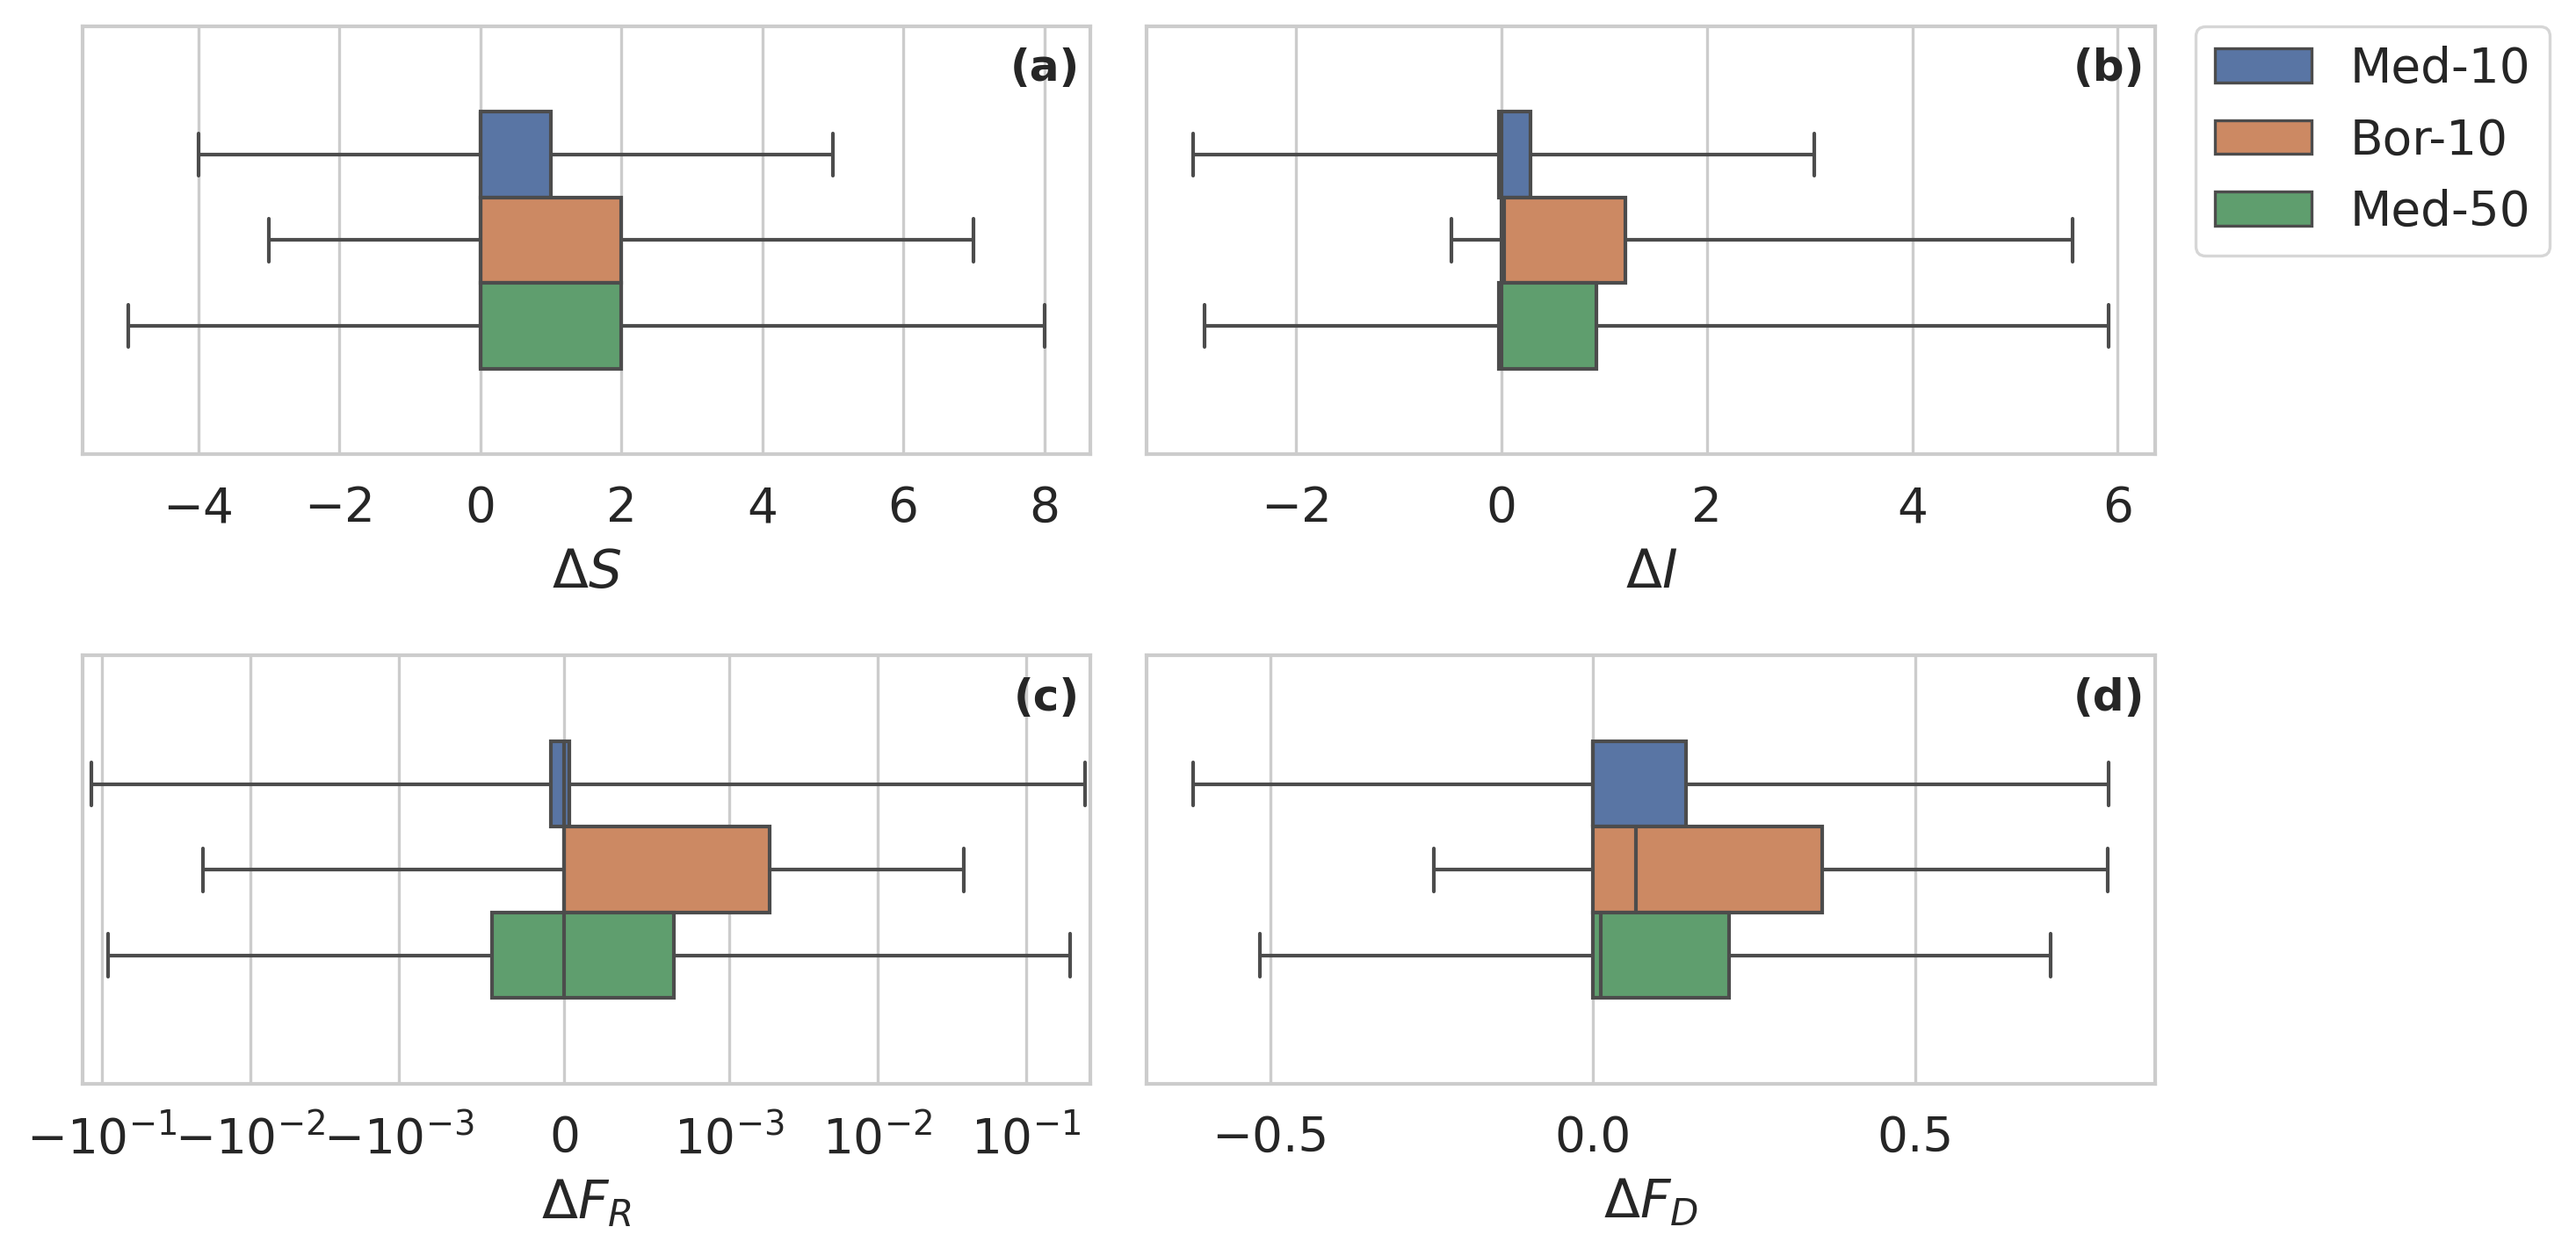

In [44]:
fig, ax2 = plt.subplots(2,2, figsize=(10,5), sharey=True, dpi=300)

data = df_diff

sns.boxplot(data=data, x="srichness", hue='eco-type', width=.6, whis=1000, ax=ax2[0,0], legend=False)
ax2[0,0].set_xlabel(r'$\Delta S$')
ax2[0,0].set_xticks(np.arange(-4, 9, 2))

sns.boxplot(data=data, x="isimpson", hue='eco-type', width=.6, whis=1000, ax=ax2[0,1])
ax2[0,1].set_xlabel(r'$\Delta I$')

sns.boxplot(data=data, x="frichness", hue='eco-type', width=.6, whis=3000, ax=ax2[1,0], legend=False)
# sns.boxplot(data=data, x="frichness", hue='eco-type', width=.6, ax=ax2[1,0], legend=False)
ax2[1,0].set_xlabel(r'$\Delta F_R$')
ax2[1,0].set_xscale('symlog', linthresh=0.001)
ax2[1,0].set_xticks([-0.1, -0.01, -0.001, 0.0, 0.001, 0.01, 0.1])

sns.boxplot(data=data, x="fdivergence", hue='eco-type', width=.6, whis=1000, ax=ax2[1,1], legend=False)
ax2[1,1].set_xlabel(r'$\Delta F_D$')

# Add identifying letters to each subplot, positioned at the top-right corner
letters = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate(ax2.flat):
    ax.text(0.99, 0.95, letters[i], transform=ax.transAxes, fontsize=12, fontweight='bold', 
            va='top', ha='right')

ax2[0,1].legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0)

plt.tight_layout()

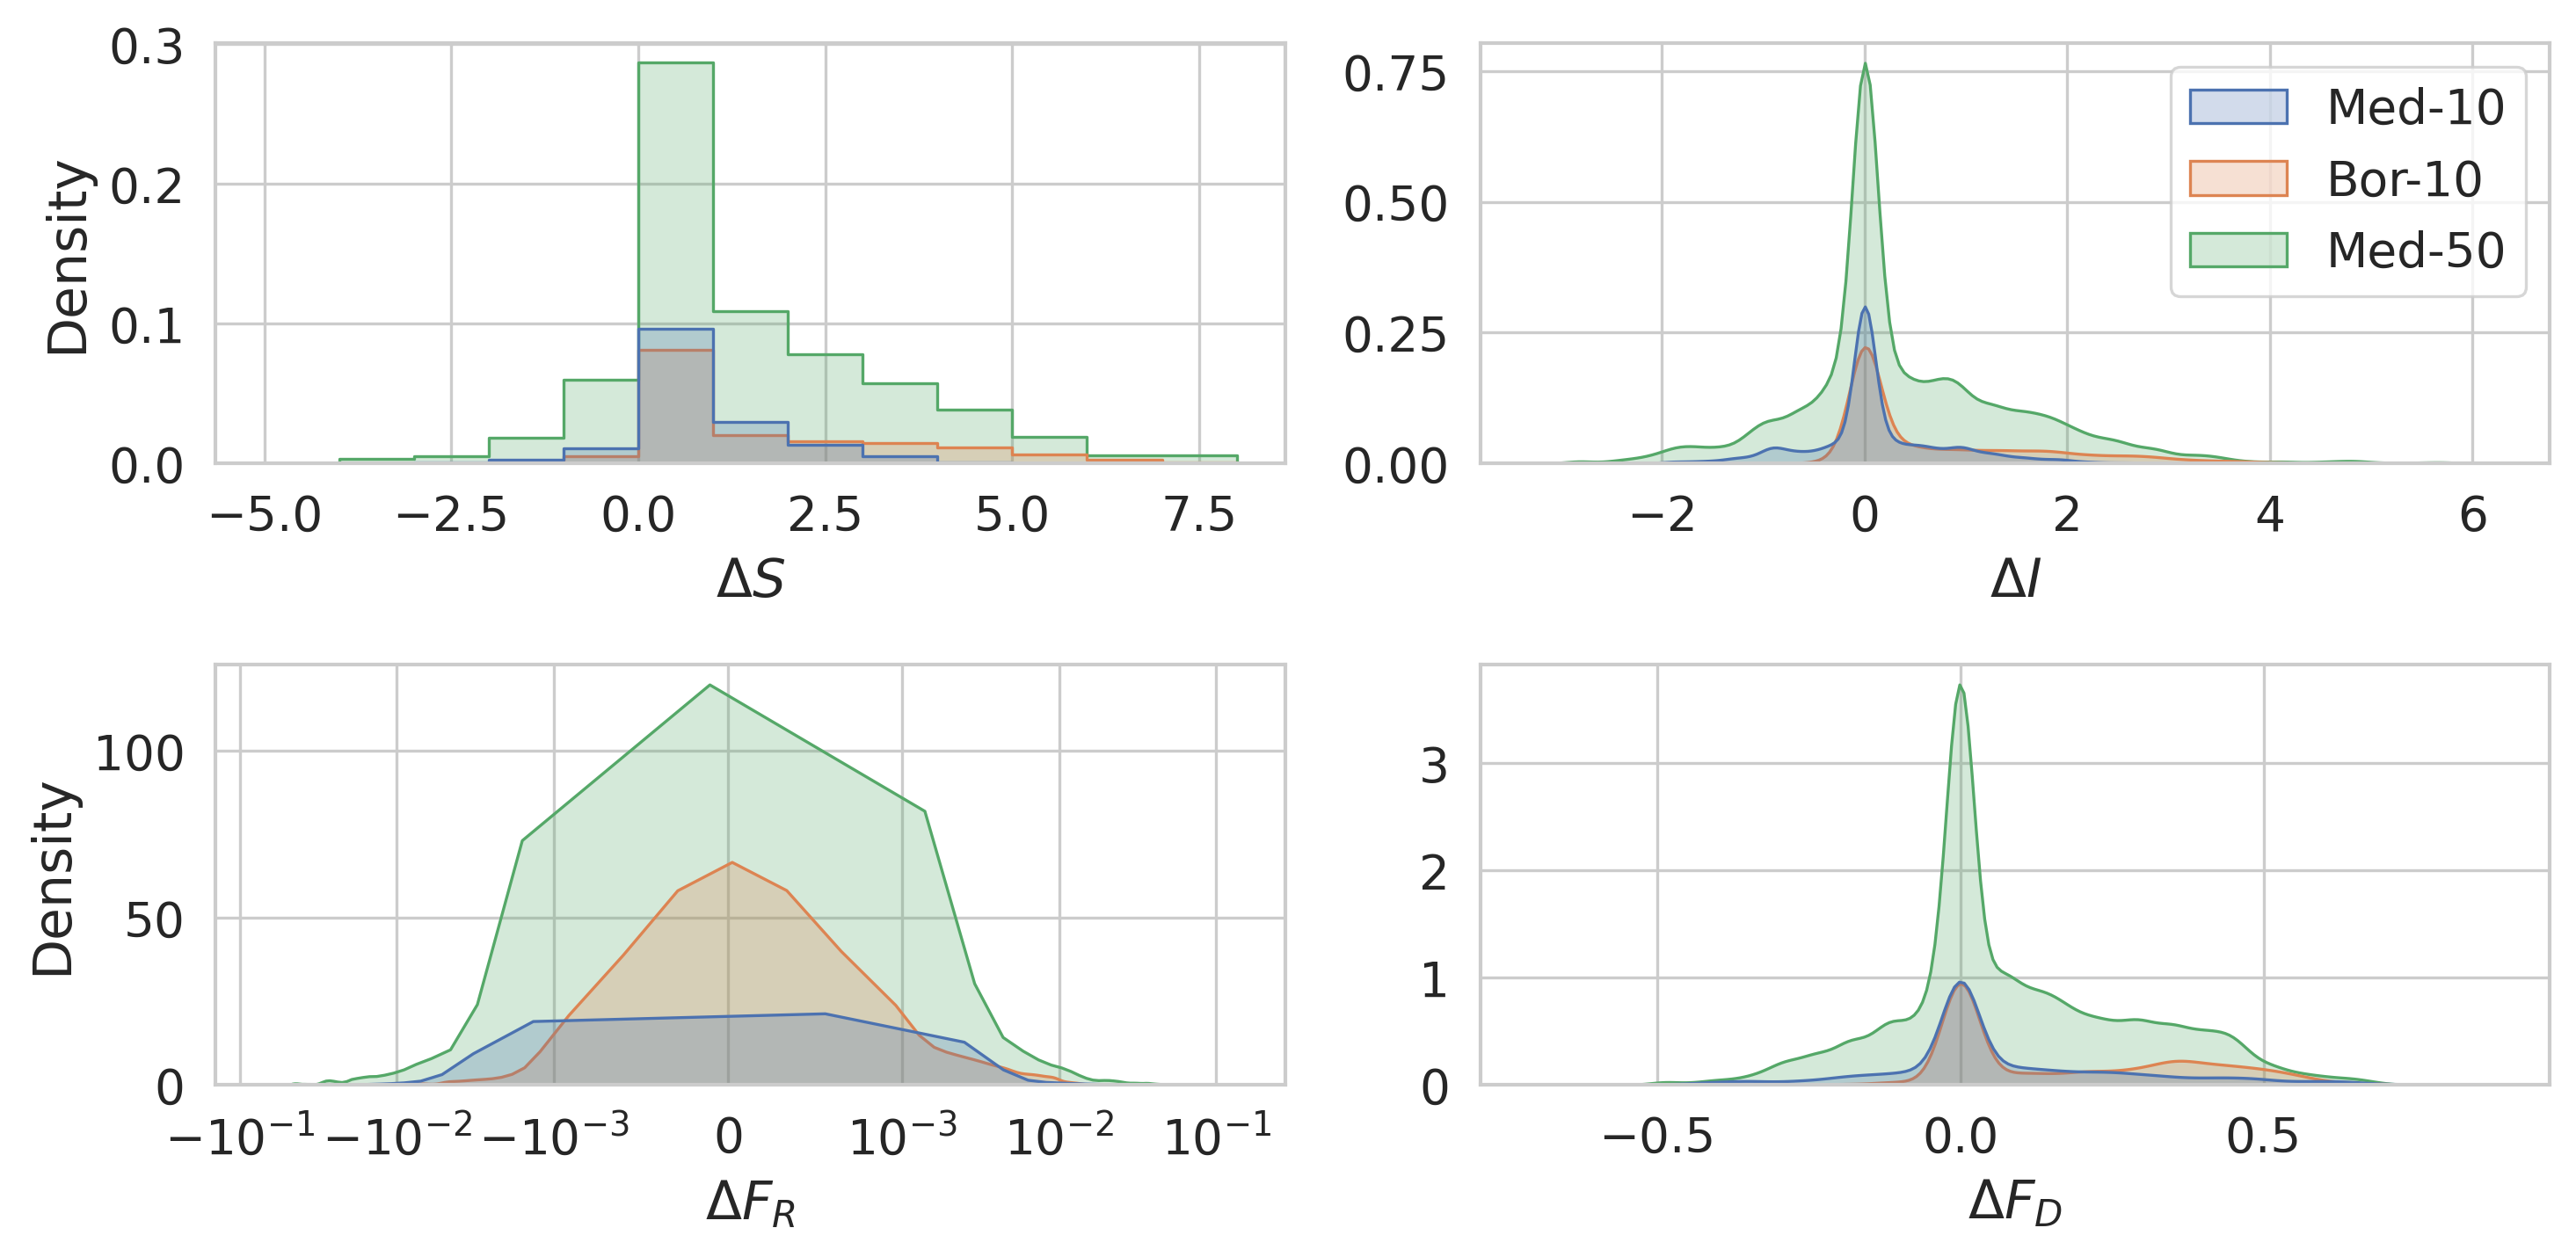

In [34]:
fig, ax2 = plt.subplots(2,2, figsize=(10,5), dpi=300)

data = df_diff

sns.histplot(data=data, x="srichness", hue='eco-type', stat='density', element="step", binwidth=1, shrink=1, ax=ax2[0,0], legend=False)
ax2[0,0].set_xlabel(r'$\Delta S$')

sns.kdeplot(data=data, x="isimpson", hue='eco-type', fill=True, ax=ax2[0,1])
ax2[0,1].set_xlabel(r'$\Delta I$')

sns.kdeplot(data=data, x="frichness", hue='eco-type', fill=True, ax=ax2[1,0], legend=False)
ax2[1,0].set_xlabel(r'$\Delta F_R$')
ax2[1,0].set_xscale('symlog', linthresh=0.001)
ax2[1,0].set_xticks([-0.1, -0.01, -0.001, 0.0, 0.001, 0.01, 0.1])

sns.kdeplot(data=data, x="fdivergence", hue='eco-type', fill=True, ax=ax2[1,1], legend=False)
ax2[1,1].set_xlabel(r'$\Delta F_D$')

for ax in ax2[:,1]:
    ax.set_ylabel("")
    # ax.label_outer()
    # ax.set_xlabel('')
    # ax.set_xticks([0, 1, 2])
    # ax.set_xticklabels(['Med-10', 'Med-50', 'Bor-10'])

ax2[0,1].get_legend().set_title("")
# sns.move_legend(ax2[0,1], "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

##### Wilcoxon signed-rank test
The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.

In [43]:
for bioind in ['srichness', 'isimpson', 'frichness', 'fdivergence']:

    print(bioind)
    for biome in ['Med-10', 'Med-50', 'Bor-10']:

        arrdat = df_diff[df_diff['eco-type']==biome][bioind].to_numpy()

        stat, pvalue = scs.wilcoxon(x=arrdat, alternative='greater', zero_method='wilcox')
        
        
        print(biome)
        print('statistic:', '{:.1f}'.format(stat), '\npvalue:', '{:.4f}'.format(pvalue), '\n')
    print('\n')

srichness
Med-10
statistic: 8970211.0 
pvalue: 0.0000 

Med-50
statistic: 390187918.5 
pvalue: 0.0000 

Bor-10
statistic: 16294107.5 
pvalue: 0.0000 



isimpson
Med-10
statistic: 16215515.0 
pvalue: 0.0000 

Med-50
statistic: 561875350.0 
pvalue: 0.0000 

Bor-10
statistic: 22148516.0 
pvalue: 0.0000 



frichness
Med-10
statistic: 13524061.0 
pvalue: 0.4317 

Med-50
statistic: 405584759.0 
pvalue: 0.0000 

Bor-10
statistic: 18738277.0 
pvalue: 0.0000 



fdivergence
Med-10
statistic: 19476154.0 
pvalue: 0.0000 

Med-50
statistic: 590953662.0 
pvalue: 0.0000 

Bor-10
statistic: 22419362.0 
pvalue: 0.0000 





#### Comparing the distribution

In [53]:
df_bp = pd.DataFrame(columns=['eco-type', 'dynamic', 'diversity', 'value'])

df = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df['eco-type'] = df['biome'] + df['N'].astype(str)
df['dynamic'] = 'Fires'

df2 = pd.read_csv(os.path.join(fpath_out, 'tilman-diversity.csv'))
df2['eco-type'] = df2['biome'] + df2['N'].astype(str)
df2['dynamic'] = 'Tilman'

df = pd.concat([df2, df])

divindex = ['srichness', 'isimpson', 'frichness', 'fdivergence']
for di in divindex:
    df1 = df[['eco-type','dynamic',di]]
    df1['diversity']=di
    df1 = df1.rename(columns={di:'value'})
    df_bp = pd.concat([df_bp, df1], ignore_index=True)

df_bp

/tmp/ipykernel_3301745/4103466341.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['diversity']=di
/tmp/ipykernel_3301745/4103466341.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['diversity']=di
/tmp/ipykernel_3301745/4103466341.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

eco-type dynamic    diversity     value
0         med10  Tilman    srichness         1
1         med10  Tilman    srichness         2
2         med10  Tilman    srichness         1
3         med10  Tilman    srichness         1
4         med10  Tilman    srichness         1
...         ...     ...          ...       ...
315995    med50   Fires  fdivergence  0.014152
315996    med50   Fires  fdivergence  0.021929
315997    med50   Fires  fdivergence  0.022717
315998    med50   Fires  fdivergence  0.010591
315999    med50   Fires  fdivergence  0.022729

[316000 rows x 4 columns]

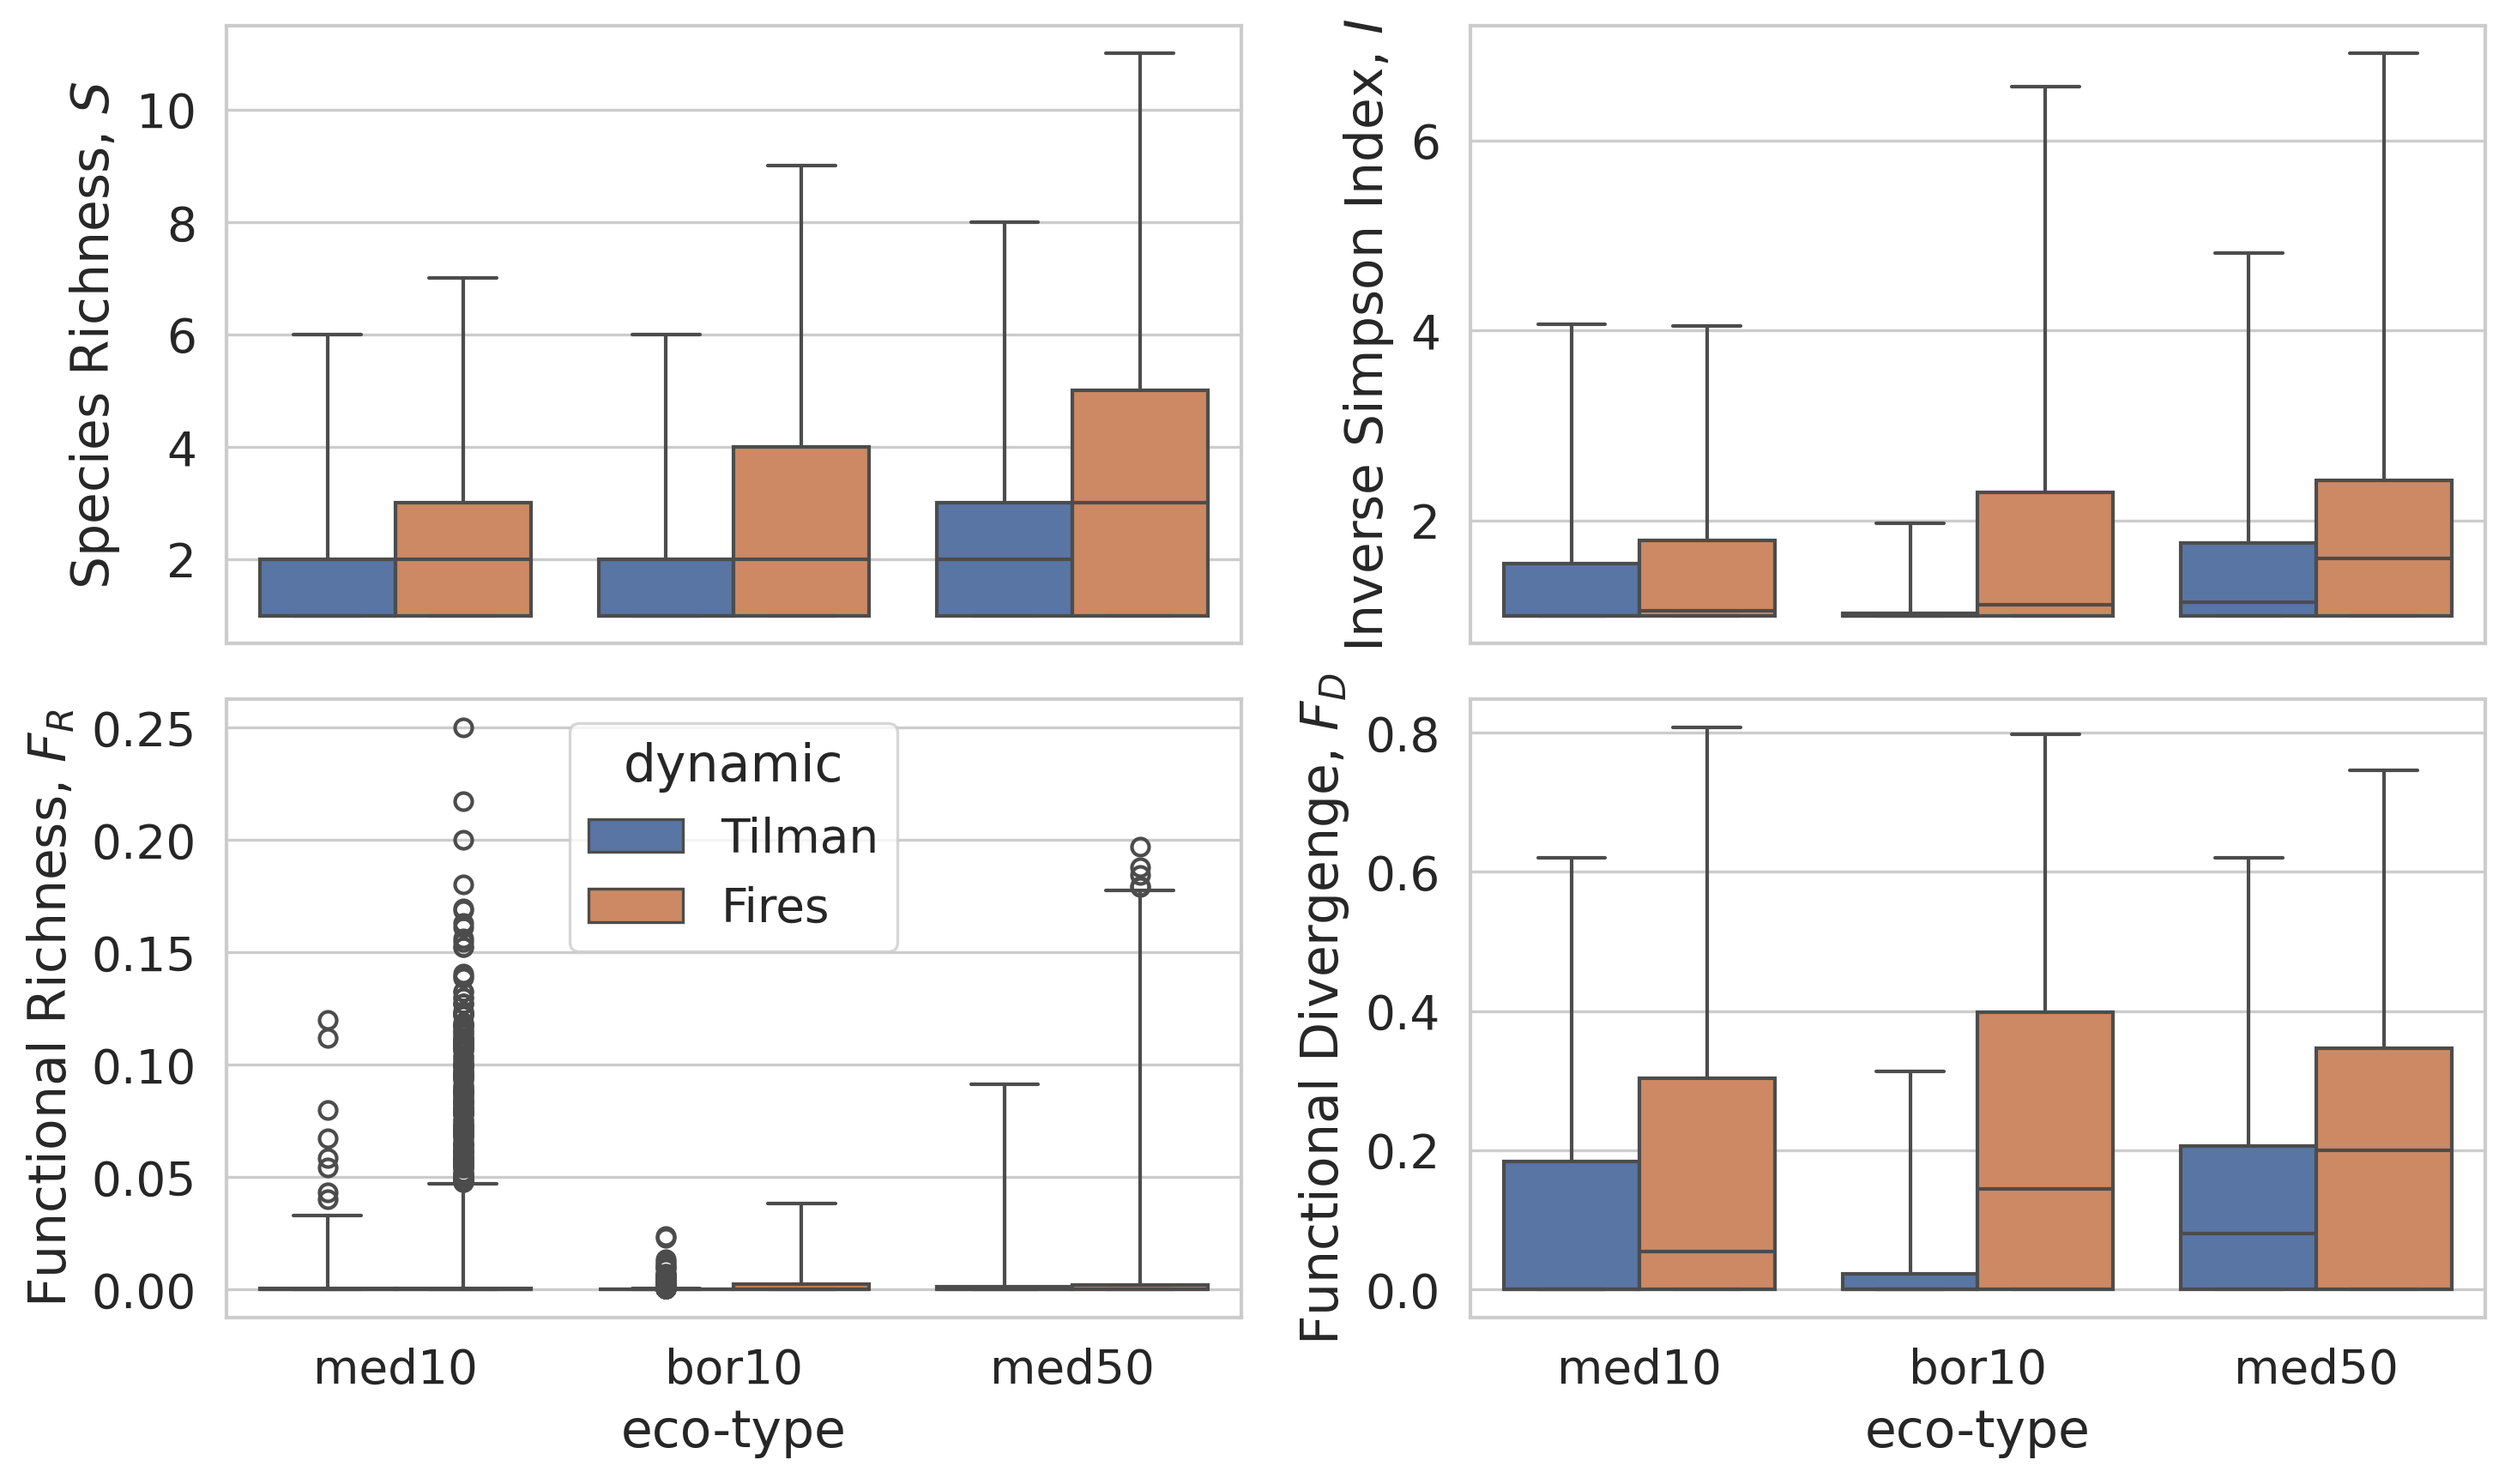

In [54]:
fig, ax2 = plt.subplots(2,2, figsize=(10,6), sharex=True, dpi=300)

data = df_bp[df_bp['diversity']=='srichness']
sns.boxplot(data=data, x="eco-type", y="value", hue="dynamic", whis=100, ax=ax2[0,0], legend=False)
ax2[0,0].set_ylabel(r'Species Richness, $S$')

data = df_bp[df_bp['diversity']=='isimpson']
sns.boxplot(data=data, x="eco-type", y="value", hue="dynamic", whis=100, ax=ax2[0,1], legend=False)
ax2[0,1].set_ylabel(r'Inverse Simpson Index, $I$')

data = df_bp[df_bp['diversity']=='frichness']
sns.boxplot(data=data, x="eco-type", y="value", hue="dynamic", whis=100, ax=ax2[1,0])
ax2[1,0].set_ylabel(r'Functional Richness, $F_R$')

data = df_bp[df_bp['diversity']=='fdivergence']
sns.boxplot(data=data, x="eco-type", y="value", hue="dynamic", whis=100, ax=ax2[1,1], legend=False)
ax2[1,1].set_ylabel(r'Functional Divergenge, $F_D$')

plt.tight_layout()

In [8]:
# fig, ax2 = plt.subplots(3,1, figsize=(6,9), sharex=True, sharey=True, dpi=300)

# data = df_bp[df_bp['eco-type']=='med10']
# sns.boxplot(data=data, x="diversity", y="value", hue="dynamic", ax=ax2[0])

# data = df_bp[df_bp['eco-type']=='med50']
# sns.boxplot(data=data, x="diversity", y="value", hue="dynamic", ax=ax2[1])

# data = df_bp[df_bp['eco-type']=='bor10']
# sns.boxplot(data=data, x="diversity", y="value", hue="dynamic", ax=ax2[2])

# plt.tight_layout()


**Species Richness with Tilman:** To confront with Miller et al. 2024

6 4.069834540970251
8 4.817894337537689
6 1.97365232964606


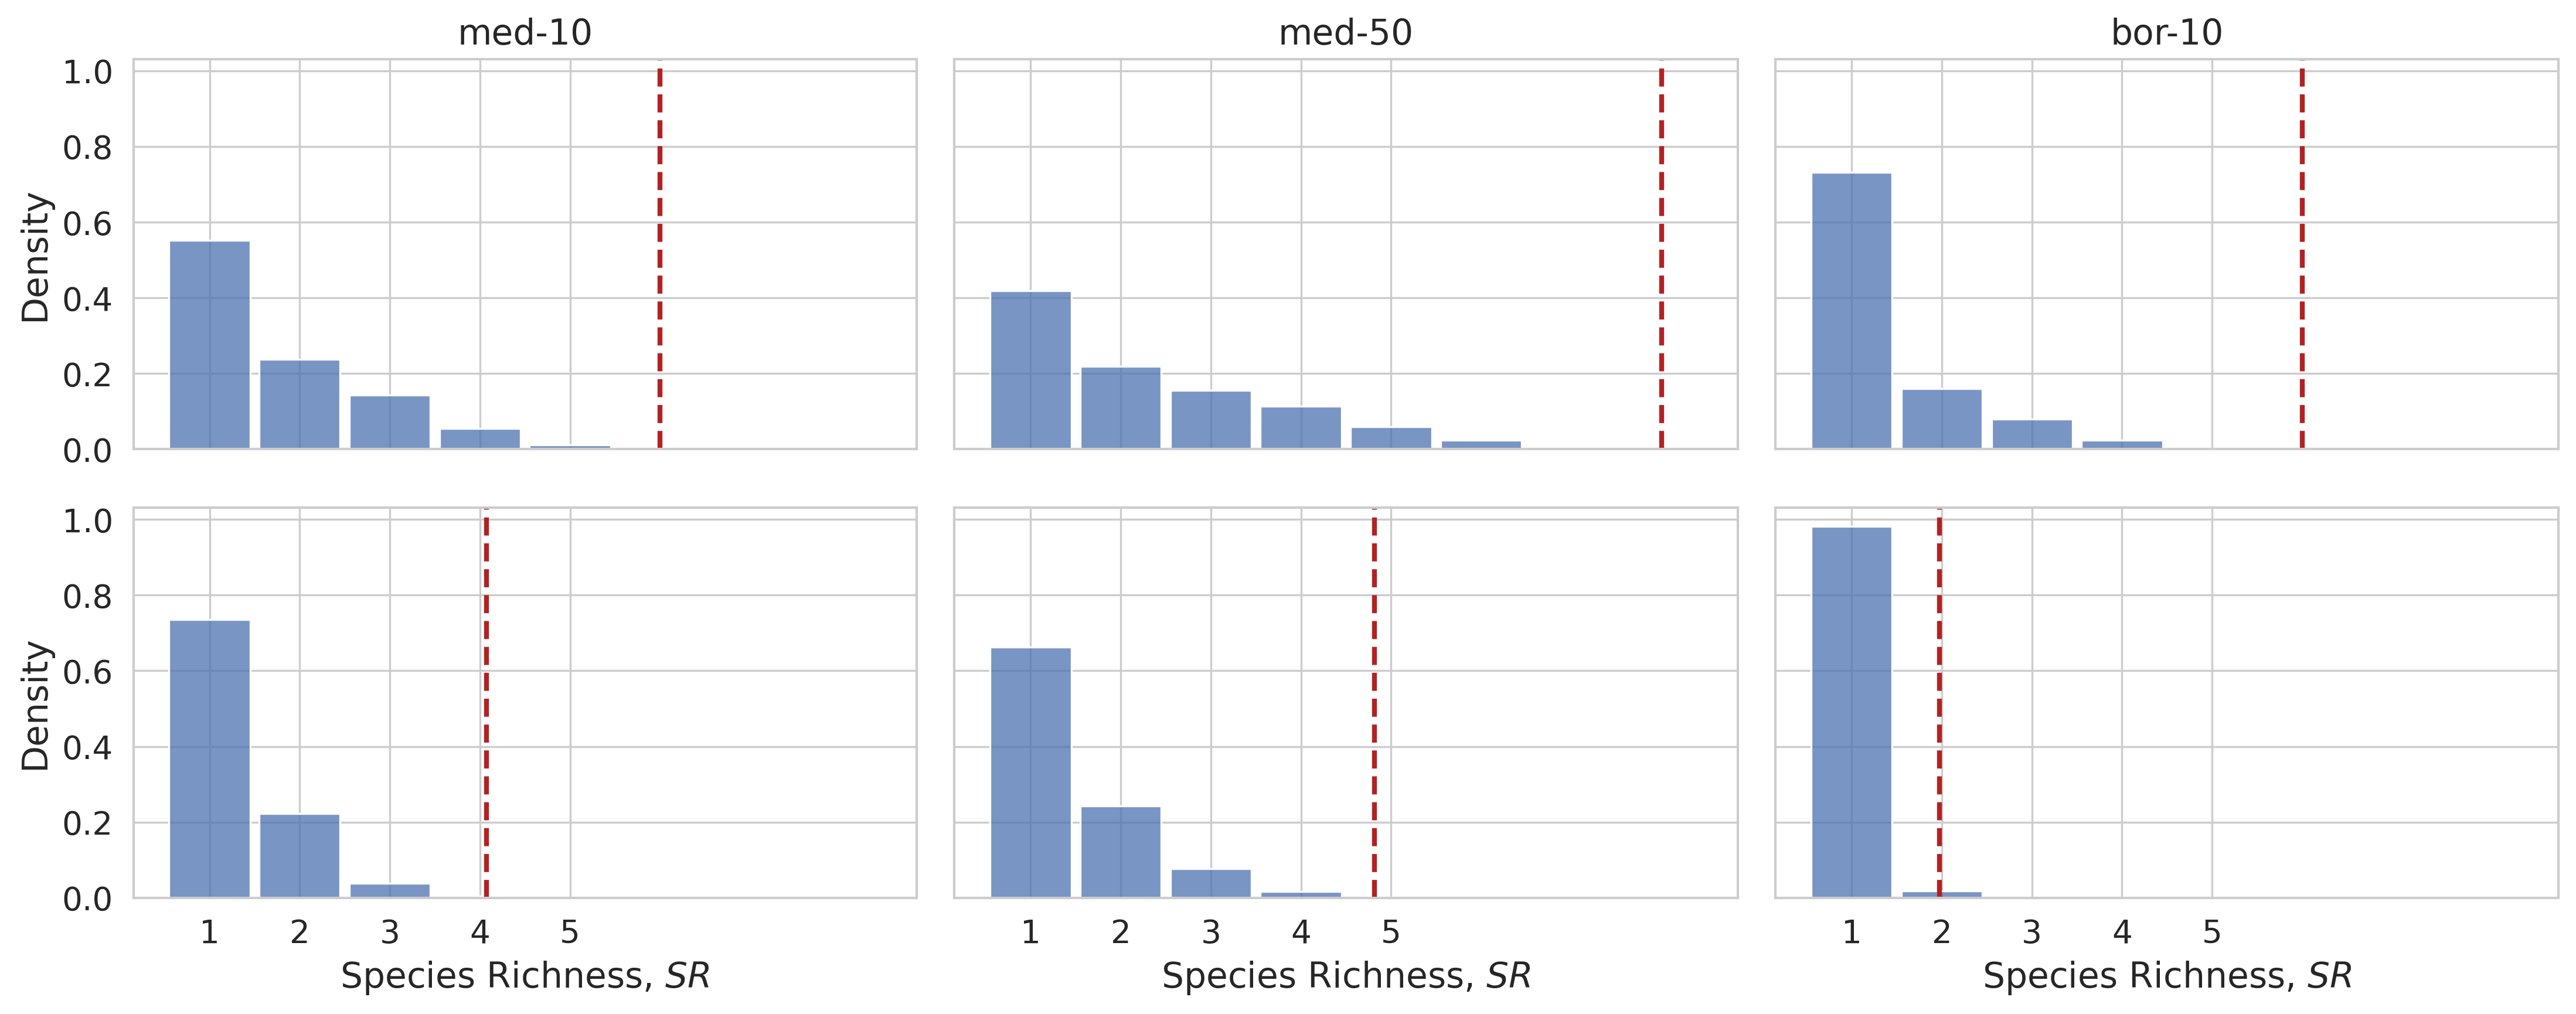

In [5]:
df2 = pd.read_csv(os.path.join(fpath_out, 'tilman-diversity.csv'))
sr_max = df2['srichness'].max()
isi_max = df2['isimpson'].max()

fig, ax2 = plt.subplots(2,3, figsize=(15,6), sharey=True, sharex=True, dpi=300)

n=10
biome='med'
data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
print(data['srichness'].max(), data['isimpson'].max())
sns.histplot(data=data, x="srichness", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[0,0])
ax2[0,0].axvline(x=data['srichness'].max(), color='firebrick', linestyle='--', label=r'$S_{max}$')
ax2[0,0].set_title(f'{biome}-{n}')

sns.histplot(data=data, x="isimpson", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[1,0])
ax2[1,0].axvline(x=data['isimpson'].max(), color='firebrick', linestyle='--', label=r'$S_{max}$')

n=50
biome='med'
data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
print(data['srichness'].max(), data['isimpson'].max())
sns.histplot(data=data, x="srichness", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[0,1])
ax2[0,1].axvline(x=data['srichness'].max(), color='firebrick', linestyle='--', label=r'$S_{max}$')
ax2[0,1].set_title(f'{biome}-{n}')

sns.histplot(data=data, x="isimpson", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[1,1])
ax2[1,1].axvline(x=data['isimpson'].max(), color='firebrick', linestyle='--', label=r'$S_{max}$')

n=10
biome='bor'
data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
print(data['srichness'].max(), data['isimpson'].max())
sns.histplot(data=data, x="srichness", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[0,2])
ax2[0,2].axvline(x=data['srichness'].max(), color='firebrick', linestyle='--', label=r'$S_{max}$')
ax2[0,2].set_title(f'{biome}-{n}')

sns.histplot(data=data, x="isimpson", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[1,2])
ax2[1,2].axvline(x=data['isimpson'].max(), color='firebrick', linestyle='--', label=r'$S_{max}$')


for ax in ax2[1]:
    ax.set_xlabel(r"Species Richness, $SR$")
    ax.set_xticks(np.arange(1,sr_max+1))

for ax in ax2[0]:
    ax.set_xlabel(r"Inverse Simpson Index, $SR$")
    ax.set_xticks(np.arange(1,isi_max+1))


plt.tight_layout()

6 4.069834540970251
8 4.817894337537689
6 1.97365232964606


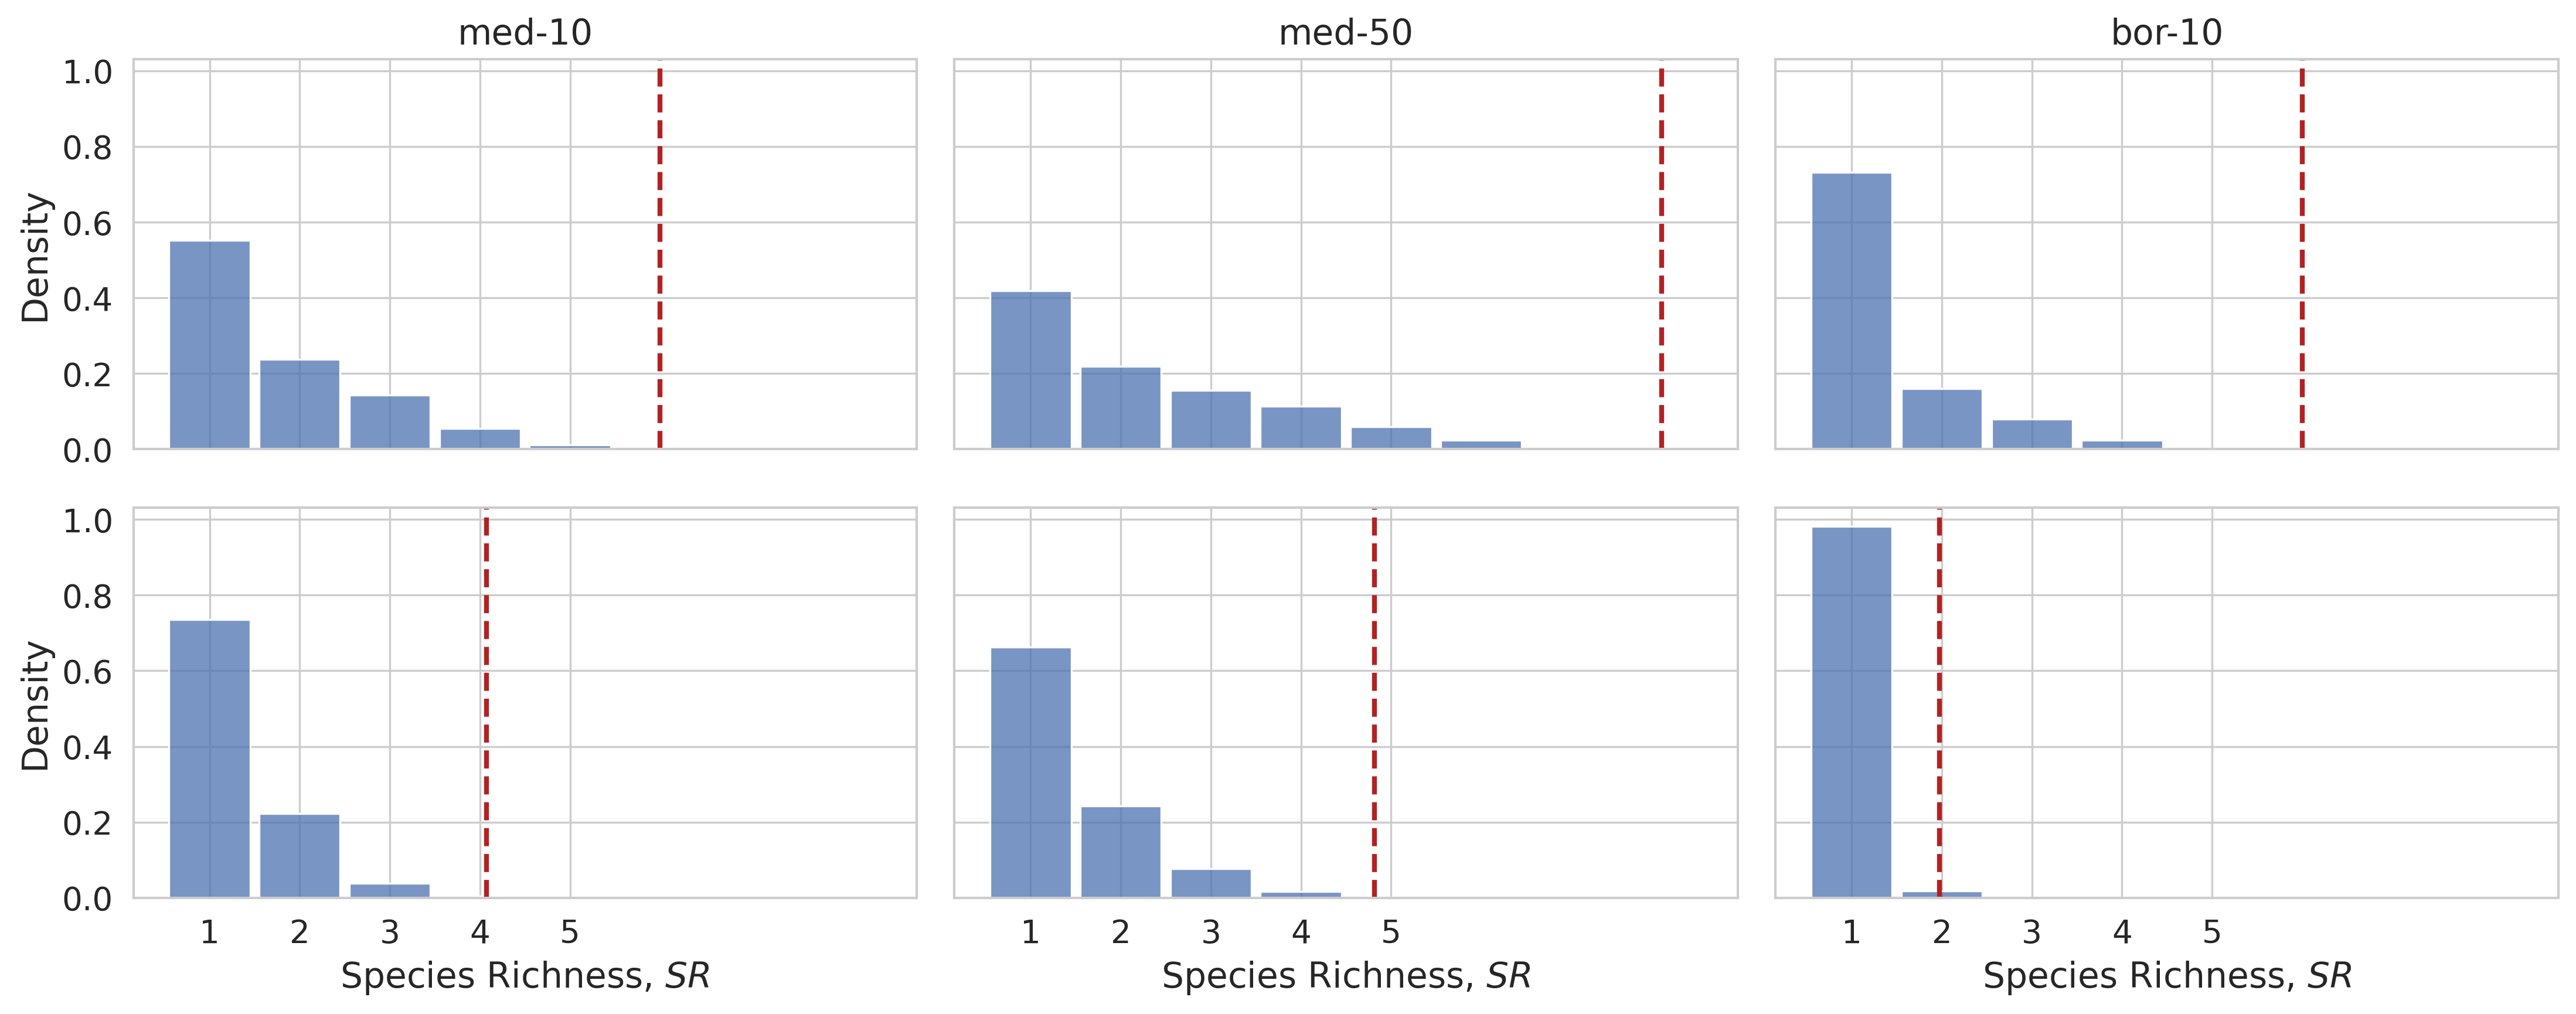

In [ ]:
df2 = pd.read_csv(os.path.join(fpath_out, 'tilman-diversity.csv'))
sr_max = df2['srichness'].max()
isi_max = df2['isimpson'].max()

fig, ax2 = plt.subplots(2,3, figsize=(15,6), sharey=True, sharex=True, dpi=300)

n=10
biome='med'
data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
print(data['srichness'].max(), data['isimpson'].max())
sns.histplot(data=data, x="srichness", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[0,0])
ax2[0,0].axvline(x=data['srichness'].max(), color='firebrick', linestyle='--', label=r'$S_{max}$')
ax2[0,0].set_title(f'{biome}-{n}')

sns.histplot(data=data, x="isimpson", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[1,0])
ax2[1,0].axvline(x=data['isimpson'].max(), color='firebrick', linestyle='--', label=r'$S_{max}$')

n=50
biome='med'
data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
print(data['srichness'].max(), data['isimpson'].max())
sns.histplot(data=data, x="srichness", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[0,1])
ax2[0,1].axvline(x=data['srichness'].max(), color='firebrick', linestyle='--', label=r'$S_{max}$')
ax2[0,1].set_title(f'{biome}-{n}')

sns.histplot(data=data, x="isimpson", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[1,1])
ax2[1,1].axvline(x=data['isimpson'].max(), color='firebrick', linestyle='--', label=r'$S_{max}$')

n=10
biome='bor'
data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
print(data['srichness'].max(), data['isimpson'].max())
sns.histplot(data=data, x="srichness", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[0,2])
ax2[0,2].axvline(x=data['srichness'].max(), color='firebrick', linestyle='--', label=r'$S_{max}$')
ax2[0,2].set_title(f'{biome}-{n}')

sns.histplot(data=data, x="isimpson", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[1,2])
ax2[1,2].axvline(x=data['isimpson'].max(), color='firebrick', linestyle='--', label=r'$S_{max}$')


for ax in ax2[1]:
    ax.set_xlabel(r"Species Richness, $SR$")
    ax.set_xticks(np.arange(1,sr_max+1))

for ax in ax2[0]:
    ax.set_xlabel(r"Inverse Simpson Index, $SR$")
    ax.set_xticks(np.arange(1,isi_max+1))


plt.tight_layout()

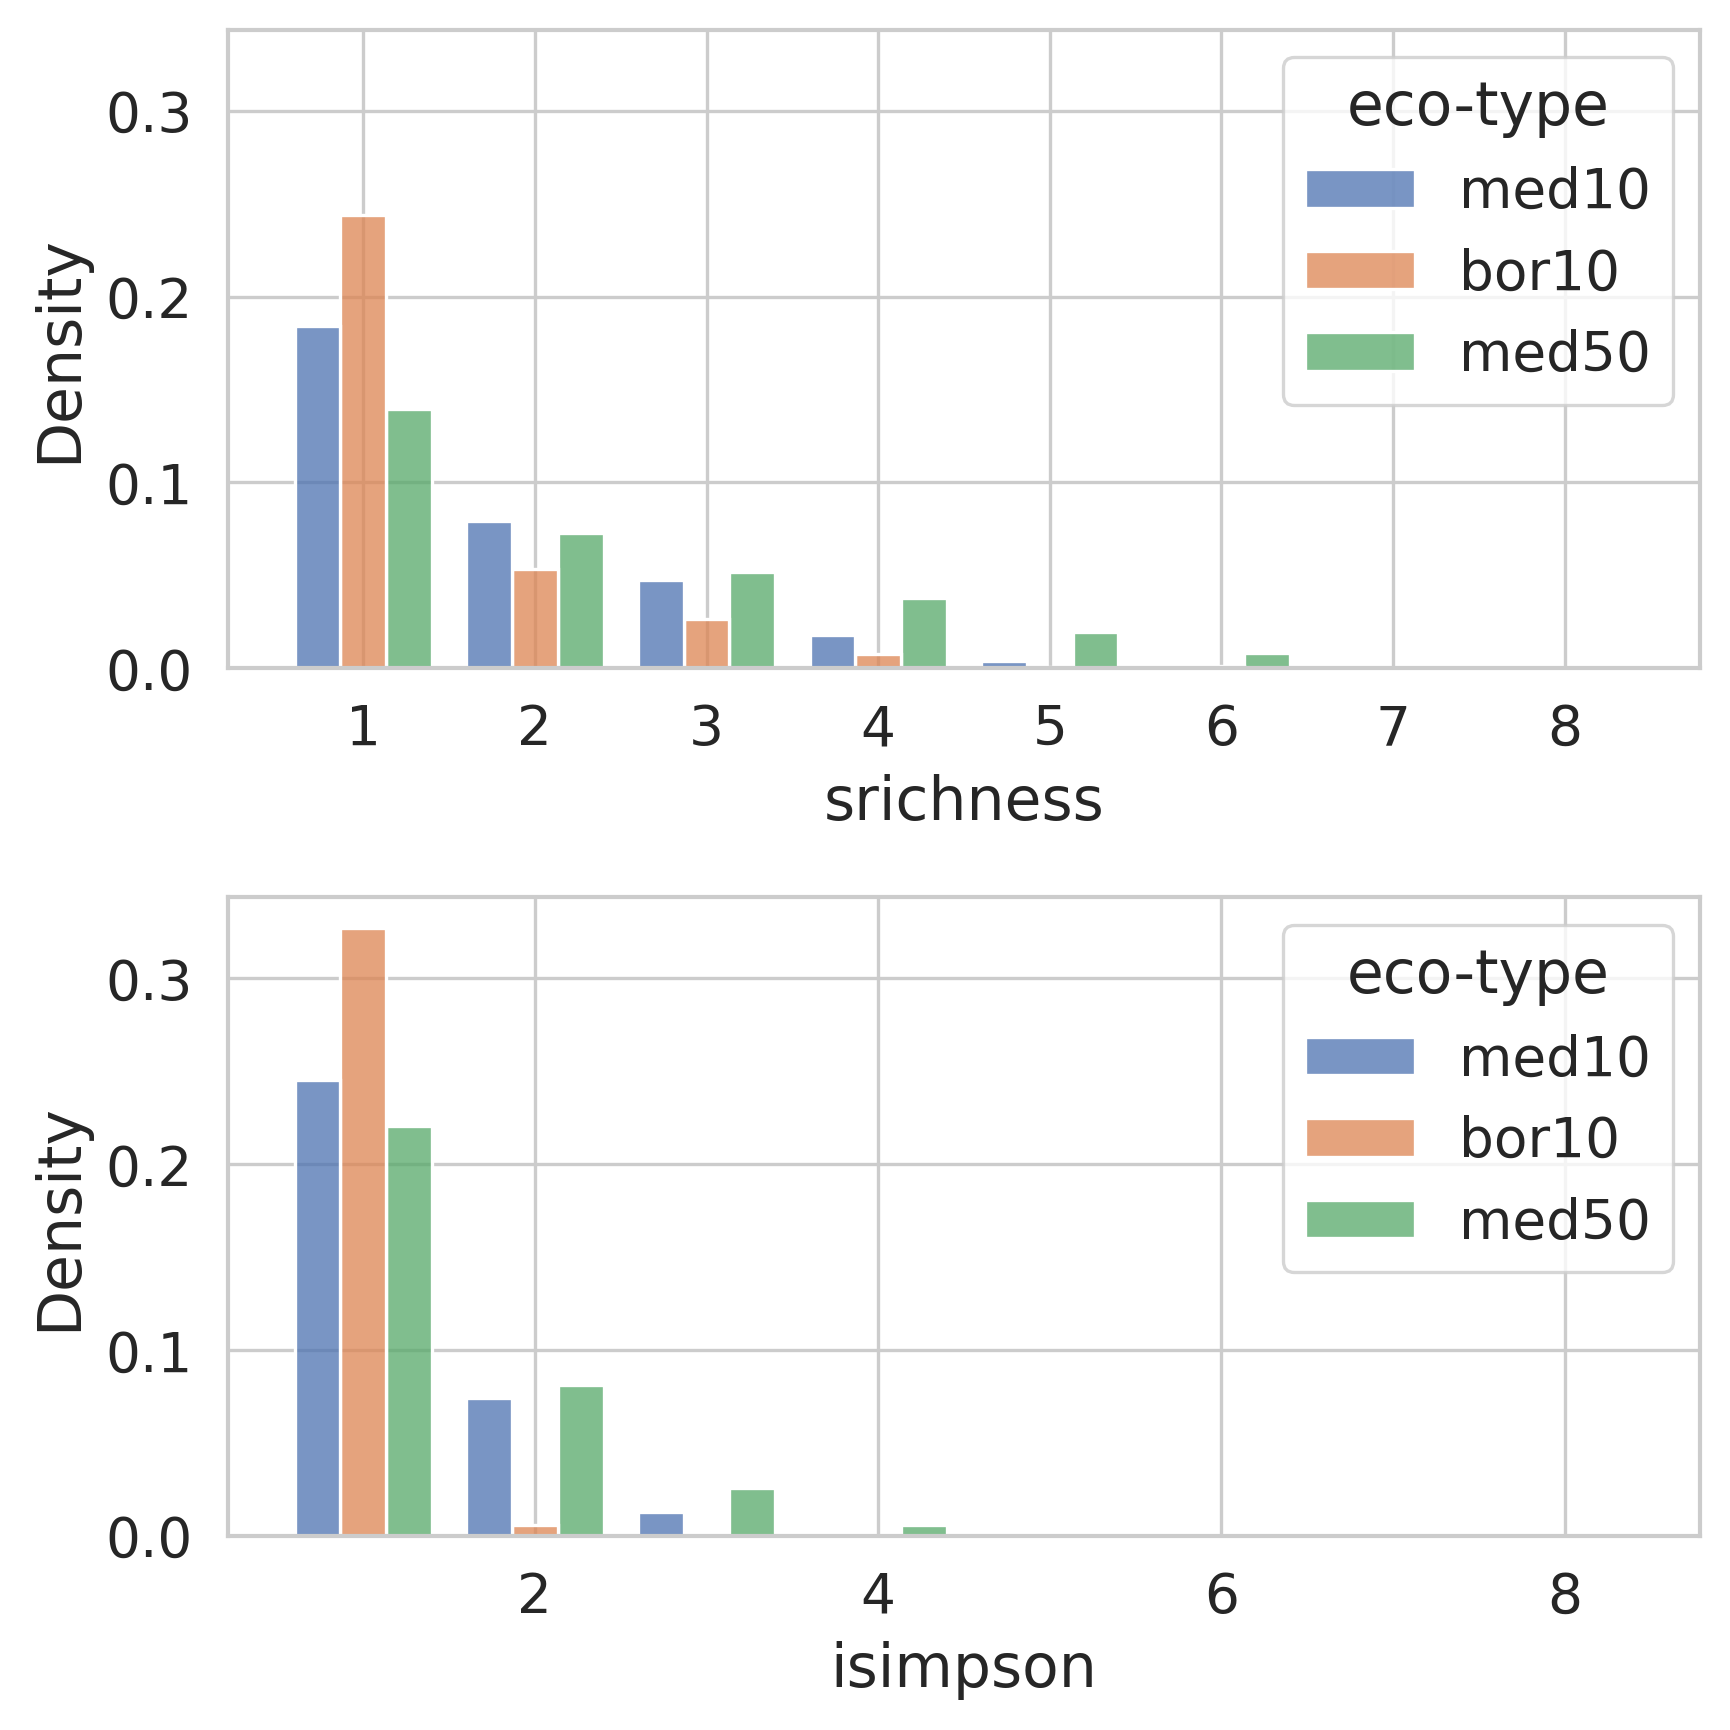

In [77]:
df2 = pd.read_csv(os.path.join(fpath_out, 'tilman-diversity.csv'))
df2['eco-type'] = df2['biome'] + df2['N'].astype(str)
sr_max = df2['srichness'].max()
isi_max = df2['isimpson'].max()

fig, ax2 = plt.subplots(2,1, figsize=(6,6), sharey=True, sharex=False,dpi=300)

sns.histplot(data=df2, x="srichness", hue='eco-type', stat='density', multiple="dodge", shrink=.8, binrange=(0.5,sr_max+0.5), binwidth=1, ax=ax2[0])
# sns.histplot(data=df2, x="srichness", hue='eco-type', stat='density', element="step", shrink=.8, binrange=(0.5,sr_max+0.5), binwidth=1, ax=ax2[0])

sns.histplot(data=df2, x="isimpson", hue='eco-type', stat='density', multiple="dodge", shrink=.8, binrange=(0.5,sr_max+0.5), binwidth=1, ax=ax2[1])
# sns.histplot(data=df2, x="isimpson", hue='eco-type', stat='density', element="step", shrink=.8, binrange=(0.5,sr_max+0.5), binwidth=1, ax=ax2[1])


# n=10
# biome='med'
# data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
# print(data['srichness'].max(), data['isimpson'].max())
# sns.histplot(data=data, x="srichness", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[0,0])
# ax2[0,0].axvline(x=data['srichness'].max(), color='firebrick', linestyle='--', label=r'$SR_{max}$')
# ax2[0,0].set_title(f'{biome}-{n}')

# sns.histplot(data=data, x="isimpson", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[1,0])
# ax2[1,0].axvline(x=data['isimpson'].max(), color='firebrick', linestyle='--', label=r'$SR_{max}$')

# n=50
# biome='med'
# data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
# print(data['srichness'].max(), data['isimpson'].max())
# sns.histplot(data=data, x="srichness", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[0,1])
# ax2[0,1].axvline(x=data['srichness'].max(), color='firebrick', linestyle='--', label=r'$SR_{max}$')
# ax2[0,1].set_title(f'{biome}-{n}')

# sns.histplot(data=data, x="isimpson", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[1,1])
# ax2[1,1].axvline(x=data['isimpson'].max(), color='firebrick', linestyle='--', label=r'$SR_{max}$')

# n=10
# biome='bor'
# data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
# print(data['srichness'].max(), data['isimpson'].max())
# sns.histplot(data=data, x="srichness", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[0,2])
# ax2[0,2].axvline(x=data['srichness'].max(), color='firebrick', linestyle='--', label=r'$SR_{max}$')
# ax2[0,2].set_title(f'{biome}-{n}')

# sns.histplot(data=data, x="isimpson", stat='density', binrange=(0.5,sr_max+0.5), binwidth=1, shrink=0.9, ax=ax2[1,2])
# ax2[1,2].axvline(x=data['isimpson'].max(), color='firebrick', linestyle='--', label=r'$SR_{max}$')

ax2[0].set_xticks(np.arange(1,sr_max+1))
# for ax in ax2[0]:
#     ax.set_xlabel(r"Species Richness, $SR$")
#     ax

# for ax in ax2[1]:
#     ax.set_xlabel(r"Inverse Simpson Index, $SR$")
#     ax.set_xticks(np.arange(1,isi_max+1))


plt.tight_layout()

###  Quantile Regression
Quantile Regression libraries and functions

In [35]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

max_iter = 350000

In [36]:
def wald_test(model):

# Get the coefficients (excluding intercept)
    beta = model.params[1:]  # Coefficients for X and X_squared

    # Get the covariance matrix of the estimated coefficients
    cov_matrix = model.cov_params().iloc[1:, 1:]  # Covariance for X and X_squared

    # Wald statistic calculation: W = beta' * (cov^-1) * beta
    wald_stat = np.dot(np.dot(beta.T, np.linalg.inv(cov_matrix)), beta)

    # Degrees of freedom is the number of coefficients (excluding the intercept)
    df = len(beta)

    # Compute p-value based on chi-squared distribution
    p_value = scs.chi2.sf(wald_stat, df)

    # print(f"Wald Test Statistic: {wald_stat:.4f}")
    # print(f"p-value: {p_value:.4f}")

    return wald_stat, p_value

In [37]:
def aic_test(Y, X, Y_pr, model):
    # return aic metric
    k_params = model.df_model + model.k_constant
    
    # Estimate maximized log likelihood
    nobs = float(X.shape[0])
    nobs2 = nobs / 2.0
    nobs = float(nobs)
    resid = Y - Y_pr
    ssr = np.sum((resid)**2)
    llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2

    return -2 * llf + 2 * k_params

In [38]:
def best_poly_quantile_regression(Y, X, quantile=0.5, max_degree=5, verbose=True):
    best_degree = None
    best_aic = np.inf  # Initialize to a large value
    best_model = None

    # Data preparation
    data = pd.DataFrame({'X': X, 'Y': Y})

    # Iterate over polynomial degrees from 1 to max_degree
    for degree in range(1, max_degree + 1):
        # Construct formula for polynomial regression up to the current degree
        formula = 'Y ~ ' + ' + '.join([f'np.power(X, {i})' for i in range(1, degree + 1)])

        # Fit quantile regression for the current degree
        model = smf.quantreg(formula, data).fit(q=quantile, max_iter=max_iter)
        
        # Predict the values for Y
        Y_pr = model.predict(data)
        
        # Calculate AIC for the current model
        aic_value = aic_test(data['Y'], data['X'], Y_pr, model)
        
        # print(f'Degree {degree}: AIC = {aic_value:.4f}')

        w_stat, w_pval = wald_test(model)
        # keep only the statistically significant regression
        if w_pval < 0.05:
            # Update the best model if current AIC is smaller
            if aic_value < best_aic:
                best_aic = aic_value
                best_degree = degree
                best_model = model

    if verbose:
        print(f'Best Polynomial Degree: {best_degree} with AIC = {best_aic:.4f}\n')
    return best_degree, best_model, best_aic

#### Qreg Tables

In [ ]:
df_qreg = pd.DataFrame(index=['poly order', 'quantile', 'AIC', 'R-squared', 'Wald test', 'p-value']).T

df2 = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex.csv'))
df2['frt']=np.log10(df2['frt'])

n = 50
biome= 'med'
bioind = 'srichness'

data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
data = data.rename(columns={'frt':'X', bioind:'Y'})

data['X_2']=data['X']**2
data['X_3']=data['X']**3
data['X_4']=data['X']**4
data['X_5']=data['X']**5

for q in np.arange(0.75, 1.0, 0.1):
    for poly in range(1,6):

        if poly==1:
            model = smf.quantreg('Y ~ I(X)', data)
            X = data['X']
        elif poly==2:
            model = smf.quantreg('Y ~ I(X) + I(X**2)', data)
            X = data[['X', 'X_2']]
        elif poly==3:
            model = smf.quantreg('Y ~ I(X) + I(X**2) + I(X**3)', data)
            X = data[['X', 'X_2', 'X_3']]
        elif poly==4:
            model = smf.quantreg('Y ~ I(X) + I(X**2) + I(X**3) + I(X**4)', data)
            X = data[['X', 'X_2', 'X_3', 'X_4']]
        elif poly==5:
            model = smf.quantreg('Y ~ I(X) + I(X**2) + I(X**3) + I(X**4) + I(X**5)', data)
            X = data[['X', 'X_2', 'X_3', 'X_4', 'X_5']]
        else:
            print('Error')

        X = sm.add_constant(X)
        lr = model.fit(q=q)
        pr = lr.predict(X)

        AIC = aic_test(data['Y'], data['X'], pr, model)
        Rsq = lr.prsquared
        w_stat, w_pval = wald_test(lr)
        
        df_temp = pd.DataFrame([int(poly), round(q,2), round(AIC,4), round(Rsq,4), round(w_stat,4), round(w_pval,4)], index=['poly order', 'quantile', 'AIC', 'R-squared', 'Wald test', 'p-value'])
        df_qreg = pd.concat([df_qreg, df_temp.T], axis=0)

caption=f'Quantile regression statistics of the {bioind} and fire return time relationship for the $N={n}$ {biome} simulations, across quantiles ($75th$, $85t$ and $95th$) and polynomial orders (1 to 5). The table includes the Akaike Information Criterion (AIC), pseudo R-squared, Wald test statistic, and p-value. (*) indicates the best polynomial order for each quantile.'

df_qreg = df_qreg.set_index("quantile")
df_qreg

In [40]:
df_qreg = df_qreg.reset_index()

In [41]:
from functools import partial
def use_f_2(x, num_decimals):
    return f"%.{num_decimals}f" % x

# the number of columns can be passed to this function
use_f = lambda x: partial(use_f_2, num_decimals=x)

In [ ]:
latex_table = df_qreg.reset_index().to_latex(
    index=False,
    formatters = [use_f(2), use_f(0), use_f(1), use_f(3), use_f(1), use_f(1)],
    # float_format="%.3f",
    caption=caption,
    label=f"tab:qreg_{bioind[:5]}_{biome}{n}",
    escape=False,
    column_format="ll|cccc",
    position='h!',
    multirow = True

)

# Post-process the LaTeX table to match the desired format
formatted_table = latex_table.replace("\\begin{table}", "\\begin{table}[h!]"
                            ).replace("\\bottomrule\n", ""
                            ).replace("{rrrrr}", "{ll|cccc}")

# Add additional custom rows and multirow format
formatted_table = formatted_table.replace(
    "\\toprule",
    "\\multirow{2}{*}{\\textbf{Quantile}} & \\textbf{Polynomial} & \\multirow{2}{*}{\\textbf{AIC}} & \\multirow{2}{*}{\\textbf{R-squared}} & \\multicolumn{2}{c}{\\textbf{Wald test}} \\"
).replace(
    "quantile & poly order & AIC & R-squared & Wald test & p-value \\",
    "& \\textbf{Order} &  &  & \\textbf{Statistics} & \\textbf{p-value} \\")

# Add additional custom rows and multirow format
formatted_table = formatted_table.replace("0.75 & 1","\\multirow{5}{*}{0.75} & 1").replace("0.75 & 2"," & 2").replace("0.75 & 3"," & 3").replace("0.75 & 4"," & 4").replace("0.75 & 5"," & 5"
                                ).replace("0.85 & 1","\\midrule\n\\multirow{5}{*}{0.85} & 1").replace("0.85 & 2"," & 2").replace("0.85 & 3"," & 3").replace("0.85 & 4"," & 4").replace("0.85 & 5"," & 5"
                                ).replace("0.95 & 1","\\midrule\n\\multirow{5}{*}{0.95} & 1").replace("0.95 & 2"," & 2").replace("0.95 & 3"," & 3").replace("0.95 & 4"," & 4").replace("0.95 & 5"," & 5")

print(formatted_table)

### Diversity - Disturbance

In [61]:
# Common parameters for the plots
sz = 10
al = 0.3

frt_max = 1800
frt_min = 4

colorq = ['crimson','gold','cornflowerblue'] #['purple', 'darkorange', 'forestgreen']
quantiles = [.75, .85, .95]

In [58]:
df2 = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))

In [59]:
df2[df2['frt']==df2['frt'].max()]

Unnamed: 0 biome   N  ncom  init          frt  srichness  isimpson  \
18961       18961   bor  10   581     2  1700.034247          1       1.0   

       frichness  fdivergence  
18961        0.0          0.0

In [60]:
df2[df2['frt']==df2['frt'].min()]

Unnamed: 0 biome   N  ncom  init       frt  srichness  isimpson  \
6782        6782   med  10   566     3  4.410279          1       1.0   

      frichness  fdivergence  
6782        0.0          0.0

#### Compositional Diversity ($S$, $I$) with Quantile Regression

In [154]:
def plot_qreg_cdiv(df, ax2, i, n, biome, quantiles=[.75, .85, .95], colorq=['purple', 'darkorange', 'forestgreen'], orientation='v', verbose=True):

    if orientation=='v':
        ax2[1,0].set_ylabel("Species Richness, $S$")
        ax2[1,1].set_ylabel("Inverse Simpson Index, $I$")
    elif orientation=='o':
        ax2[0,0].set_ylabel("Species Richness, $S$")
        ax2[1,0].set_ylabel("Inverse Simpson Index, $I$")

    if verbose:
        print(f'n={n}, {biome}')

    if np.any(df):

        data = df[(df['N'] == n) & (df['biome'] == biome)]

        if orientation=='v':
            ax2[i,0].scatter('frt', 'srichness', data=data, s=sz, alpha=al, c='grey', label='')
            ax2[i,1].scatter('frt', 'isimpson', data=data, s=sz, alpha=al, c='grey', label='')
            
        elif orientation=='o':
            ax2[0,i].scatter('frt', 'srichness', data=data, s=sz, alpha=al, c='grey', label='')
            ax2[1,i].scatter('frt', 'isimpson', data=data, s=sz, alpha=al, c='grey', label='')



        # QUANTILE REGRESSION

        x_p = np.linspace(data.frt.min(), data.frt.max(), 100)

        for q,cq in zip(quantiles,colorq):
            if verbose:
                print(f'Quantile={q}')
            X = data['frt']
            Y = data['srichness']
            best_degree, best_model, best_aic = best_poly_quantile_regression(Y, X, quantile=q, max_degree=5, verbose=verbose)
            df_pred = pd.DataFrame({'X': x_p})
            # Add the necessary polynomial terms up to the best degree found
            for degree in range(2, best_degree + 1):
                df_pred[f'np.power(X, {degree})'] = np.power(df_pred['X'], degree)

            if orientation=='v':
                ax2[i,0].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))
            elif orientation=='o':
                ax2[0,i].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))

            if verbose:
                print('Inverse Simpson Index')
            Y = data['isimpson']
            best_degree, best_model, best_aic = best_poly_quantile_regression(Y, X, quantile=q, max_degree=5, verbose=verbose)
            df_pred = pd.DataFrame({'X': x_p})
            # Add the necessary polynomial terms up to the best degree found
            for degree in range(2, best_degree + 1):
                df_pred[f'np.power(X, {degree})'] = np.power(df_pred['X'], degree)
            
            if orientation=='v':
                ax2[i,1].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))
            elif orientation=='o':
                ax2[1,i].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))


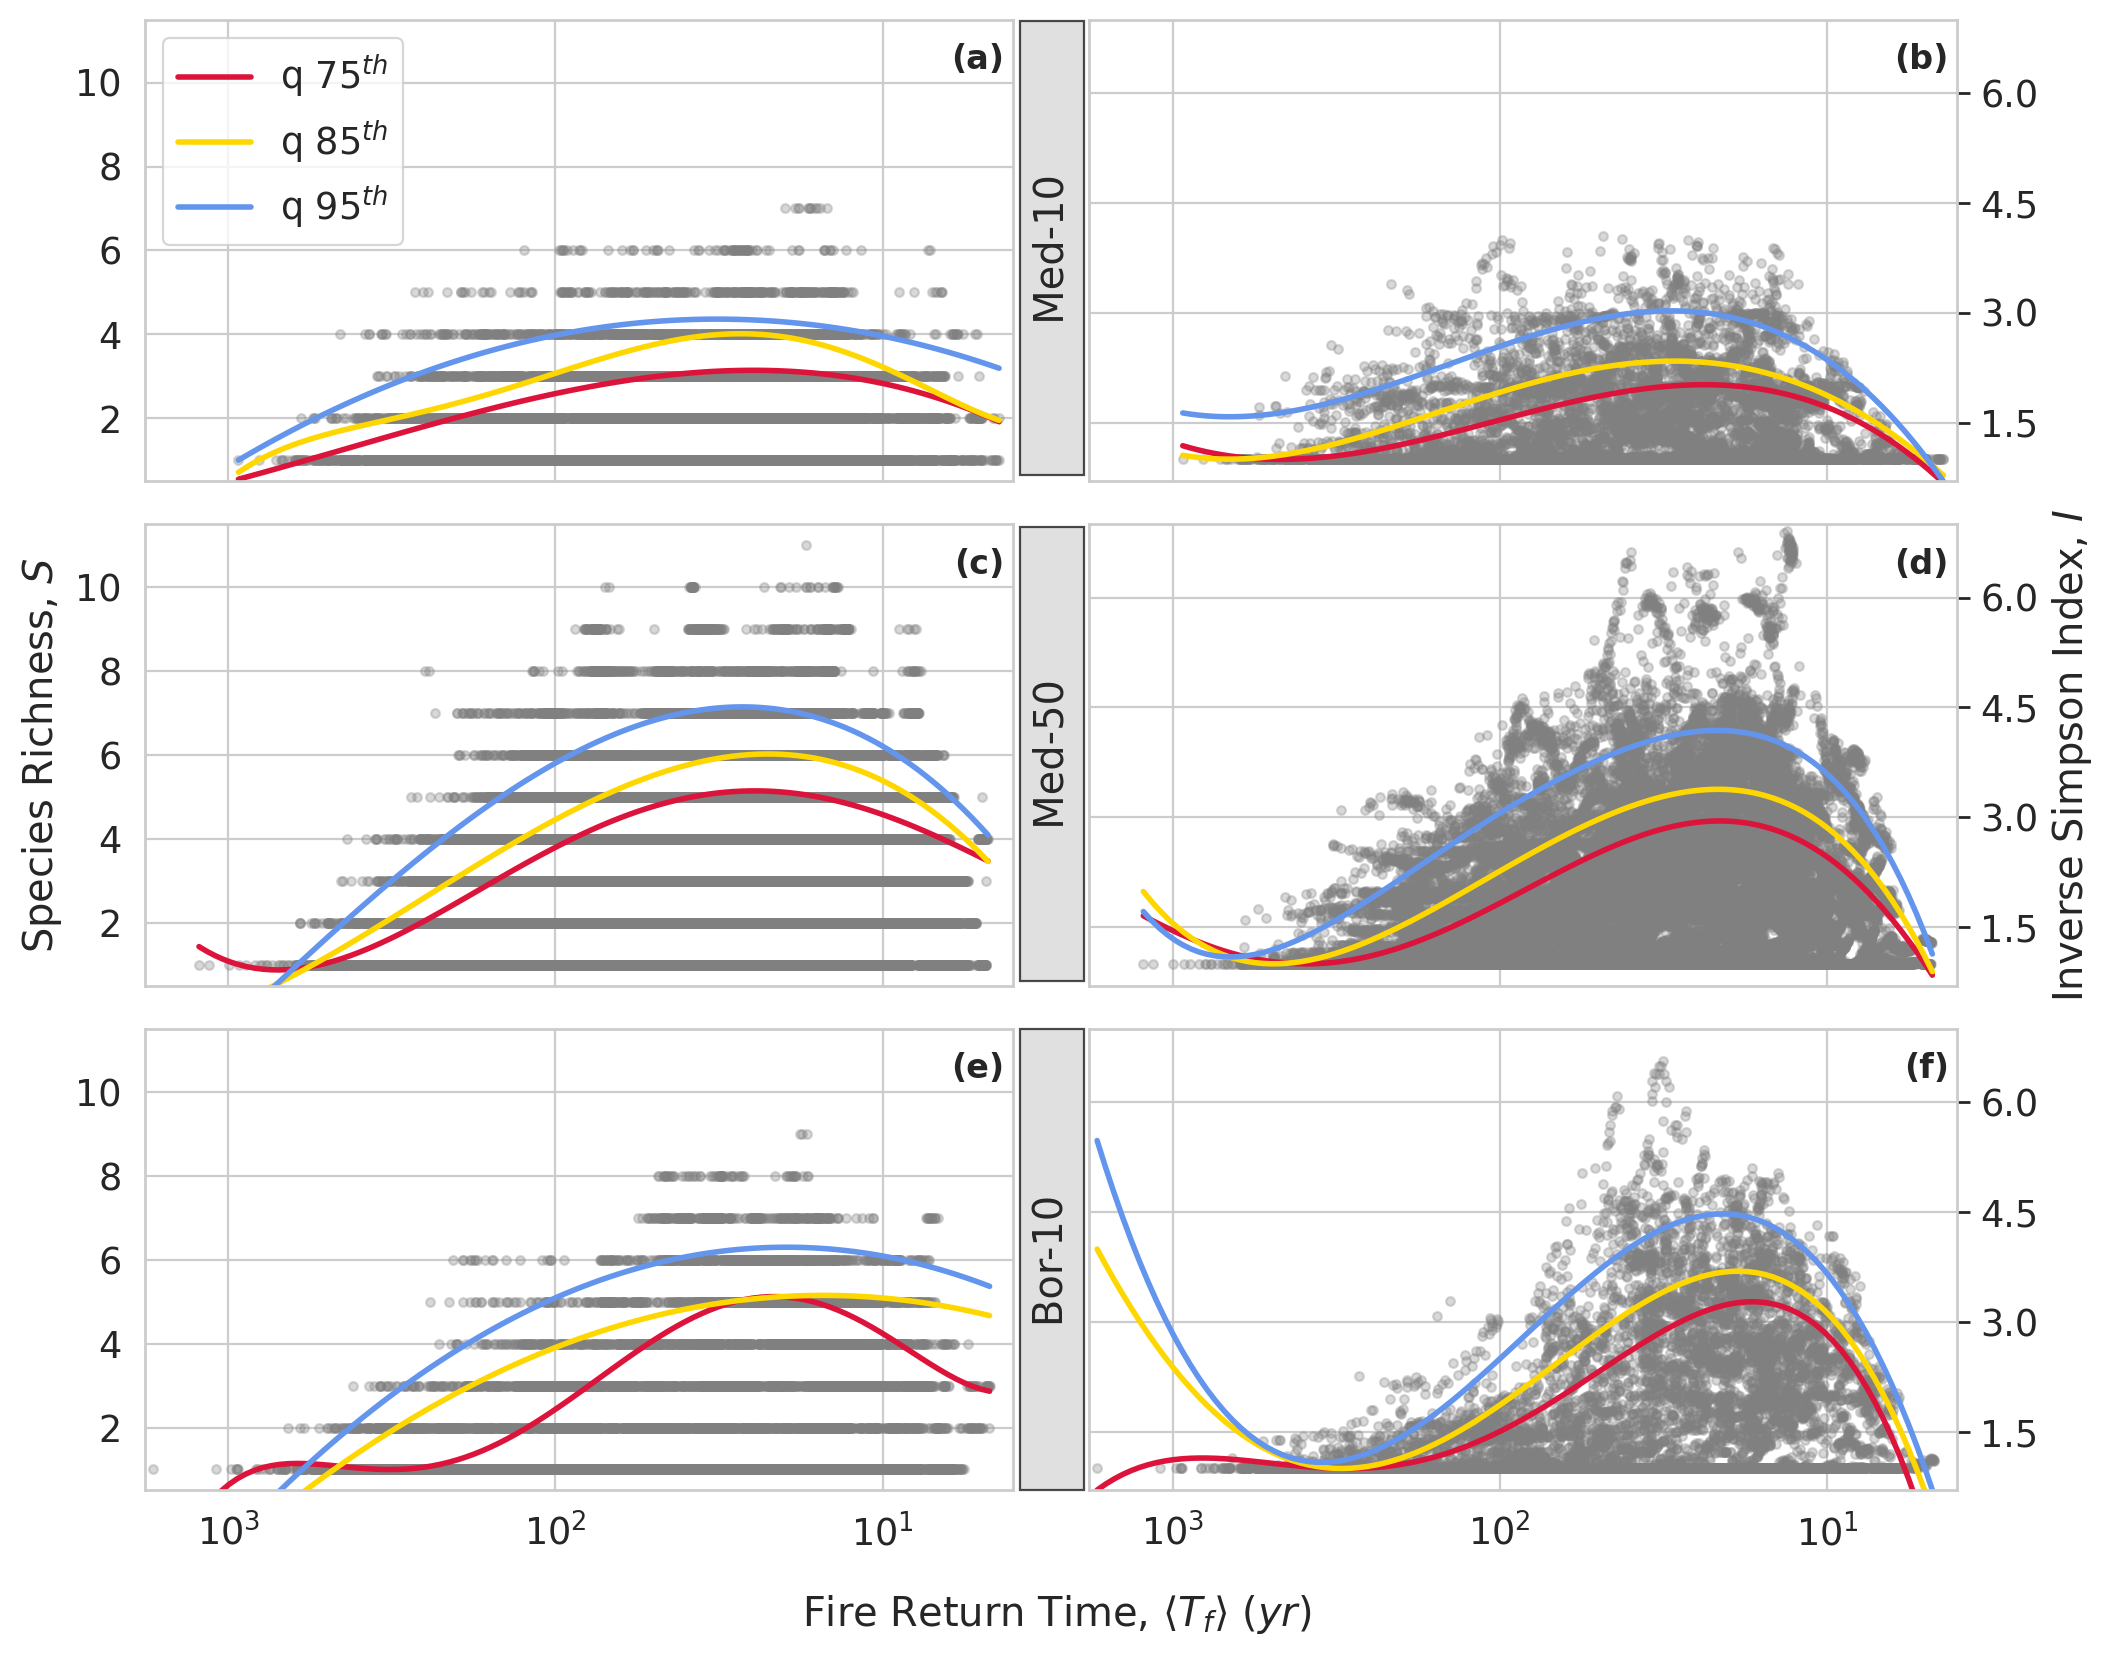

In [137]:
df2 = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df2['frt']=np.log10(df2['frt'])

fig, ax2 = plt.subplots(3,2, figsize=(12,9), sharex=True, sharey='col', dpi=200)
# fig.suptitle("Compositional Diversity")

n=10
i = 0
biome='med'
plot_qreg_cdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='v', verbose=False)

n=50
i = 1
biome='med'
plot_qreg_cdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='v', verbose=False)

n=10
i = 2
biome='bor'
plot_qreg_cdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='v', verbose=False)

# fix the aesthetic of the plot

# Add a single x-label at the bottom
for ax in ax2[-1]:
    # ax.set_xlabel(r"Fire Return Time, $\langle T_f \rangle$ ($yr$)")
    ax.set_xlabel("")
fig.text(0.5, 0.04, r"Fire Return Time, $\langle T_f \rangle$ ($yr$)", ha='center', va='center')

axs = ax2.flatten()
for ax in axs:
    ax.invert_xaxis()
    ax.set(xlim=(np.log10(frt_max),np.log10(frt_min)))
    ticks = [1, 2, 3]
    ax.set_xticks(ticks)
    ax.set_xticklabels([fr'$10^{i}$' for i in ticks])

for ax in ax2[:,0]:
    ax.set_yticks(np.linspace(0, 10, 6))
    ax.set_ylim([0.5,11.5])

for ax in ax2[:,1]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_yticks(np.linspace(1.5, 6.0, 4))
    ax.set_ylim([0.7,7.0])

# Add vertical text for each row covering the entire height, inside a box
row_labels = ['           Med-10           ', '           Med-50           ', '            Bor-10            ']
x_position = 0.498  # Adjust this value to control the horizontal position of the boxes
for i, label in enumerate(row_labels):
    y_position = 0.799 - i * 0.281  # Adjust to center vertically for each row
    fig.text(x_position, y_position, label, va='center', ha='center', rotation='vertical', 
            bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='square,pad=0.3', alpha=0.7))

# Add identifying letters to each subplot, positioned at the top-right corner
letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i, ax in enumerate(ax2.flat):
    ax.text(0.99, 0.95, letters[i], transform=ax.transAxes, fontsize=12, fontweight='bold', 
            va='top', ha='right')

# ax2[0,-1].legend(bbox_to_anchor=(1.15, 1), loc="upper left", borderaxespad=0)
ax2[0,0].legend()
plt.tight_layout(w_pad=1.9, rect=[0.05, 0.05, 0.95, 0.95])

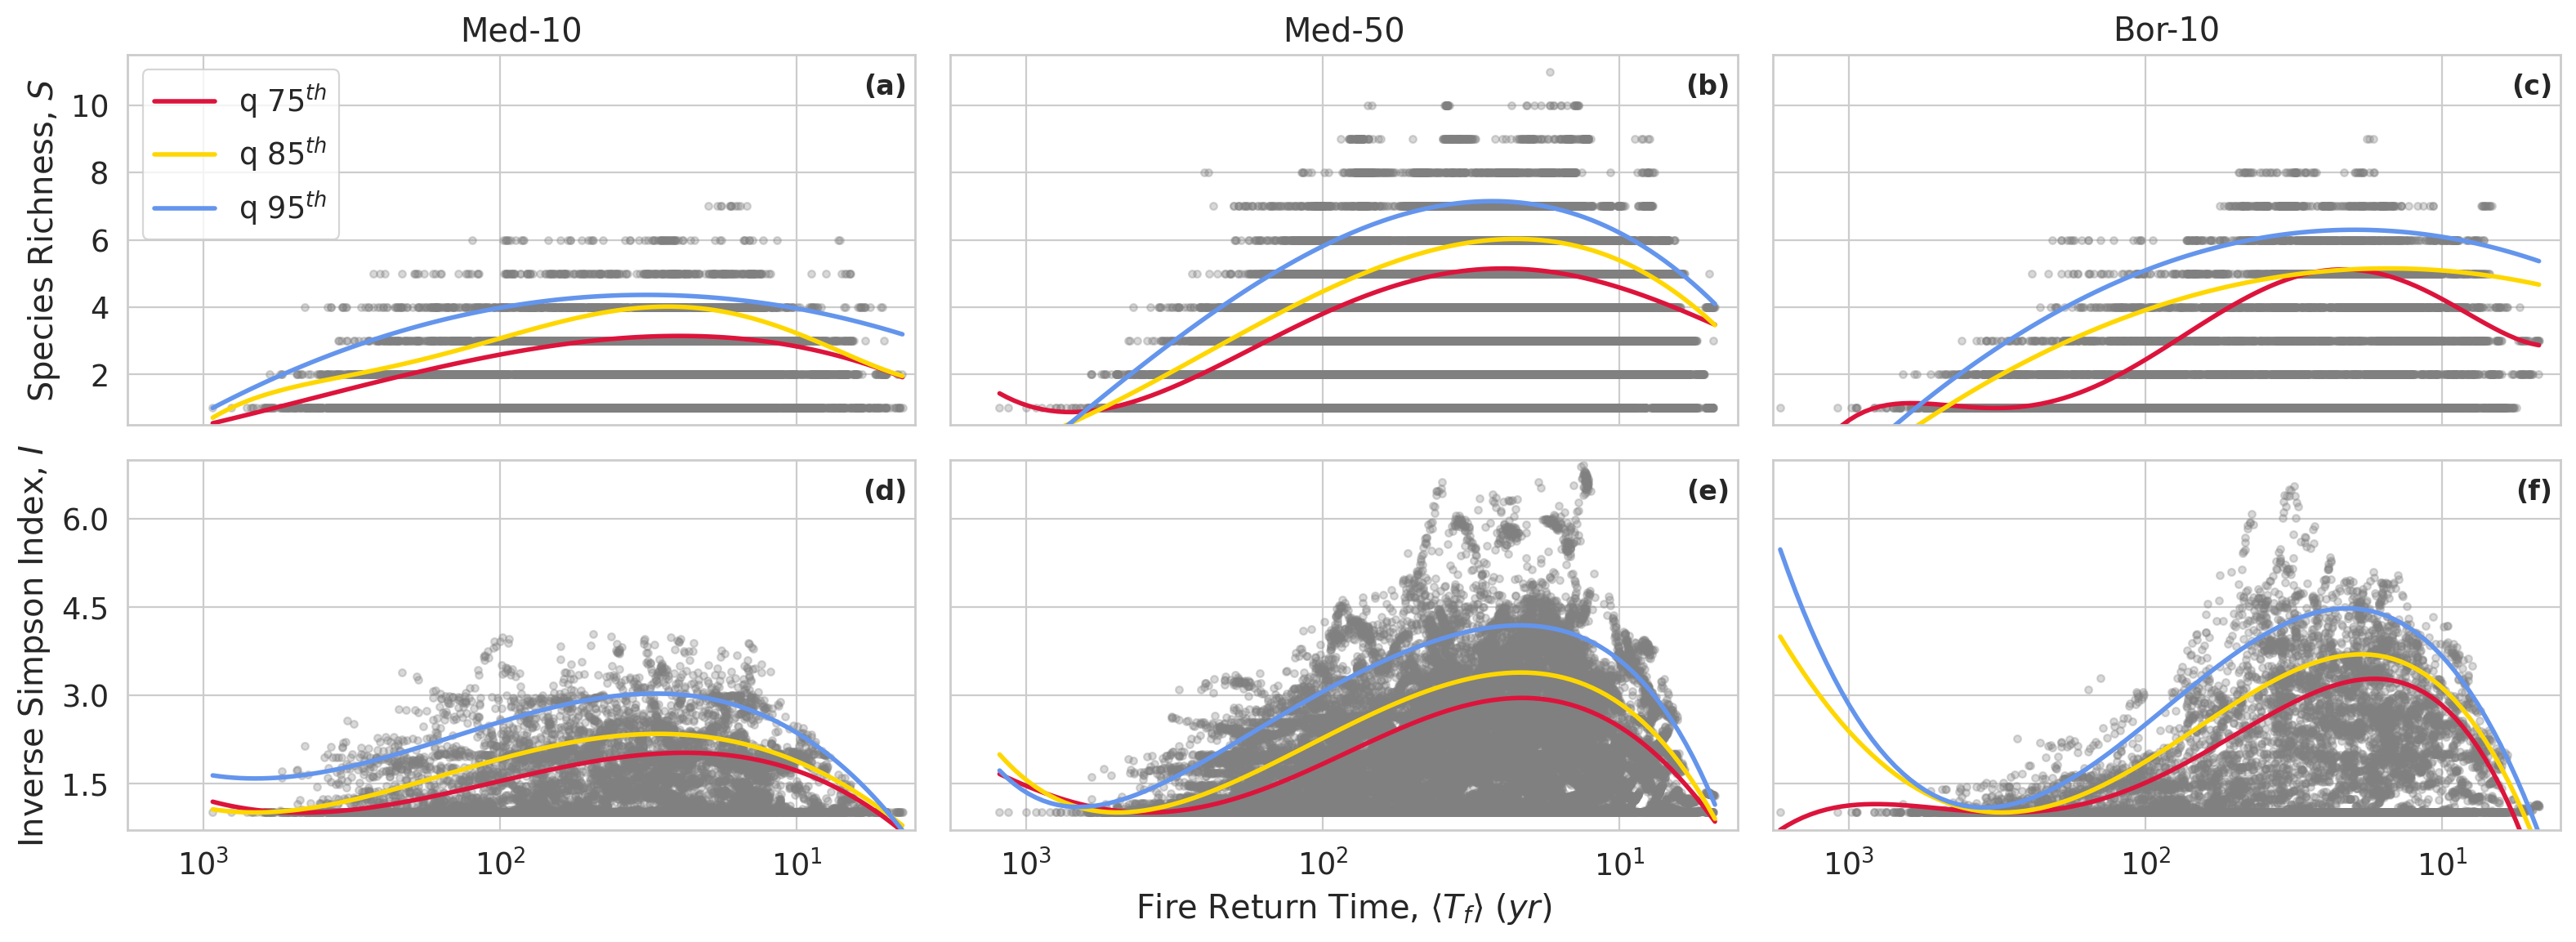

In [166]:
fig, ax2 = plt.subplots(2,3, figsize=(16,6), sharex=True, sharey='row', dpi=200)

n=10
i = 0
biome='med'
plot_qreg_cdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='o', verbose=False)

n=50
i = 1
biome='med'
plot_qreg_cdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='o', verbose=False)

n=10
i = 2
biome='bor'
plot_qreg_cdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='o', verbose=False)

# fix the aesthetic of the plot
# Add a single x-label at the bottom

ax2[1,1].set_xlabel(r"Fire Return Time, $\langle T_f \rangle$ ($yr$)")

axs = ax2.flatten()
for ax in axs:
    ax.invert_xaxis()
    ax.set(xlim=(np.log10(frt_max),np.log10(frt_min)))
    ticks = [1, 2, 3]
    ax.set_xticks(ticks)
    ax.set_xticklabels([fr'$10^{i}$' for i in ticks])

for ax in ax2[0]:
    ax.set_yticks(np.linspace(0, 10, 6))
    ax.set_ylim([0.5,11.5])

for ax in ax2[1]:
    ax.set_yticks(np.linspace(1.5, 6.0, 4))
    ax.set_ylim([0.7,7.0])

ax2[0,0].set_title('Med-10')
ax2[0,1].set_title('Med-50')
ax2[0,2].set_title('Bor-10')

# Add identifying letters to each subplot, positioned at the top-right corner
letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i, ax in enumerate(ax2.flat):
    ax.text(0.99, 0.95, letters[i], transform=ax.transAxes, fontsize=12, fontweight='bold', 
            va='top', ha='right')

# ax2[0,-1].legend(bbox_to_anchor=(1.15, 1), loc="upper left", borderaxespad=0)
ax2[0,0].legend()
plt.tight_layout()

#### Functional Diversity ($F_R$, $F_D$) with Quantile Regression

In [167]:
def plot_qreg_fdiv(df, ax2, i, n, biome, quantiles=[.75, .85, .95], colorq=['purple', 'darkorange', 'forestgreen'], orientation='v', verbose=True):

    if orientation=='v':
        ax2[1,0].set_ylabel("Functional Richness, $F_R$")
        ax2[1,1].set_ylabel("Functional Divergence, $F_D$")
    elif orientation=='o':
        ax2[0,0].set_ylabel("Functional Richness, $F_R$")
        ax2[1,0].set_ylabel("Functional Divergence, $F_D$")
    

    if verbose:
        print(f'n={n}, {biome}')

    if np.any(df):

        data = df[(df['N'] == n) & (df['biome'] == biome)]
        
        if orientation=='v':
            ax2[i,0].scatter('frt', 'frichness', data=data, s=sz, alpha=al, c='grey', label='')
            ax2[i,1].scatter('frt', 'fdivergence', data=data, s=sz, alpha=al, c='grey', label='')
        elif orientation=='o':
            ax2[0,i].scatter('frt', 'frichness', data=data, s=sz, alpha=al, c='grey', label='')
            ax2[1,i].scatter('frt', 'fdivergence', data=data, s=sz, alpha=al, c='grey', label='')

        # QUANTILE REGRESSION

        x_p = np.linspace(data.frt.min(), data.frt.max(), 100)

        for q,cq in zip(quantiles,colorq):
            if verbose:
                print(f'Quantile={q}')

            X = data['frt']

            if verbose:
                print('Functional Richness')

            Y = data['frichness']
            best_degree, best_model, best_aic = best_poly_quantile_regression(Y, X, quantile=q, max_degree=5, verbose=verbose)
            df_pred = pd.DataFrame({'X': x_p})
            # Add the necessary polynomial terms up to the best degree found
            for degree in range(2, best_degree + 1):
                df_pred[f'np.power(X, {degree})'] = np.power(df_pred['X'], degree)
            if orientation=='v':
                ax2[i,0].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))
            elif orientation=='o':
                ax2[0,i].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))

            if verbose:
                print('Functional Divergence')

            Y = data['fdivergence']
            best_degree, best_model, best_aic = best_poly_quantile_regression(Y, X, quantile=q, max_degree=5, verbose=verbose)
            df_pred = pd.DataFrame({'X': x_p})
            # Add the necessary polynomial terms up to the best degree found
            for degree in range(2, best_degree + 1):
                df_pred[f'np.power(X, {degree})'] = np.power(df_pred['X'], degree)
            if orientation=='v':
                ax2[i,1].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))
            elif orientation=='o':
                ax2[1,i].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))


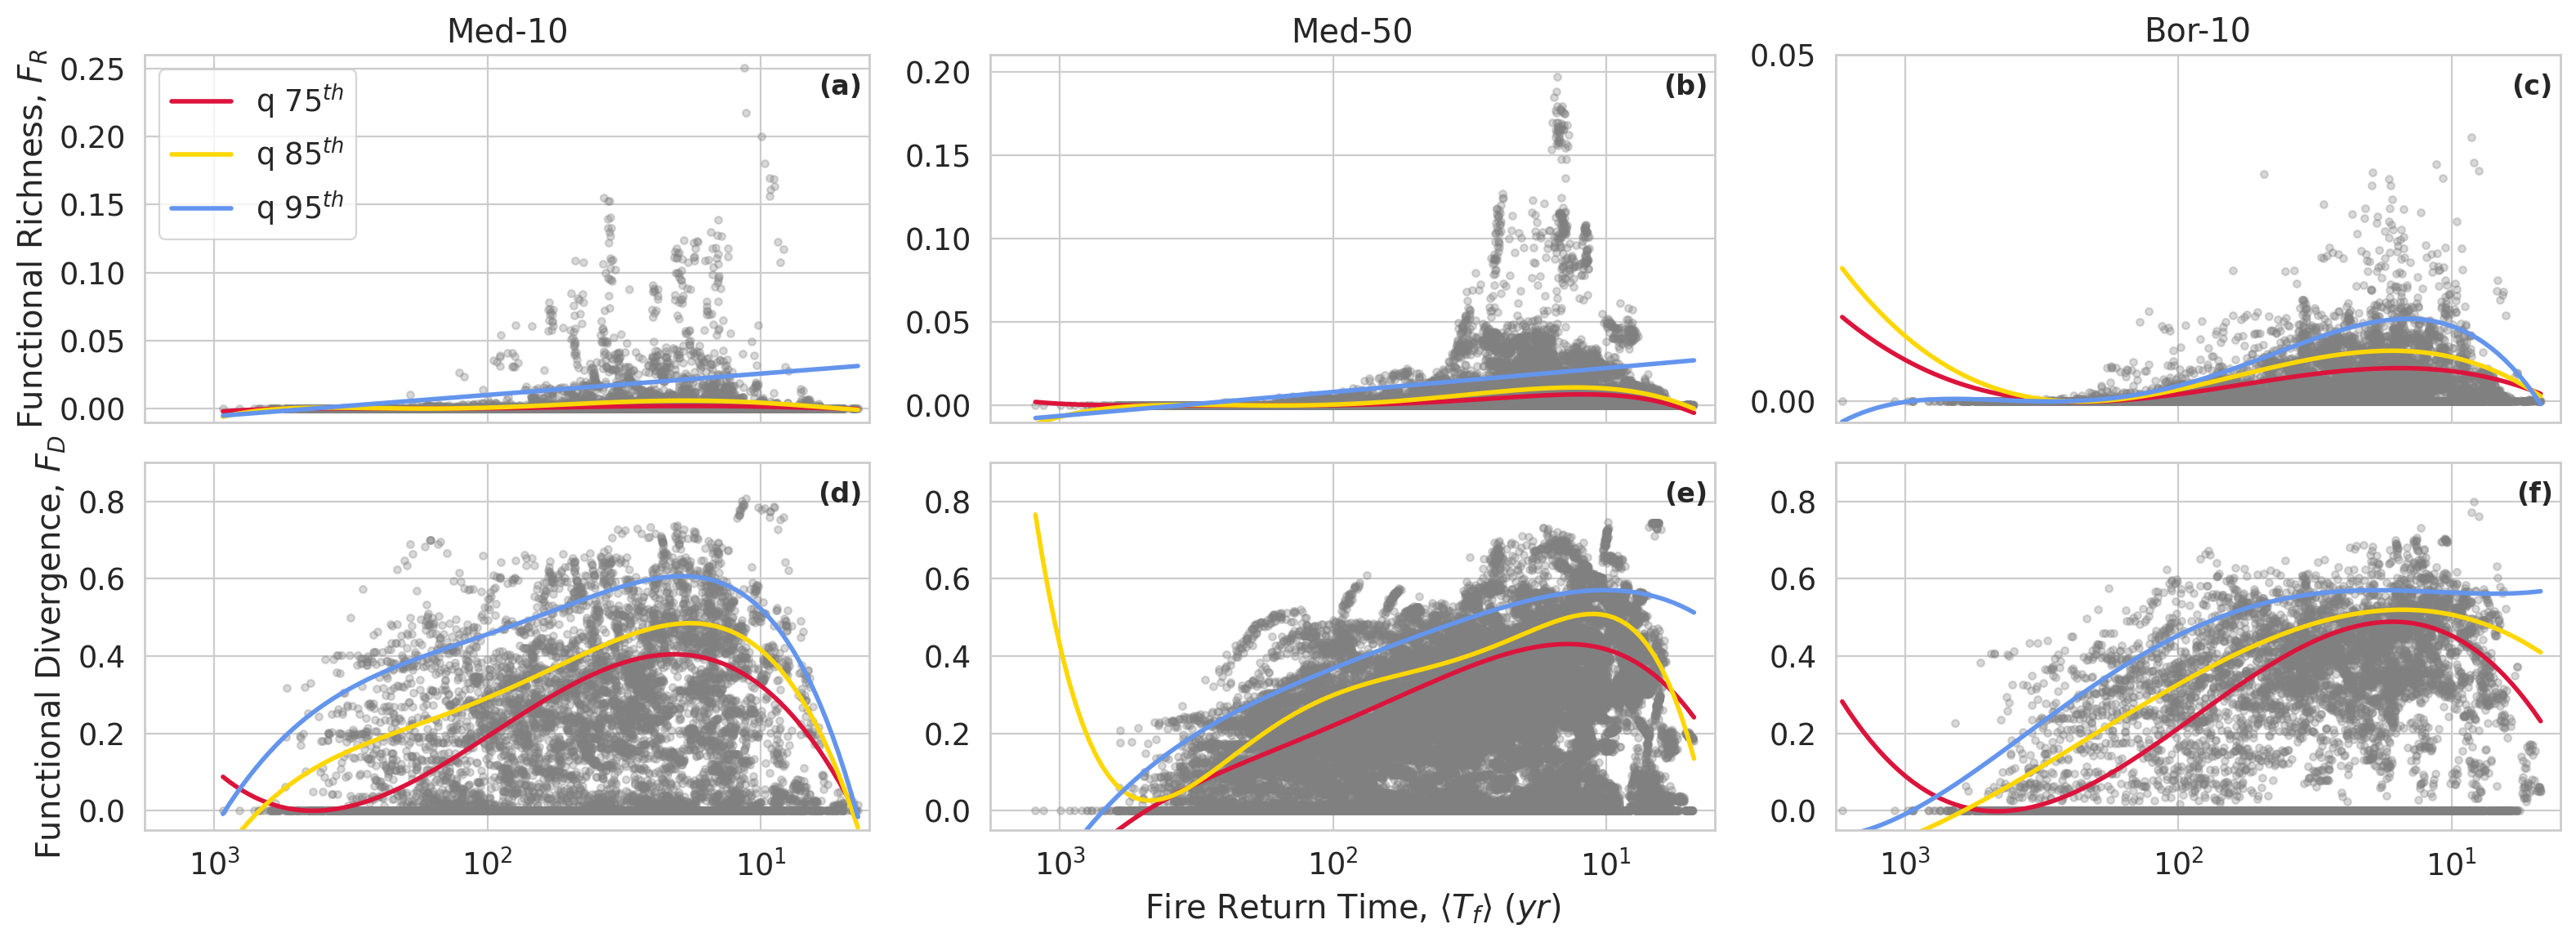

In [170]:
fig, ax2 = plt.subplots(2,3, figsize=(16,6), sharex=True, dpi=200)

n=10
i = 0
biome='med'
plot_qreg_fdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='o', verbose=False)

n=50
i = 1
biome='med'
plot_qreg_fdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='o', verbose=False)

n=10
i = 2
biome='bor'
plot_qreg_fdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='o', verbose=False)

ax2[1,1].set_xlabel(r"Fire Return Time, $\langle T_f \rangle$ ($yr$)")

for ax in ax2.flatten():
    ax.invert_xaxis()
    ax.set(xlim=(np.log10(frt_max),np.log10(frt_min)))
    # Set custom x-ticks at the positions of log10 values
    ticks = [1, 2, 3]
    ax.set_xticks(ticks)
    ax.set_xticklabels([fr'$10^{i}$' for i in ticks])


# Fix Y-ticks - Functional Richness
ax2[0,0].set_yticks(np.arange(0.0, 0.26, 0.05))
ax2[0,0].set_ylim([-0.01,0.26])
ax2[0,1].set_yticks(np.arange(0.0, 0.21, 0.05))
ax2[0,1].set_ylim([-0.01,0.21])
# ax2[1,0].set_xticklabels([f'{i}' for i in np.arange(0.0, 0.31, 0.1)])
ax2[0,2].set_yticks(np.arange(0.0, 0.055, 0.05))
ax2[0,2].set_ylim([-0.003,0.05])

# Fix Y-ticks - Functional Divergence
for ax in ax2[1]:
    # ax.yaxis.set_label_position("right")
    # ax.yaxis.tick_right()
    ax.set_yticks(np.arange(0.0, 0.9, 0.2))
    ax.set_ylim([-0.05,0.9])

ax2[0,0].set_title('Med-10')
ax2[0,1].set_title('Med-50')
ax2[0,2].set_title('Bor-10')

# Add identifying letters to each subplot, positioned at the top-right corner
letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i, ax in enumerate(ax2.flat):
    ax.text(0.99, 0.95, letters[i], transform=ax.transAxes, fontsize=12, fontweight='bold', 
            va='top', ha='right')

# ax2[0,-1].legend(bbox_to_anchor=(1.15, 1), loc="upper left", borderaxespad=0)
ax2[0,0].legend()
plt.tight_layout()

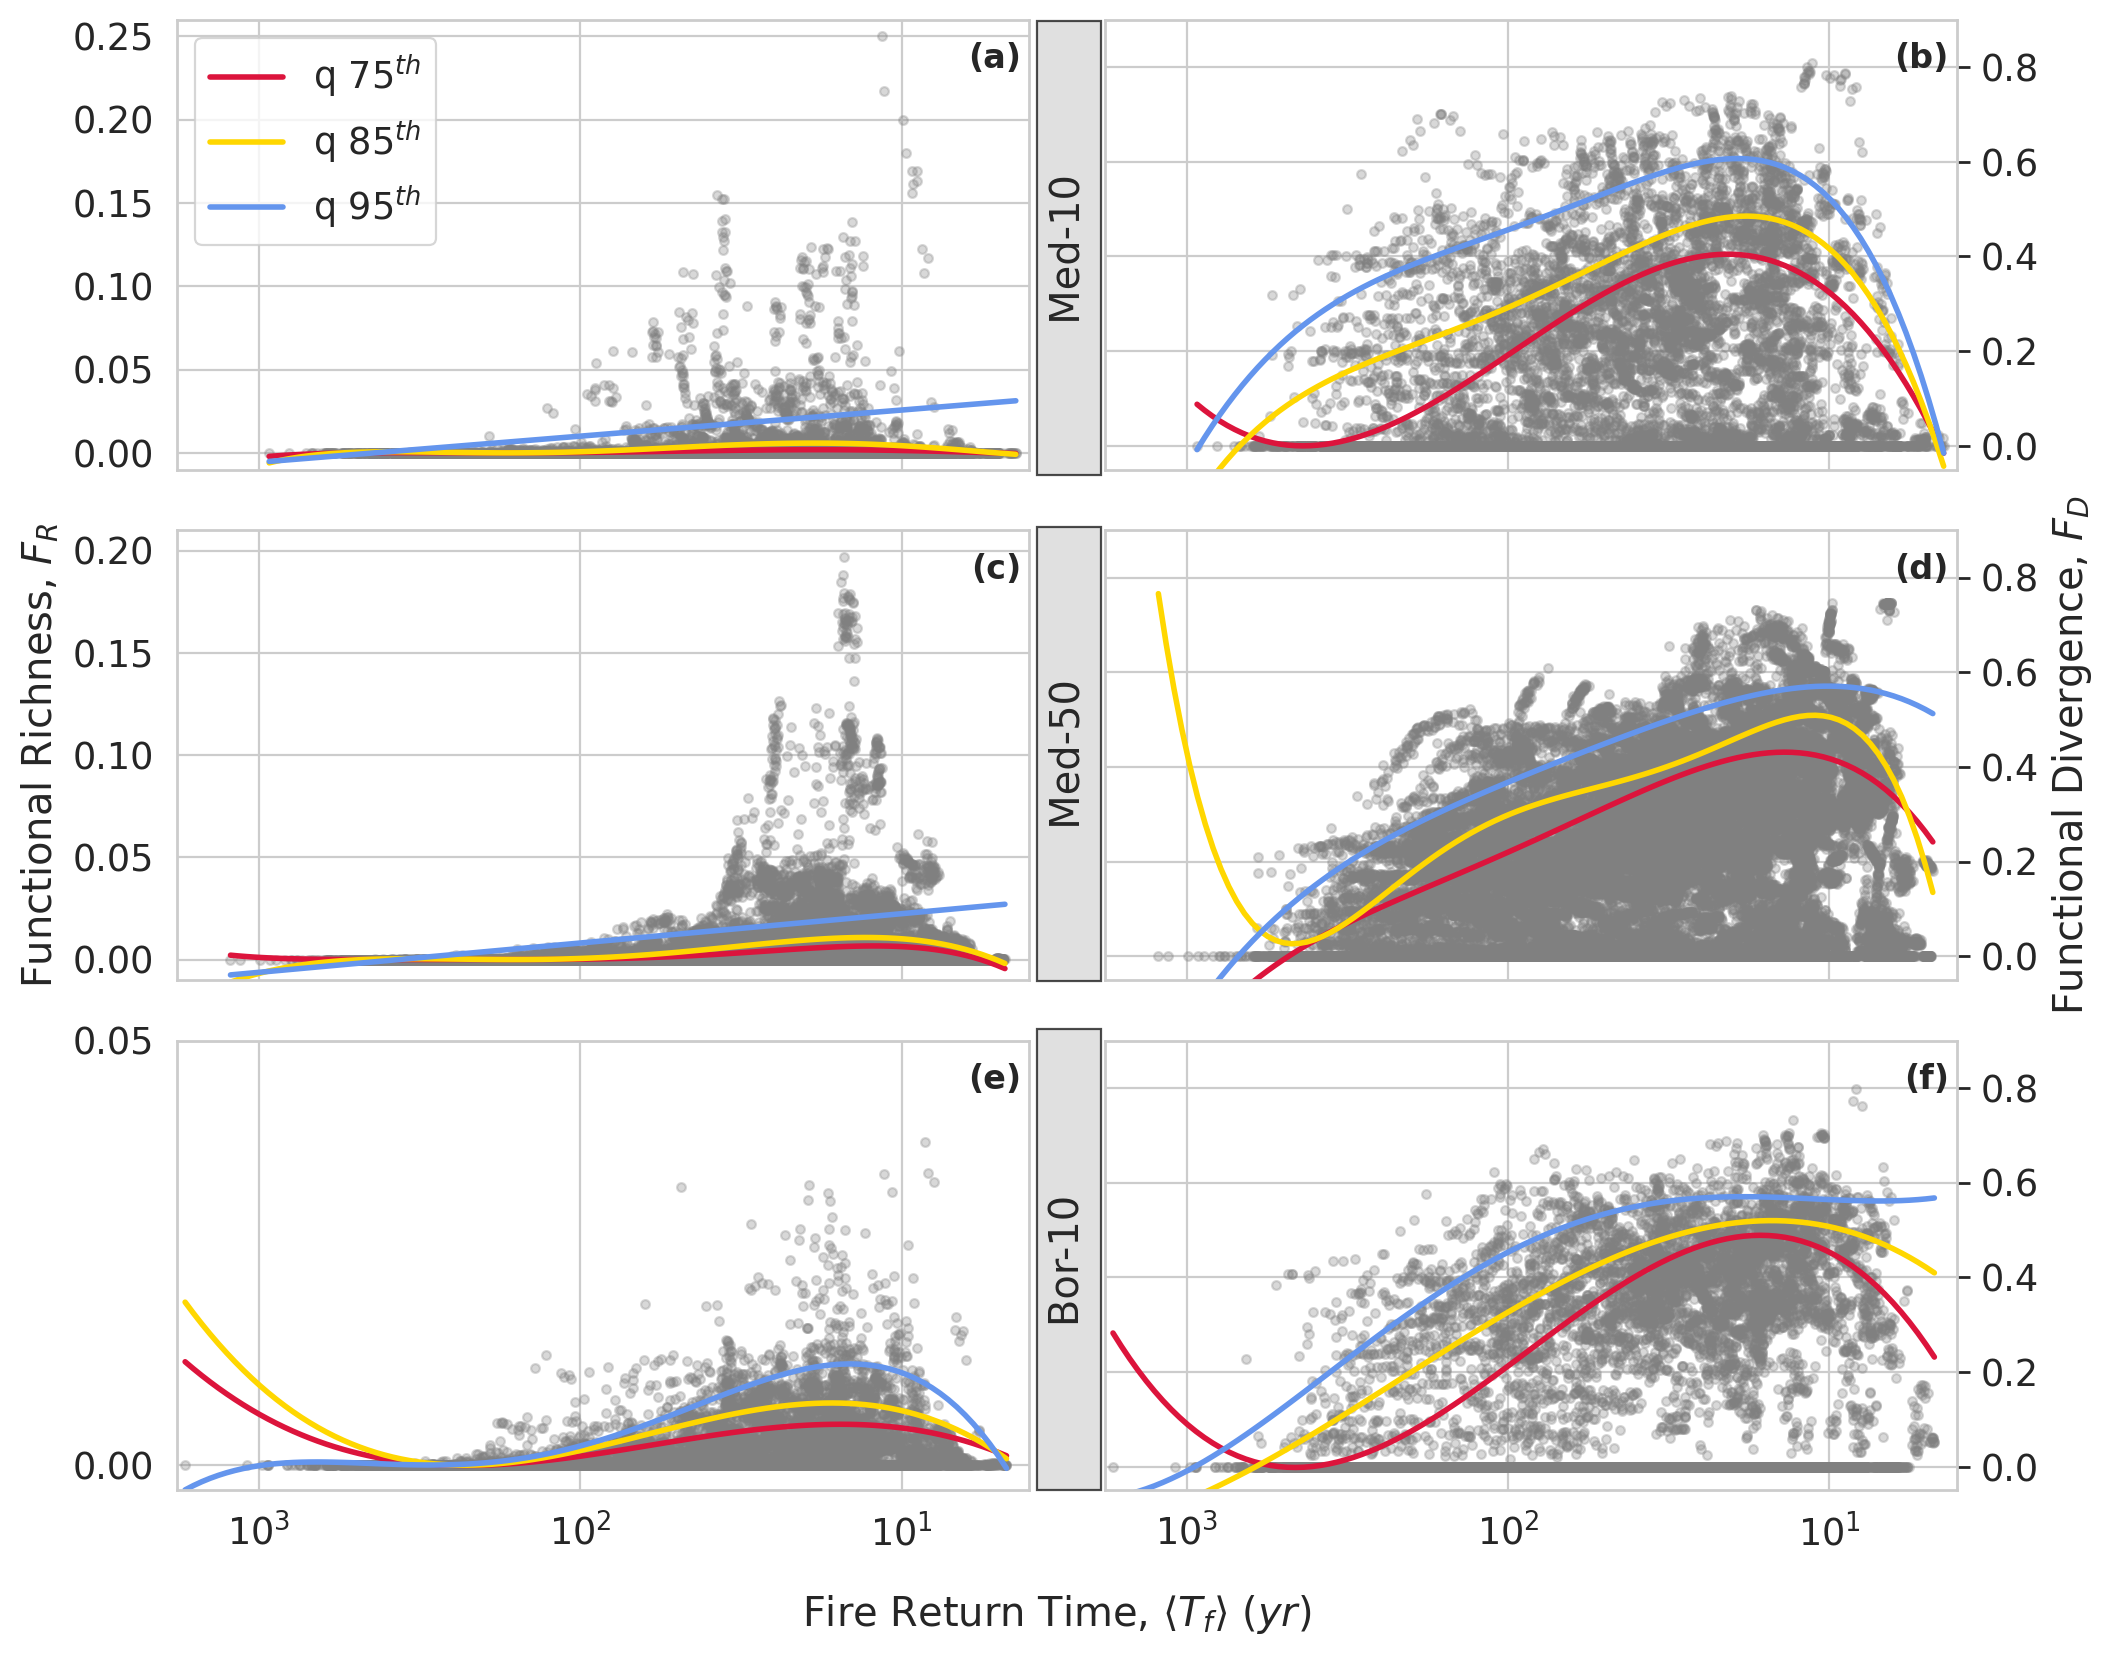

In [135]:
df2 = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df2['frt']=np.log10(df2['frt'])

fig, ax2 = plt.subplots(3,2, figsize=(12,9), sharex=True, dpi=200)

# ax2[0,0].set_title("Functional Richness, $F_R$")
    # ax.set(ylim=y_sr)

# ax2[0,1].set_title("Functional Divergence, $F_D$")
    # ax.set(ylim=y_sr)

n=10
i = 0
biome='med'
plot_qreg_fdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='v', verbose=False)

n=50
i = 1
biome='med'
plot_qreg_fdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='v', verbose=False)

n=10
i = 2
biome='bor'
plot_qreg_fdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='v', verbose=False)

for ax in ax2[-1]:
    # ax.set_xlabel(r"Fire Return Time, $\langle T_f \rangle$ ($yr$)")
    ax.set_xlabel("")

# Add a single x-label at the bottom
fig.text(0.5, 0.04, r"Fire Return Time, $\langle T_f \rangle$ ($yr$)", ha='center', va='center')

for ax in ax2.flatten():
    ax.invert_xaxis()
    ax.set(xlim=(np.log10(frt_max),np.log10(frt_min)))
    # Set custom x-ticks at the positions of log10 values
    ticks = [1, 2, 3]
    ax.set_xticks(ticks)
    ax.set_xticklabels([fr'$10^{i}$' for i in ticks])


# Fix Y-ticks - Functional Richness
ax2[0,0].set_yticks(np.arange(0.0, 0.26, 0.05))
ax2[0,0].set_ylim([-0.01,0.26])
ax2[1,0].set_yticks(np.arange(0.0, 0.21, 0.05))
ax2[1,0].set_ylim([-0.01,0.21])
# ax2[1,0].set_xticklabels([f'{i}' for i in np.arange(0.0, 0.31, 0.1)])
ax2[2,0].set_yticks(np.arange(0.0, 0.055, 0.05))
ax2[2,0].set_ylim([-0.003,0.05])

# Fix Y-ticks - Functional Divergence
for ax in ax2[:,1]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_yticks(np.arange(0.0, 0.9, 0.2))
    ax.set_ylim([-0.05,0.9])

# Add vertical text for each row covering the entire height, inside a box
row_labels = ['           Med-10           ', '           Med-50           ', '            Bor-10            ']
x_position = 0.505  # Adjust this value to control the horizontal position of the boxes
for i, label in enumerate(row_labels):
    y_position = 0.799 - i * 0.281  # Adjust to center vertically for each row
    fig.text(x_position, y_position, label, va='center', ha='center', rotation='vertical', 
            bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='square,pad=0.3', alpha=0.7))

# Add identifying letters to each subplot, positioned at the top-right corner
letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i, ax in enumerate(ax2.flat):
    ax.text(0.99, 0.95, letters[i], transform=ax.transAxes, fontsize=12, fontweight='bold', 
            va='top', ha='right')

# ax2[0,-1].legend(bbox_to_anchor=(1.15, 1), loc="upper left", borderaxespad=0)
ax2[0,0].legend()
plt.tight_layout(w_pad=1.89, rect=[0.05, 0.05, 0.95, 0.95])

### Biodiversity indicators Correlation

In [117]:
data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
data['eco-type'] = data['biome'] + data['N'].astype(str)
data.loc[data['eco-type']=='med10','eco-type'] = 'Med-10'
data.loc[data['eco-type']=='med50','eco-type'] = 'Med-50'
data.loc[data['eco-type']=='bor10','eco-type'] = 'Bor-10'
data

Unnamed: 0 biome   N  ncom  init         frt  srichness  isimpson  \
0               0   med  10     1     1  300.204501          1  1.000000   
1               1   med  10     1     2  330.987580          1  1.000000   
2               2   med  10     1     3  190.522146          1  1.000000   
3               3   med  10     1     4  277.254623          1  1.000000   
4               4   med  10     1     5  247.715890          1  1.000000   
...           ...   ...  ..   ...   ...         ...        ...       ...   
75995       75995   med  50  1000    48   24.597571          2  1.032824   
75996       75996   med  50  1000    49   25.369989          2  1.042916   
75997       75997   med  50  1000    50   24.715530          2  1.043562   
75998       75998   med  50  1000    51   24.066325          2  1.018454   
75999       75999   med  50  1000    52   24.438829          2  1.044972   

          frichness  fdivergence eco-type  
0      0.000000e+00     0.000000   Med-10  
1      0.000000e+00     0.000000   Med-10  
2      0.000000e+00     0.000000   Med-10  
3      0.000000e+00     0.000000   Med-10  
4      0.000000e+00     0.000000   Med-10  
...             ...          ...      ...  
75995  6.404142e-10     0.014152   Med-50  
75996  1.936028e-09     0.021929   Med-50  
75997  1.845927e-09     0.022717   Med-50  
75998  1.952652e-10     0.010591   Med-50  
75999  1.691819e-09     0.022729   Med-50  

[76000 rows x 11 columns]

In [118]:
def corrfunc(x, y, **kwds):
    cmap = kwds['cmap']
    norm = kwds['norm']
    ax = plt.gca()
    # sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = scs.pearsonr(x, y)
    
    # Set the regression line color dynamically based on correlation
    scatter_kws = kwds.get('scatter_kws', {'s': 10, 'color': 'pink'})
    line_color = cmap(norm(r))  # Match line color with heatmap color
    line_kws = kwds.get('line_kws', {'color': line_color, 'linewidth': 2})
    sns.regplot(x=x, y=y, scatter_kws=scatter_kws, line_kws=line_kws, ax=ax)
    
    # Add annotation in the upper-left corner
    ax.annotate(f"r={r:.2f}", xy=(0.08, 0.9), xycoords='axes fraction', color='black', size=12, ha='left', va='top')
    # ax.set_title(f"r={r:.2f}")
    
sns.set_theme(context="paper", style="white", font_scale=1.5, rc={"lines.linewidth": 2})

/tmp/ipykernel_1070529/1574649375.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


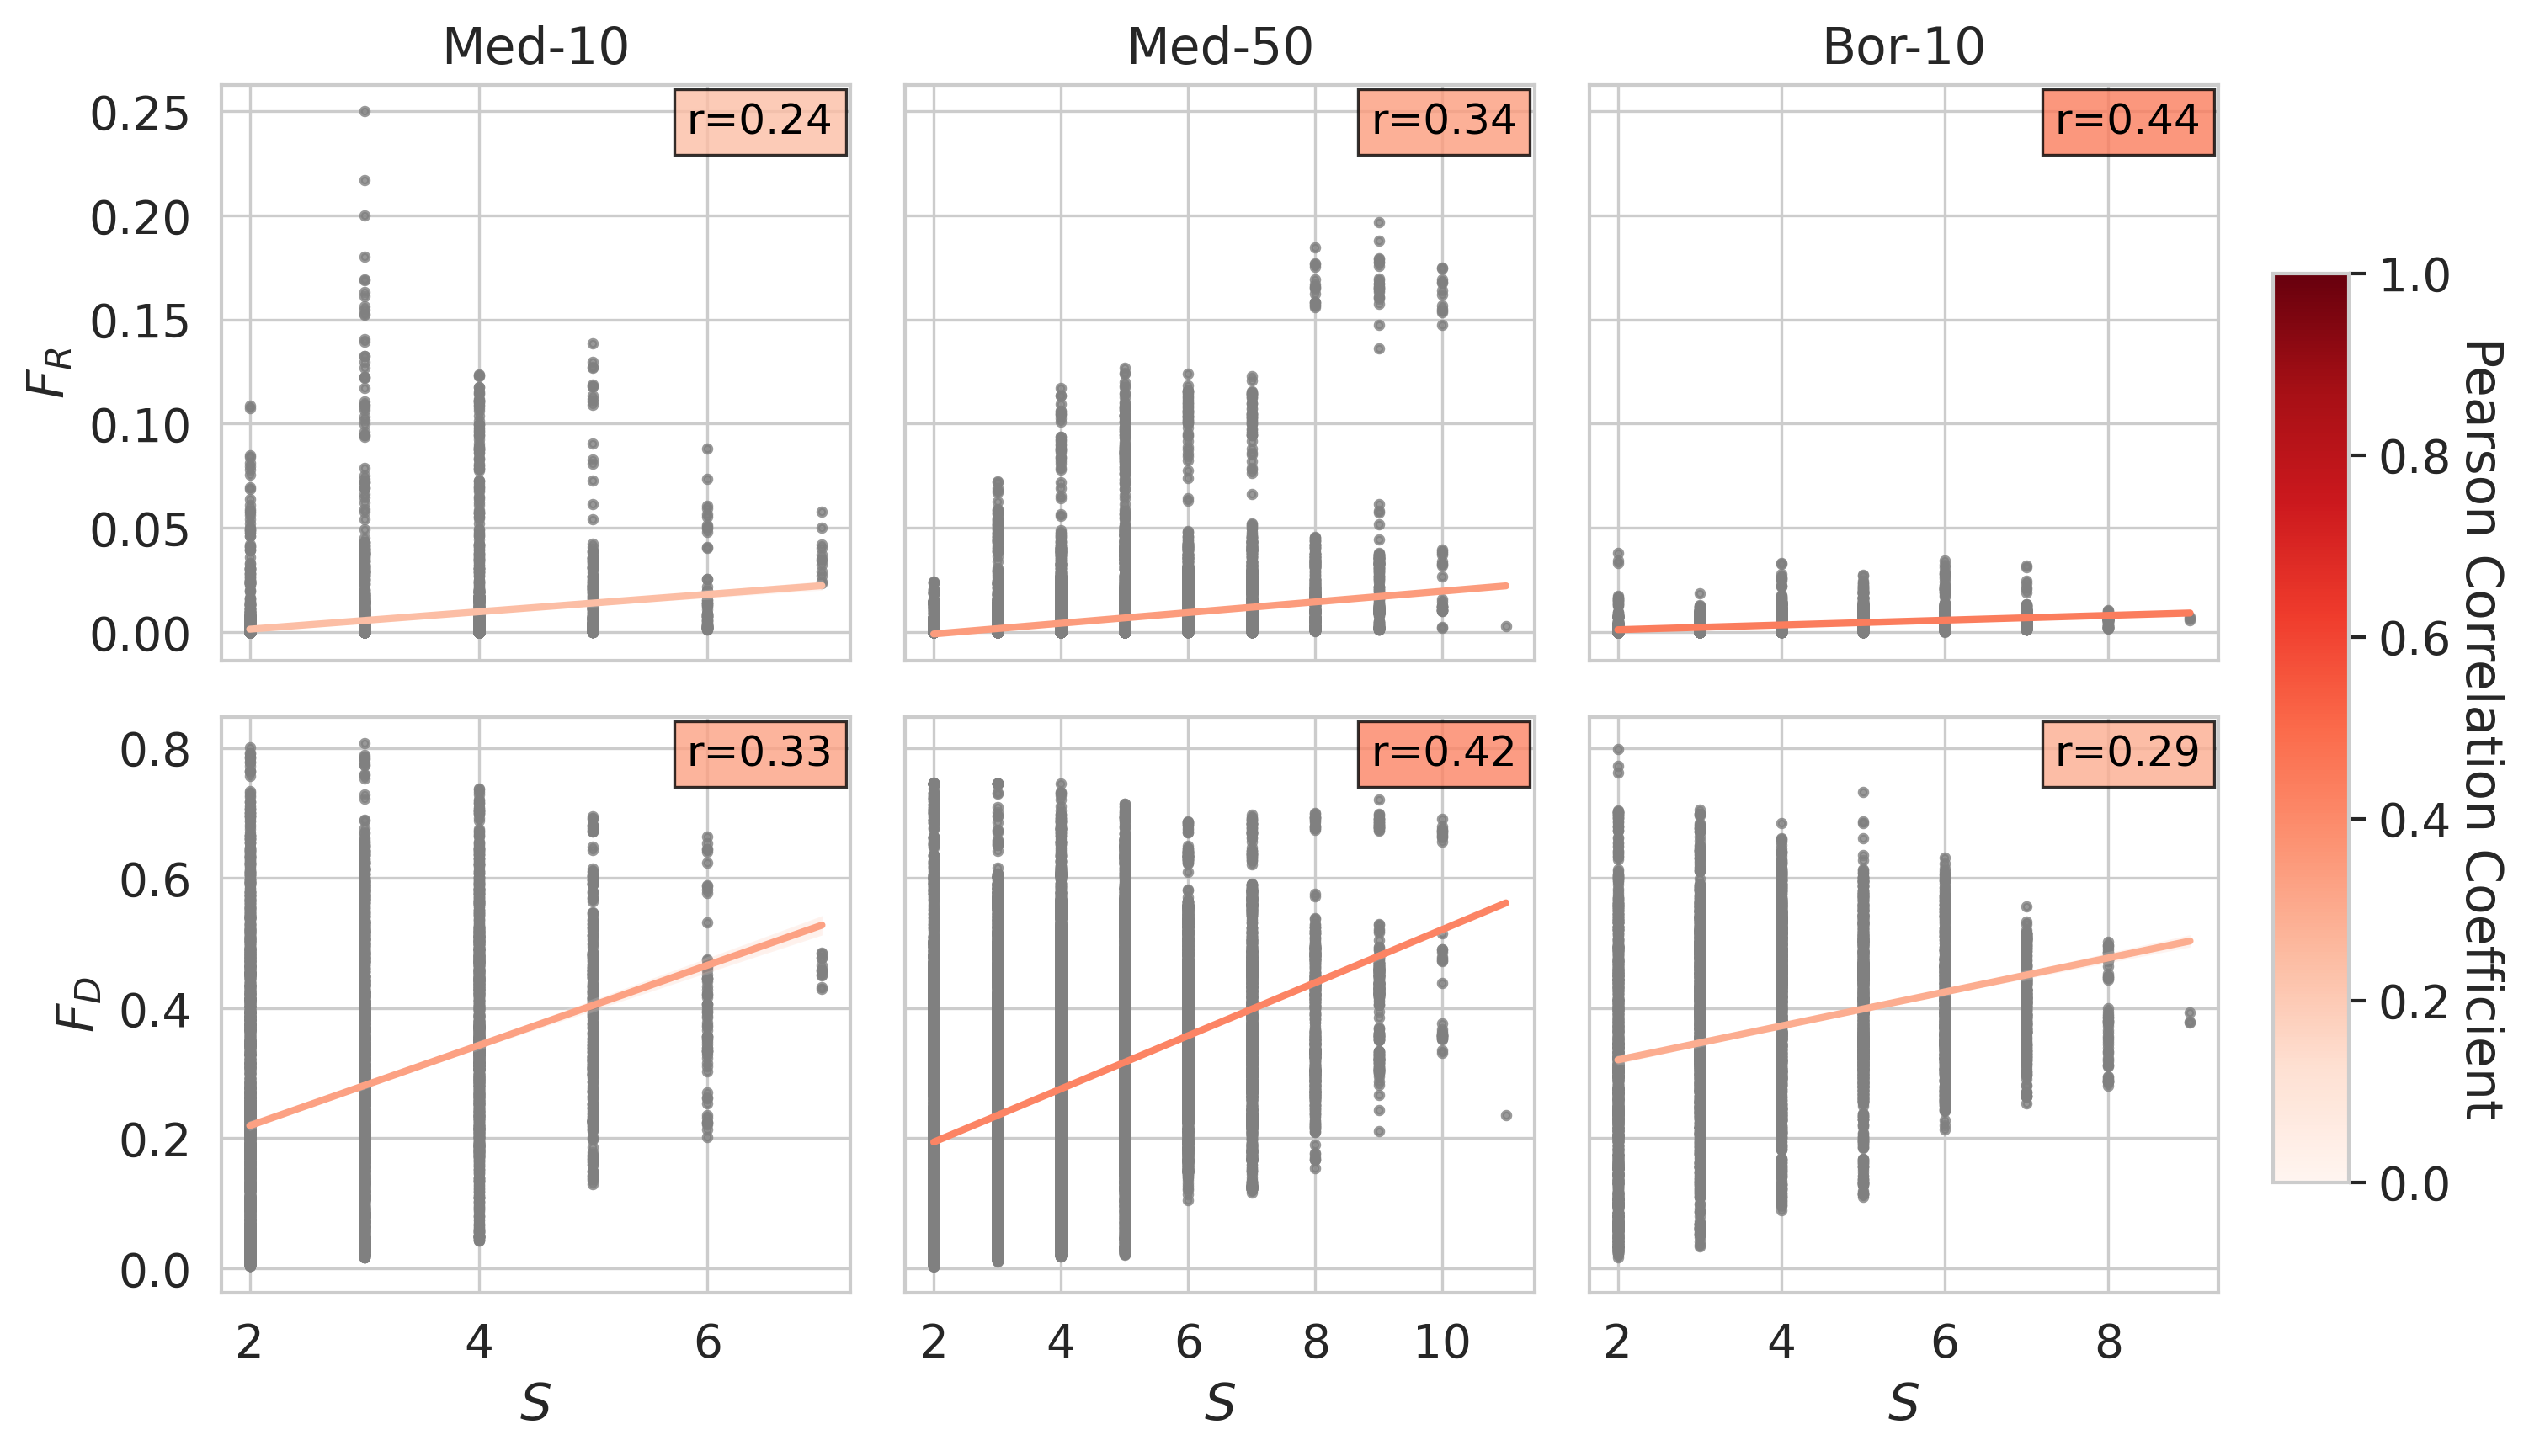

In [172]:
sns.set_theme(context="paper", style="whitegrid", font_scale=1.5, rc={"lines.linewidth": 2})

# Define the custom correlation function
def corrfunc(ax, x, y, cmap, norm, scatter_kws):
    r, _ = scs.pearsonr(x, y)
    
    # Set the regression line color dynamically based on correlation
    line_color = cmap(norm(r))  # Match line color with heatmap color
    sns.regplot(x=x, y=y, scatter_kws=scatter_kws, line_kws={'color': line_color, 'linewidth': 2}, ax=ax)
    
    # Add annotation in the upper-left corner
    bbox_props = dict(boxstyle="square", edgecolor="black", facecolor=line_color, alpha=0.8)
    ax.annotate(f"r={r:.2f}", xy=(0.74, 0.97), xycoords='axes fraction', color='black', size=12, ha='left', va='top', bbox=bbox_props)


# Set up color map and normalization
cmap_corr = mpl.colormaps['Reds']
norm_corr = mpl.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

# Load data
data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df = data[(data['biome']=='med') & (data['N']==10)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
d1 = df[(df['srichness']>1)].iloc[:,2:].rename(columns={'srichness':'$S$', 'isimpson':'$I$', 'frichness':'$F_R$', 'fdivergence':'$F_D$'})
df = data[(data['biome']=='med') & (data['N']==50)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
d2 = df[(df['srichness']>1)].iloc[:,2:].rename(columns={'srichness':'$S$', 'isimpson':'$I$', 'frichness':'$F_R$', 'fdivergence':'$F_D$'})
df = data[(data['biome']=='bor') & (data['N']==10)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
d3 = df[(df['srichness']>1)].iloc[:,2:].rename(columns={'srichness':'$S$', 'isimpson':'$I$', 'frichness':'$F_R$', 'fdivergence':'$F_D$'})

# Variables to plot
x_vars = ["$S$"]
y_vars = ["$F_R$", "$F_D$"]

# Create the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), sharex='col', sharey='row', dpi=300)
scatter_kws = {'s': 5, 'color': 'grey'}

# Plot the first dataset
for i, y_var in enumerate(y_vars):
    ax = axes[i, 0]
    corrfunc(ax, d1["$S$"], d1[y_var], cmap_corr, norm_corr, scatter_kws)
axes[0,0].set_title("Med-10")

# Plot the second dataset
for i, y_var in enumerate(y_vars):
    ax = axes[i, 1]
    corrfunc(ax, d2["$S$"], d2[y_var], cmap_corr, norm_corr, scatter_kws)
    ax.set_xticks([2,4,6,8,10])
axes[0,1].set_title("Med-50")

for i, y_var in enumerate(y_vars):
    ax = axes[i, 2]
    corrfunc(ax, d3["$S$"], d3[y_var], cmap_corr, norm_corr, scatter_kws)
axes[0,2].set_title("Bor-10")

for ax in axes.flatten():
    ax.label_outer()

# Add a shared colorbar
cbar_ax = fig.add_axes([0.9, 0.2, 0.03, 0.6])  # [left, bottom, width, height]
sm = ScalarMappable(norm=norm_corr, cmap=cmap_corr)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Pearson Correlation Coefficient", rotation=270, labelpad=15)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar

In [182]:
def corrfunc(x, y, **kwds):
    cmap = kwds['cmap']
    norm = kwds['norm']
    ax = plt.gca()
    # sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = scs.pearsonr(x, y)
    
    # Set the regression line color dynamically based on correlation
    scatter_kws = kwds.get('scatter_kws', {'s': 10, 'color': 'pink'})
    line_color = cmap(norm(r))  # Match line color with heatmap color
    line_kws = kwds.get('line_kws', {'color': line_color, 'linewidth': 2})
    sns.regplot(x=x, y=y, scatter_kws=scatter_kws, line_kws=line_kws, ax=ax)
    
    # Add annotation in the upper-left corner
    bbox_props = dict(boxstyle="square", edgecolor="black", facecolor=line_color, alpha=0.8)
    ax.annotate(f"r={r:.2f}", xy=(0.72, 0.97), xycoords='axes fraction', color='black', size=12, ha='left', va='top', bbox=bbox_props)
    # ax.annotate(f"r={r:.2f}", xy=(0.08, 0989), xycoords='axes fraction', color='black', size=12, ha='left', va='top')
    # ax.set_title(f"r={r:.2f}")
    
# sns.set_theme(context="paper", style="white", font_scale=1.5, rc={"lines.linewidth": 2})

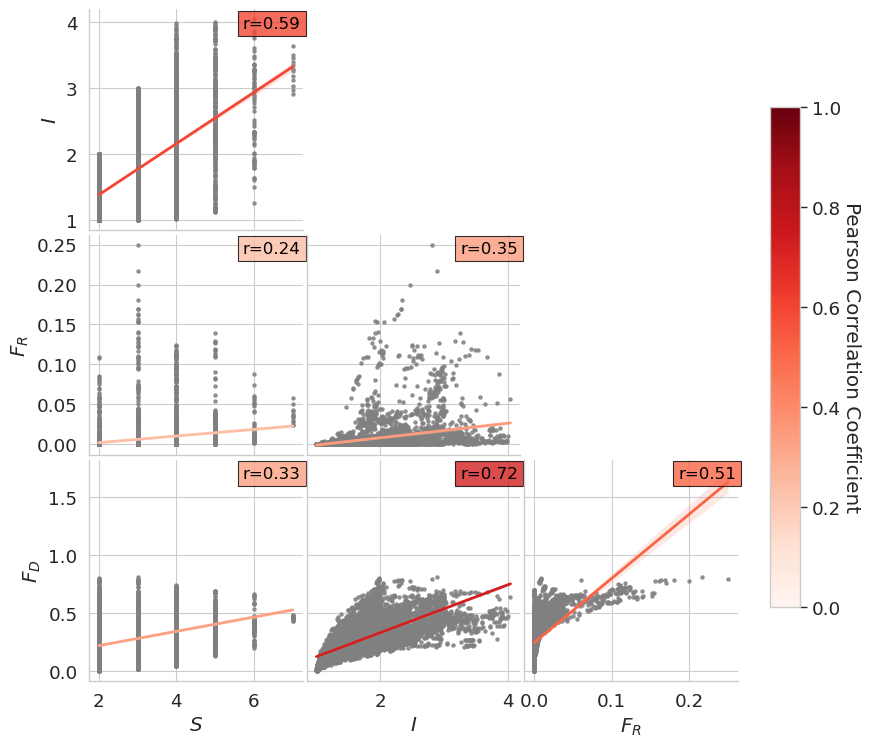

In [183]:
cmap_corr = mpl.colormaps['Reds']
norm_corr = mpl.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df = data[(data['biome']=='med') & (data['N']==10)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
d1 = df[(df['srichness']>1)].iloc[:,2:].rename(columns={'srichness':'$S$', 'isimpson':'$I$', 'frichness':'$F_R$', 'fdivergence':'$F_D$'})


g = sns.PairGrid(d1)
g.map_lower(corrfunc, cmap=cmap_corr, norm=norm_corr, scatter_kws={'s': 5, 'color': 'grey'})
# g.map_diag(sns.histplot, kde=False, element="step", color='grey')
# g.map_upper(corr_heat, cmap=cmap_corr, norm=norm_corr, grid=False)

# Remove diagonal and upper triangle by hiding the axes
for i in range(len(d1.columns)):
    for j in range(len(d1.columns)):
        if i <= j:  # Diagonal and upper triangle
            g.axes[i, j].set_visible(False)

# Add colorbar
fig = g.fig
cbar_ax = fig.add_axes([0.78, 0.15, 0.03, 0.5])  # [left, bottom, width, height] in figure coordinates
sm = ScalarMappable(norm=norm_corr, cmap=cmap_corr)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Pearson Correlation Coefficient", rotation=270, labelpad=15)

# g.figure.suptitle('Med-10')
g.fig.subplots_adjust(wspace=0.02, hspace=0.02)

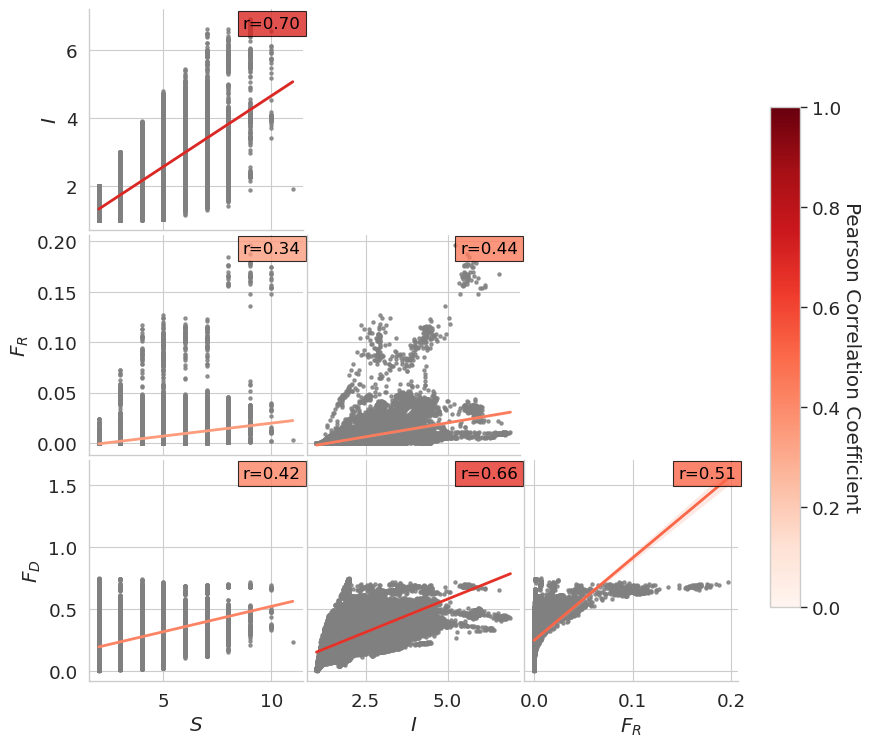

In [184]:
cmap_corr = mpl.colormaps['Reds']
norm_corr = mpl.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df = data[(data['biome']=='med') & (data['N']==50)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
d1 = df[(df['srichness']>1)].iloc[:,2:].rename(columns={'srichness':'$S$', 'isimpson':'$I$', 'frichness':'$F_R$', 'fdivergence':'$F_D$'})

g = sns.PairGrid(d1)
g.map_lower(corrfunc, cmap=cmap_corr, norm=norm_corr, scatter_kws={'s': 5, 'color': 'grey'})
# g.map_diag(sns.histplot, kde=False, element="step", color='grey')
# g.map_upper(corr_heat, cmap=                _corr, norm=norm_corr, grid=False)

# Remove diagonal and upper triangle by hiding the axes
for i in range(len(d1.columns)):
    for j in range(len(d1.columns)):
        if i <= j:  # Diagonal and upper triangle
            g.axes[i, j].set_visible(False)

# Add colorbar
fig = g.fig
cbar_ax = fig.add_axes([0.78, 0.15, 0.03, 0.5])  # [left, bottom, width, height] in figure coordinates
sm = ScalarMappable(norm=norm_corr, cmap=cmap_corr)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Pearson Correlation Coefficient", rotation=270, labelpad=15)

# g.figure.suptitle('Bor-10')
g.fig.subplots_adjust(wspace=0.02, hspace=0.02)

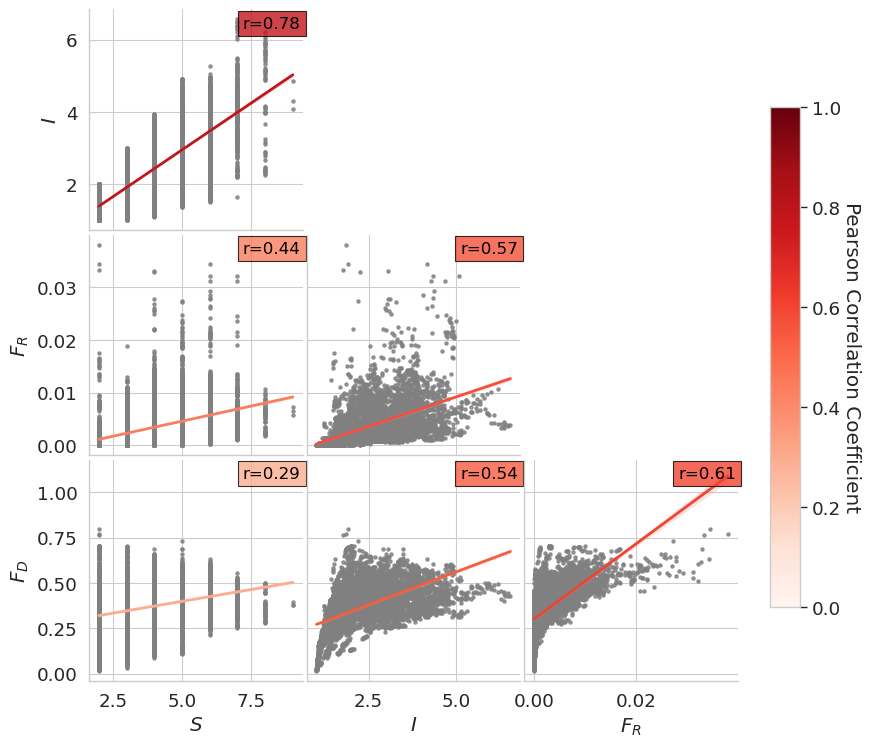

In [185]:
cmap_corr = mpl.colormaps['Reds']
norm_corr = mpl.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df = data[(data['biome']=='bor') & (data['N']==10)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
d1 = df[(df['srichness']>1)].iloc[:,2:].rename(columns={'srichness':'$S$', 'isimpson':'$I$', 'frichness':'$F_R$', 'fdivergence':'$F_D$'})

g = sns.PairGrid(d1)
g.map_lower(corrfunc, cmap=cmap_corr, norm=norm_corr, scatter_kws={'s': 5, 'color': 'grey'})
# g.map_diag(sns.histplot, kde=False, element="step", color='grey')
# g.map_upper(corr_heat, cmap=cmap_corr, norm=norm_corr, grid=False)

# Remove diagonal and upper triangle by hiding the axes
for i in range(len(d1.columns)):
    for j in range(len(d1.columns)):
        if i <= j:  # Diagonal and upper triangle
            g.axes[i, j].set_visible(False)

# Add colorbar
fig = g.fig
cbar_ax = fig.add_axes([0.78, 0.15, 0.03, 0.5])  # [left, bottom, width, height] in figure coordinates
sm = ScalarMappable(norm=norm_corr, cmap=cmap_corr)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Pearson Correlation Coefficient", rotation=270, labelpad=15)

# g.figure.suptitle('Bor-10')
g.fig.subplots_adjust(wspace=0.02, hspace=0.02)

In [186]:
def corr_pvalue_pearson(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = scs.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    corr_matrix = df.corr(method='pearson')
    return pd.DataFrame(data=p_matrix, columns=corr_matrix.columns.values, index=corr_matrix.index.values)

In [187]:
labels_corr = ('$S$', '$I$', '$F_R$', '$F_D$')
cmap_corr = mpl.colormaps['Reds']
norm_corr = mpl.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

In [188]:
# data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df = data[(data['biome']=='med') & (data['N']==10)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
df = df[(df['srichness']>1)].iloc[:,2:]
corr_matrix_med10 = df.corr(method='pearson')
p_values_med10 = corr_pvalue_pearson(df)

# data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df = data[(data['biome']=='med') & (data['N']==50)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
df = df[(df['srichness']>1)].iloc[:,2:]
corr_matrix_med50 = df.corr(method='pearson')
p_values_med50 = corr_pvalue_pearson(df)

# data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df = data[(data['biome']=='bor') & (data['N']==10)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
df = df[(df['srichness']>1)].iloc[:,2:]
corr_matrix_bor10 = df.corr(method='pearson')
p_values_bor10 = corr_pvalue_pearson(df)

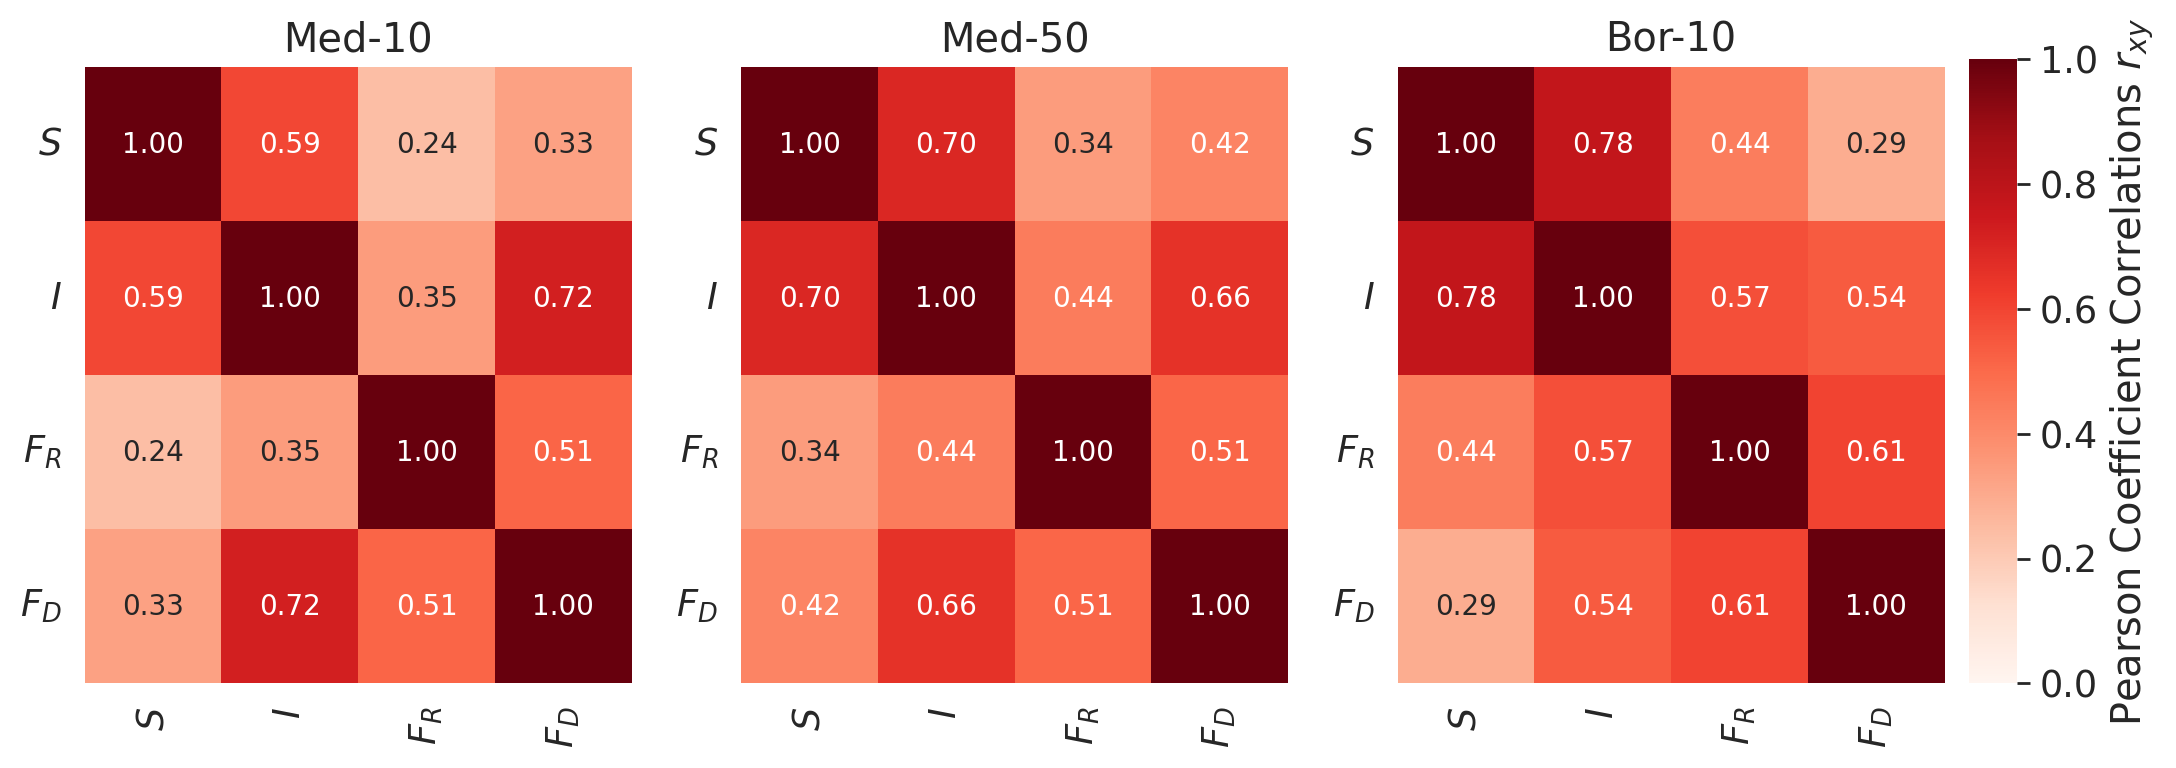

In [189]:
fig, ax2 = plt.subplots(1,3, figsize=(12,4), sharex=True, dpi=200)
cbar_ax = fig.add_axes([.91, .11, .02, .78])

sns.heatmap(corr_matrix_med10, annot=True, annot_kws={"size": 10}, fmt='.2f', mask=(p_values_med10 > 0.05), ax=ax2[0],
            norm=norm_corr, cmap=cmap_corr, cbar=None)
# ax2[0].text(0.1, 1.1, '(a)', transform=ax2[0].transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax2[0].set_title('Med-10')

sns.heatmap(corr_matrix_med50, annot=True, annot_kws={"size": 10}, fmt='.2f', mask=(p_values_med50 > 0.05), ax=ax2[1],
            norm=norm_corr, cmap=cmap_corr, cbar=None)
# ax2[1].text(0.1, 1.1, '(b)', transform=ax2[1].transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax2[1].set_title('Med-50')

sns.heatmap(corr_matrix_bor10, annot=True, annot_kws={"size": 10}, fmt='.2f', mask=(p_values_bor10 > 0.05), ax=ax2[2],
            norm=norm_corr, cmap=cmap_corr, cbar_kws={'label':"Pearson Coefficient Correlations $r_{xy}$"}, cbar_ax=cbar_ax)
# ax2[2].text(0.1, 1.1, '(c)', transform=ax2[2].transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax2[2].set_title('Bor-10')

for ax in ax2:
    ax.xaxis.set(ticklabels=labels_corr)
    ax.yaxis.set(ticklabels=labels_corr)

In [12]:
def corr_heat(x, y, **kwds):
    cmap = kwds['cmap']
    norm = kwds['norm']
    ax = plt.gca()
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = scs.pearsonr(x, y)
    facecolor = cmap(norm(r))
    ax.set_facecolor(facecolor)
    lightness = (max(facecolor[:3]) + min(facecolor[:3]) ) / 2
    ax.annotate(f"r={r:.2f}", xy=(.5, .5), xycoords=ax.transAxes,
                color='white' if lightness < 0.7 else 'black', size=26, ha='center', va='center')
    ax.grid(False)
    
def corr_reg(x, y, **kwds):
    cmap = kwds['cmap']
    norm = kwds['norm']
    ax = plt.gca()
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = scs.pearsonr(x, y)
    # facecolor = cmap(norm(r))
    # ax.set_facecolor(facecolor)
    # lightness = (max(facecolor[:3]) + min(facecolor[:3]) ) / 2
    # ax.annotate(f"r={r:.2f}", xy=(.5, .5), xycoords=ax.transAxes,
    #             color='white' if lightness < 0.7 else 'black', size=26, ha='center', va='center')

    # Set the regression line color dynamically based on correlation
    scatter_kws = kwds.get('scatter_kws', {'s': 10, 'color': 'pink'})
    line_color = cmap(norm(r))  # Match line color with heatmap color
    line_kws = kwds.get('line_kws', {'color': line_color, 'linewidth': 2})
    sns.regplot(x=x, y=y, scatter_kws=scatter_kws, line_kws=line_kws, ax=ax)

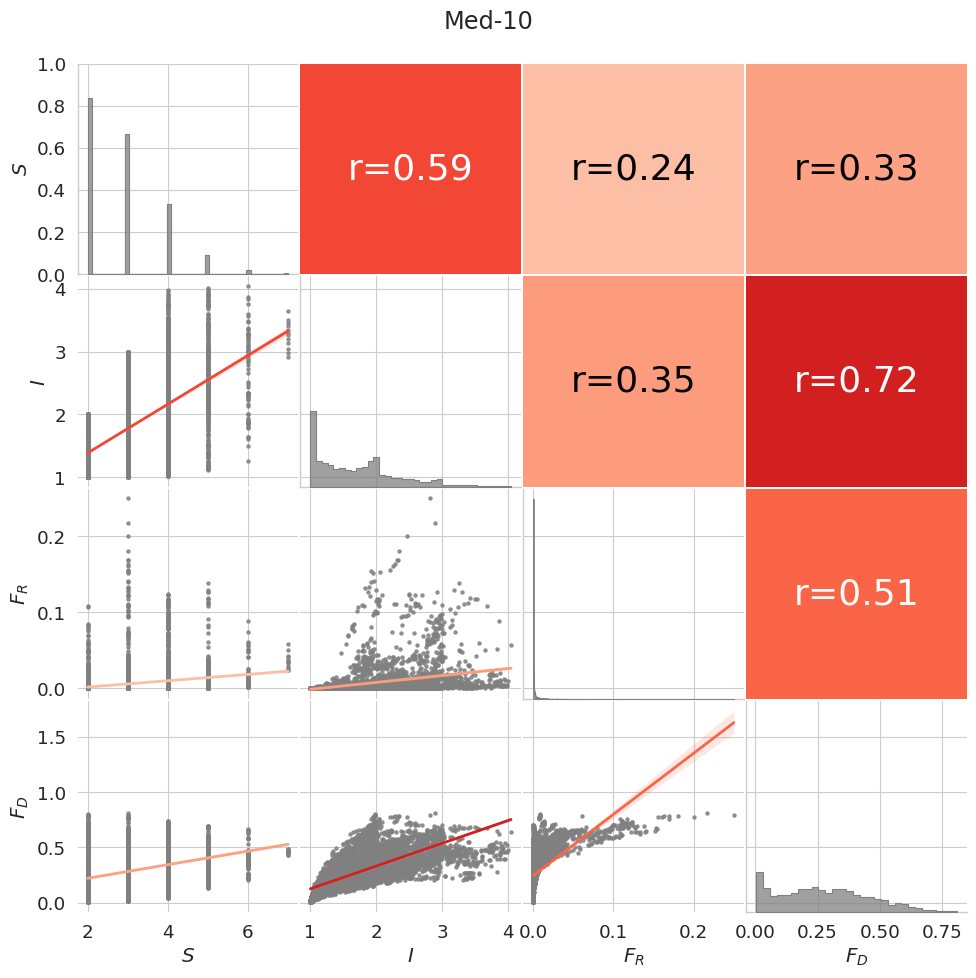

In [13]:
cmap_corr = mpl.colormaps['Reds']
norm_corr = mpl.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df = data[(data['biome']=='med') & (data['N']==10)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
d1 = df[(df['srichness']>1)].iloc[:,2:].rename(columns={'srichness':'$S$', 'isimpson':'$I$', 'frichness':'$F_R$', 'fdivergence':'$F_D$'})

g = sns.PairGrid(d1)
g.map_lower(corr_reg, cmap=cmap_corr, norm=norm_corr, scatter_kws={'s': 5, 'color': 'grey'})
g.map_diag(sns.histplot, kde=False, element="step", color='grey')
g.map_upper(corr_heat, cmap=cmap_corr, norm=norm_corr, grid=False)
g.figure.suptitle('Med-10')
plt.tight_layout()
g.fig.subplots_adjust(wspace=0.01, hspace=0.01)

#### All together correlation

In [ ]:
data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
data = data.set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
df = data[data['srichness']>1].iloc[:,2:]
corr_matrix = df.corr(method='pearson')
p_values = corr_pvalue_pearson(df)
mask_matrix = corr_matrix.mask(p_values > 0.05)
corr_matrix

srichness  isimpson  frichness  fdivergence
srichness     1.000000  0.707644   0.297564     0.371863
isimpson      0.707644  1.000000   0.393037     0.633836
frichness     0.297564  0.393037   1.000000     0.485614
fdivergence   0.371863  0.633836   0.485614     1.000000

[[Text(0, 0.5, '$S$'),
  Text(0, 1.5, '$I$'),
  Text(0, 2.5, '$F_R$'),
  Text(0, 3.5, '$F_D$')]]

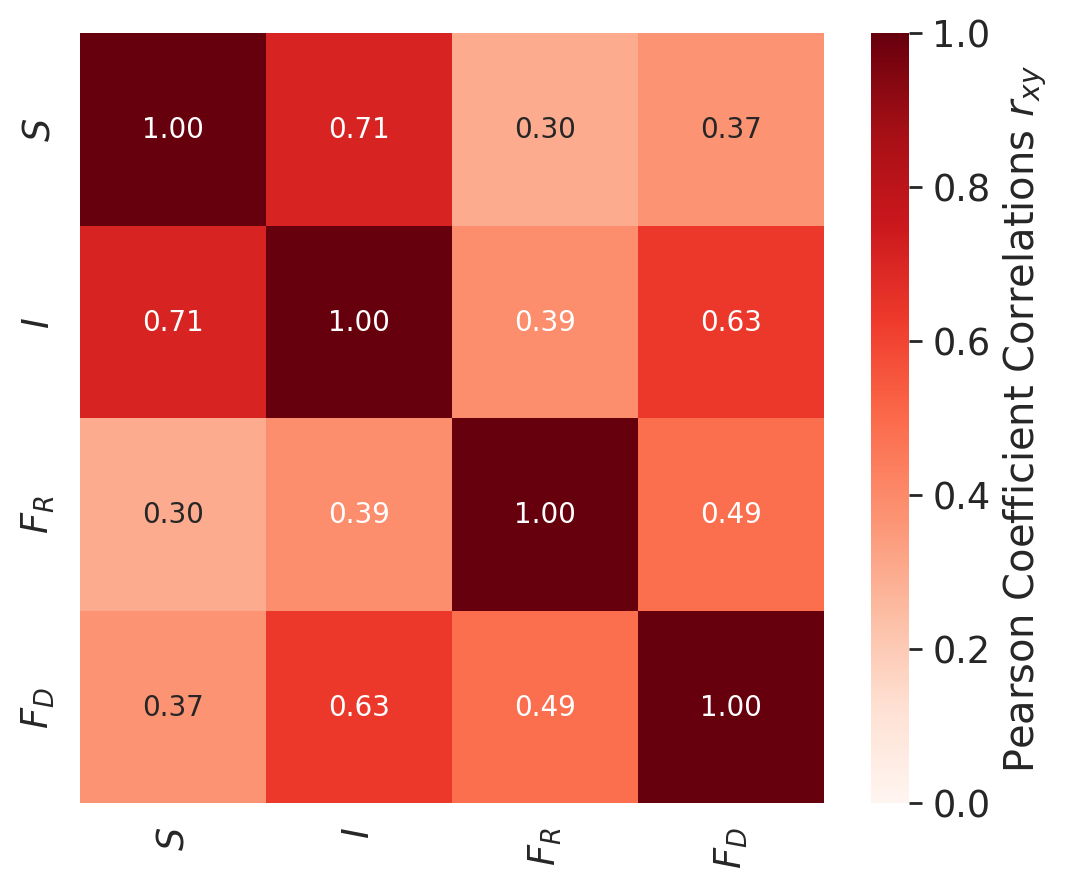

In [ ]:
labels = ('$S$', '$I$', '$F_R$', '$F_D$')

cmap = mpl.colormaps['Reds']
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

fig, ax2 = plt.subplots(1,1, figsize=(6,5), dpi=200)

sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 10}, fmt='.2f', mask=(p_values > 0.05), norm=norm, cmap=cmap, cbar_kws={'label':"Pearson Coefficient Correlations $r_{xy}$"})

ax2.xaxis.set(ticklabels=labels)
ax2.yaxis.set(ticklabels=labels)

Unnamed: 0 biome   N  ncom  init         frt  srichness  isimpson  \
0               0   med  10     1     1  300.204501          1  1.000000   
1               1   med  10     1     2  330.987580          1  1.000000   
2               2   med  10     1     3  190.522146          1  1.000000   
3               3   med  10     1     4  277.254623          1  1.000000   
4               4   med  10     1     5  247.715890          1  1.000000   
...           ...   ...  ..   ...   ...         ...        ...       ...   
75995       75995   med  50  1000    48   24.597571          2  1.032824   
75996       75996   med  50  1000    49   25.369989          2  1.042916   
75997       75997   med  50  1000    50   24.715530          2  1.043562   
75998       75998   med  50  1000    51   24.066325          2  1.018454   
75999       75999   med  50  1000    52   24.438829          2  1.044972   

          frichness  fdivergence  
0      0.000000e+00     0.000000  
1      0.000000e+00     0.000000  
2      0.000000e+00     0.000000  
3      0.000000e+00     0.000000  
4      0.000000e+00     0.000000  
...             ...          ...  
75995  6.404142e-10     0.014152  
75996  1.936028e-09     0.021929  
75997  1.845927e-09     0.022717  
75998  1.952652e-10     0.010591  
75999  1.691819e-09     0.022729  

[76000 rows x 10 columns]

### Other stuff

#### Fire regime analyses

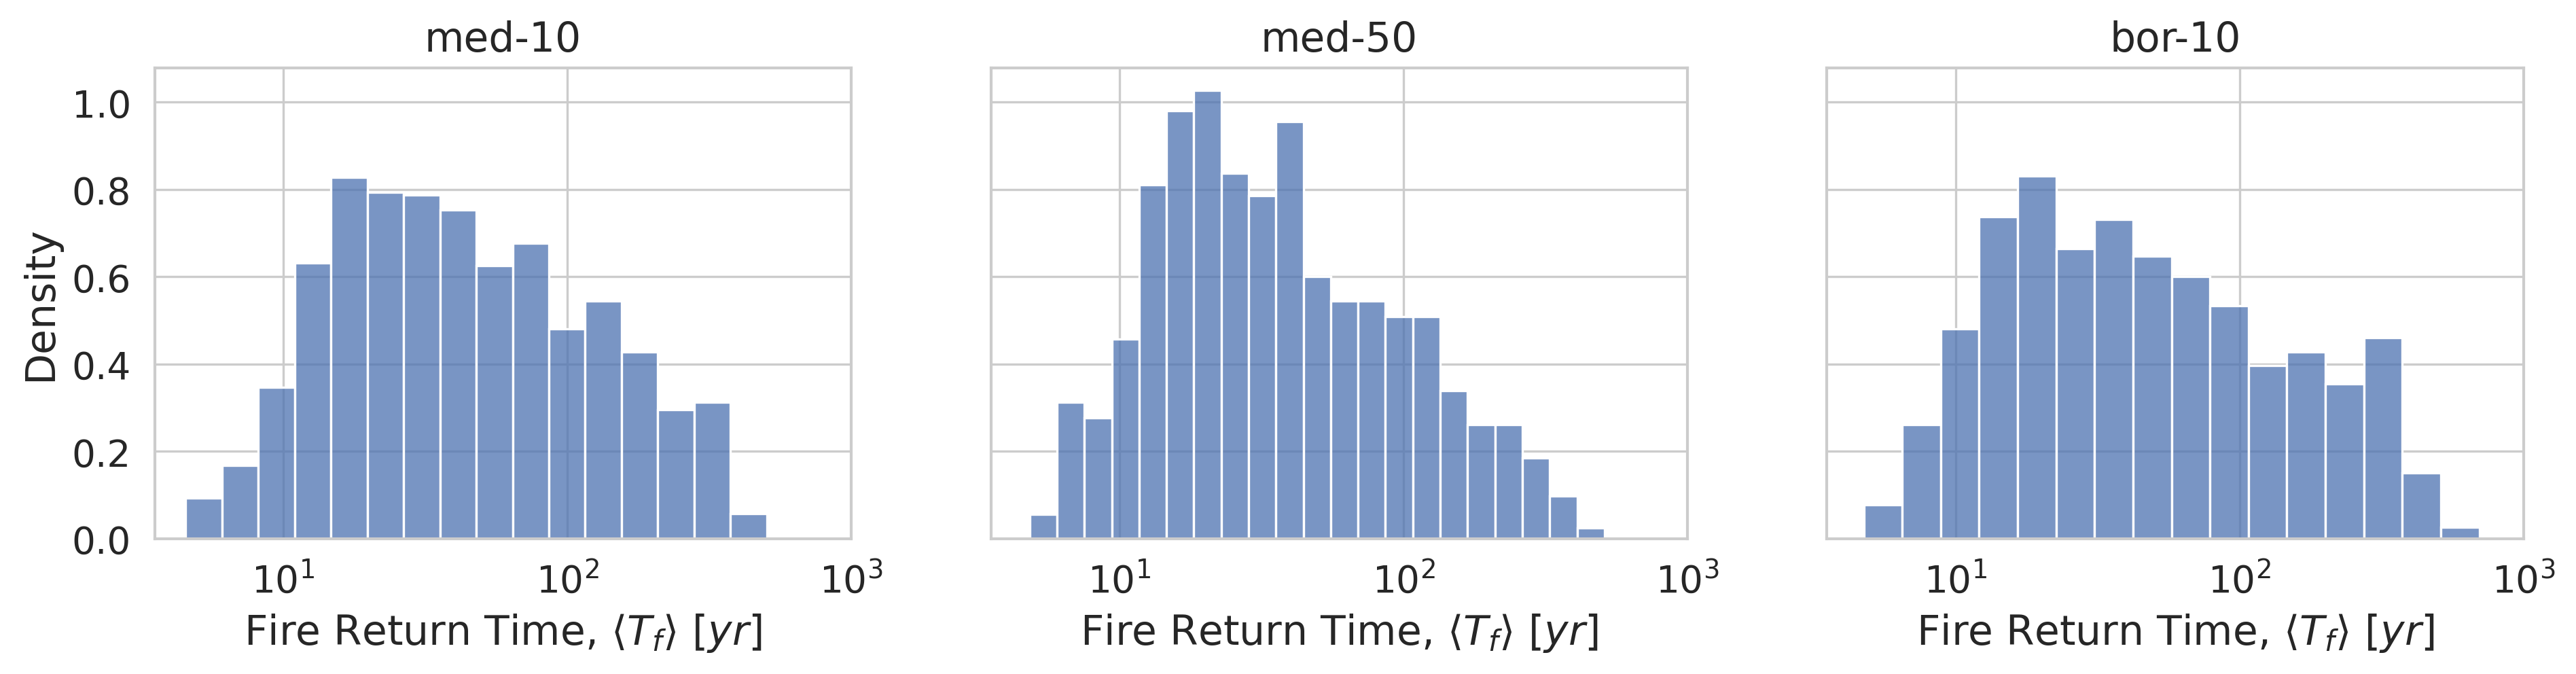

In [74]:
df2 = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df2['frt']=np.log10(df2['frt'])

fig, ax2 = plt.subplots(1,3, figsize=(15,3), sharey=True, sharex=True, dpi=300)

n=10
biome='med'
data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
sns.histplot(data=data, x="frt", stat='density', ax=ax2[0])
ax2[0].set_title(f'{biome}-{n}')

n=50
biome='med'
data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
sns.histplot(data=data, x="frt", stat='density', ax=ax2[1])
ax2[1].set_title(f'{biome}-{n}')

n=10
biome='bor'
data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
sns.histplot(data=data, x="frt", stat='density', ax=ax2[2])
ax2[2].set_title(f'{biome}-{n}')

for ax in ax2:
    ax.set_xlabel(r"Fire Return Time, $\langle T_f \rangle$ [$yr$]")
    
    # Set x label displaying the power of 10
    ticks = [1, 2, 3]
    ax.set_xticks(ticks)
    ax.set_xticklabels([fr'$10^{i}$' for i in ticks])

#### Alternative states Hypervolume plot

In [29]:
df2 = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df2[(df2['N']==50)&(df2['biome']=='med') & (df2['frichness']>0.15)].sort_values('frichness')

Unnamed: 0 biome   N  ncom  alt_stat        frt  srichness  isimpson  \
3031        3031   med  50   139        50  14.756522          9  5.594457   
3032        3032   med  50   139        51  14.383247         10  6.007209   
3030        3030   med  50   139        49  15.055222          8  5.550609   
3799        3799   med  50   518        29  14.605311          5  3.539818   
3800        3800   med  50   518        30  15.771536          6  3.914673   
3801        3801   med  50   518        31  16.974523          7  4.286028   

      frichness  fdivergence  
3031   0.188771     0.882580  
3032   0.205190     0.887079  
3030   0.213596     0.902458  
3799   0.252899     1.292907  
3800   0.290595     1.389062  
3801   0.303971     1.478563

In [22]:
df_med50 = df2[(df2['N']==50)&(df2['biome']=='med')]
df_med50[df_med50['ncom']==139]

Unnamed: 0 biome   N  ncom  alt_stat        frt  srichness  isimpson  \
3030        3030   med  50   139        49  15.055222          8  5.550609   
3031        3031   med  50   139        50  14.756522          9  5.594457   
3032        3032   med  50   139        51  14.383247         10  6.007209   

      frichness  fdivergence  
3030   0.213596     0.902458  
3031   0.188771     0.882580  
3032   0.205190     0.887079

In [23]:
df_med50 = df2[(df2['N']==50)&(df2['biome']=='med')]
df_med50[df_med50['ncom']==518]

Unnamed: 0 biome   N  ncom  alt_stat        frt  srichness  isimpson  \
3799        3799   med  50   518        29  14.605311          5  3.539818   
3800        3800   med  50   518        30  15.771536          6  3.914673   
3801        3801   med  50   518        31  16.974523          7  4.286028   

      frichness  fdivergence  
3799   0.252899     1.292907  
3800   0.290595     1.389062  
3801   0.303971     1.478563

I    8
C    8
R    8
L    8
dtype: int64


I    9
C    9
R    9
L    9
dtype: int64
I    10
C    10
R    10
L    10
dtype: int64


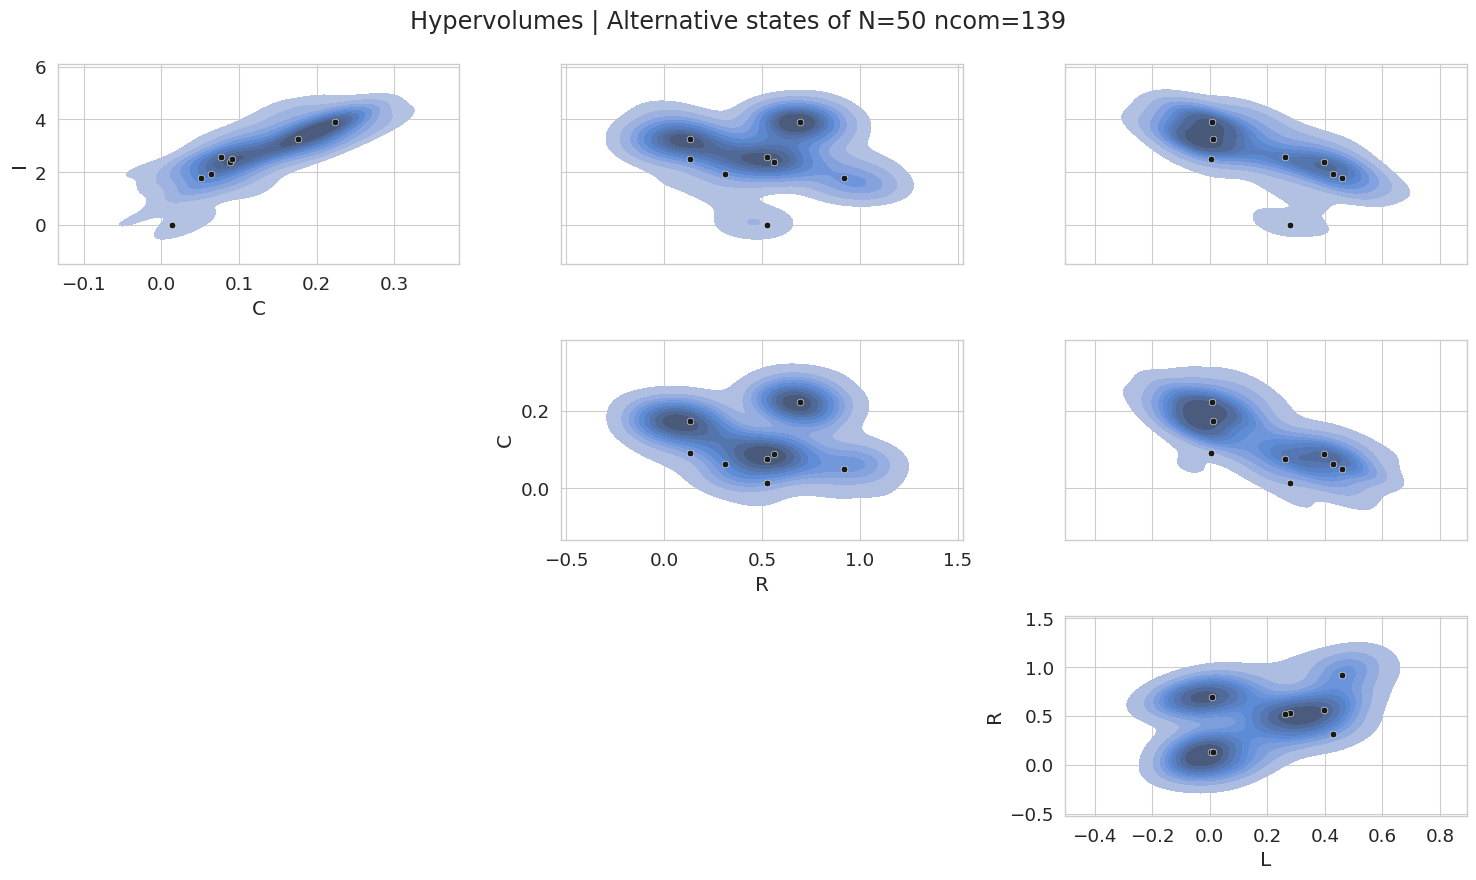

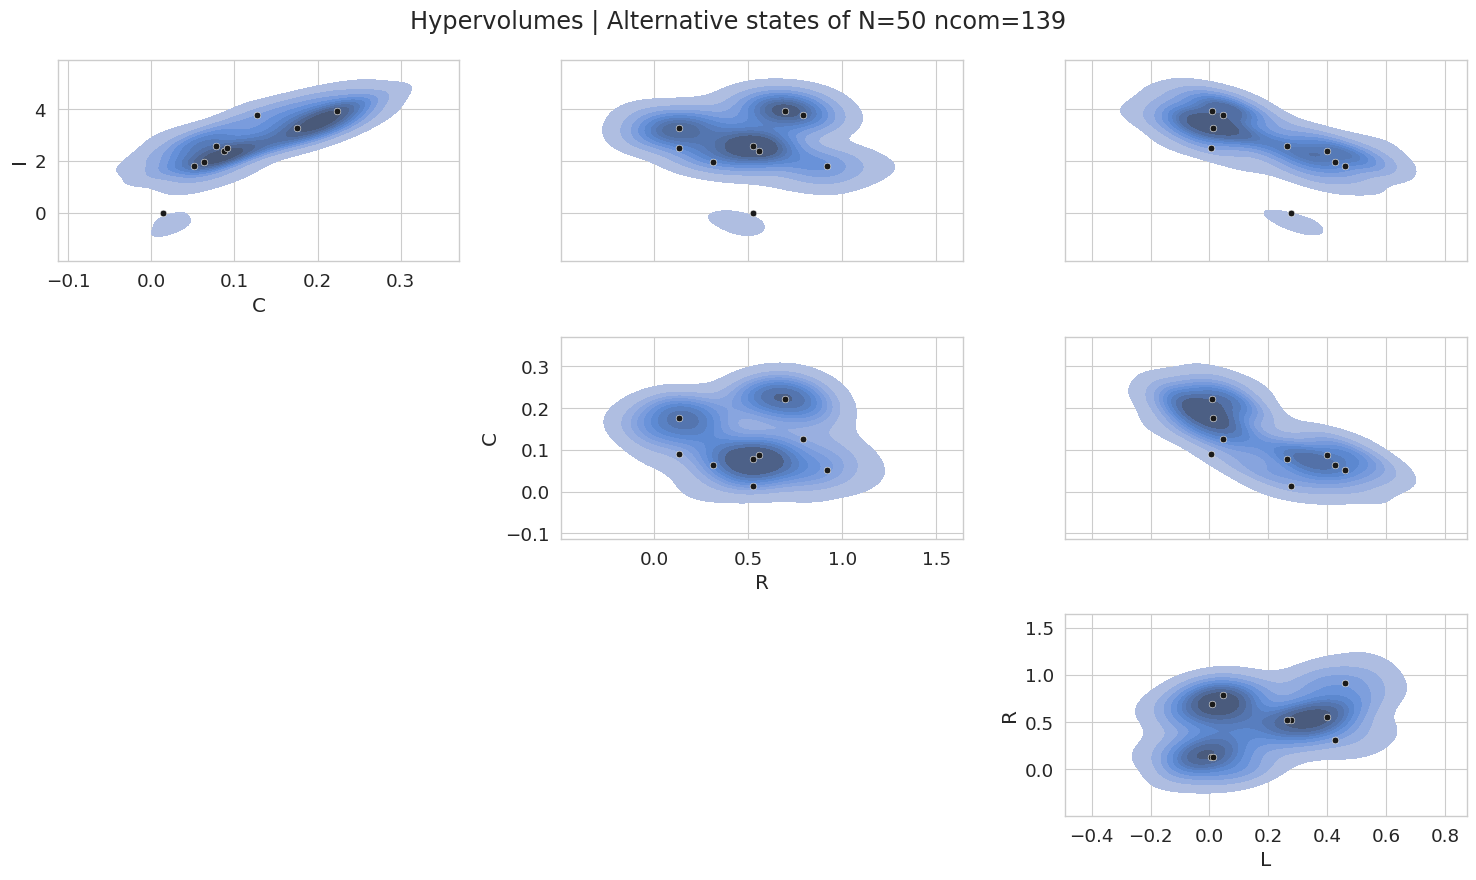

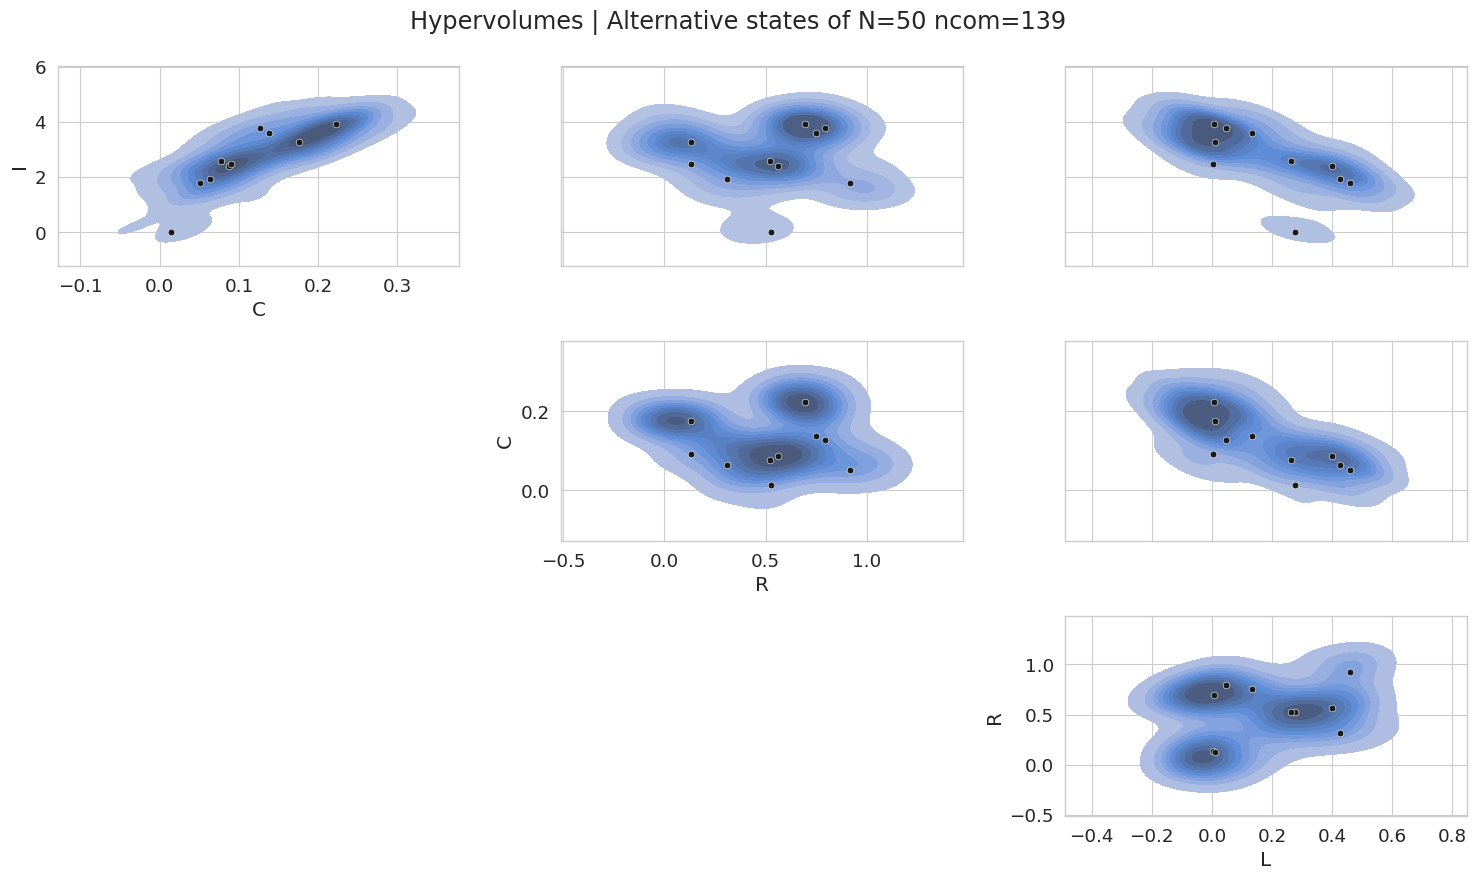

In [47]:
df_temp = pd.DataFrame(index=['I','C','R','L']).T

for index, row in df_med50[df_med50['ncom']==139].iterrows():

    NP = row['N']
    i_com = row['ncom']
    ast = row['alt_stat']

    df = pd.read_csv(os.path.join(f'/work/users/mtorrassa/biofire-idh/data/',f'comp{int(NP)}/coms-n{int(NP)}-{biome}-{int(i_com)}-{int(ast)}.csv'))
    df['I'] = np.log(df['I'])
    # df['C'] = np.log(df['C'])
    df = df.drop(columns=['M', 'Unnamed: 0'])

    print(df.drop_duplicates().count())

    np_temp = df.to_numpy()
    hv_temp = hvb.hypervolume(np_temp)
    df_hv = pd.DataFrame(hv_temp, columns=['I','C','R','L'])

    df_sng = df.drop_duplicates()

    fig, axs = plt.subplots(3, 3, figsize=(15, 9))
    fig.suptitle(f"Hypervolumes | Alternative states of N={NP} ncom={i_com}")

    sns.kdeplot(data=df_hv, x="C", y="I", warn_singular=False, ax=axs[0,0], fill=True)
    sns.scatterplot(data=df_sng, x='C', y='I', ax=axs[0,0], c='k')
    sns.kdeplot(data=df_hv, x="R", y="I", warn_singular=False, ax=axs[0,1], fill=True)
    sns.scatterplot(data=df_sng, x='R', y='I', ax=axs[0,1], c='k')
    axs[0,1].label_outer()
    sns.kdeplot(data=df_hv, x="L", y="I", warn_singular=False, ax=axs[0,2], fill=True)
    sns.scatterplot(data=df_sng, x='L', y='I', ax=axs[0,2], c='k')
    axs[0,2].label_outer()

    sns.kdeplot(data=df_hv, x="R", y="C", warn_singular=False, ax=axs[1,1], fill=True)
    sns.scatterplot(data=df_sng, x='R', y='C', ax=axs[1,1], c='k')
    sns.kdeplot(data=df_hv, x="L", y="C", warn_singular=False, ax=axs[1,2], fill=True)
    sns.scatterplot(data=df_sng, x='L', y='C', ax=axs[1,2], c='k')
    axs[1,2].label_outer()

    sns.kdeplot(data=df_hv, x="L", y="R", warn_singular=False, ax=axs[2,2], fill=True)
    sns.scatterplot(data=df_sng, x='L', y='R', ax=axs[2,2], c='k')

    # for ax in axs[0,:]:
    #     ax.set(ylim=(-1.5,3.5))

    # for ax in axs[1,:]:
    #     ax.set(ylim=(-0.01,0.2))
    # for ax in axs[:,0]:
    #     ax.set(xlim=(-0.01,0.2))

    # for ax in axs[2,:]:
    #     ax.set(ylim=(-0.2,1.2))
    # for ax in axs[:,1]:
    #     ax.set(xlim=(-0.2,1.2))

    # for ax in axs[:,2]:
    #     ax.set(xlim=(-0.02,0.06))

    axs[1,0].remove()
    axs[2,0].remove()
    axs[2,1].remove()

    plt.tight_layout()